Install necessary libraries

In [1]:
# TODO uncomment to install tesseract if pytesseract isnt recognised
!sudo apt install tesseract-ocr
!pip install pytesseract

# TODO uncomment to install the python-Levenshtein library for similarity check
!pip install python-Levenshtein

# TODO uncoomment to install rdflib
!pip install rdflib



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,437 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

#Image Pre-Processing
import image, convert to gray scale, apply guassian sharpen and threshold

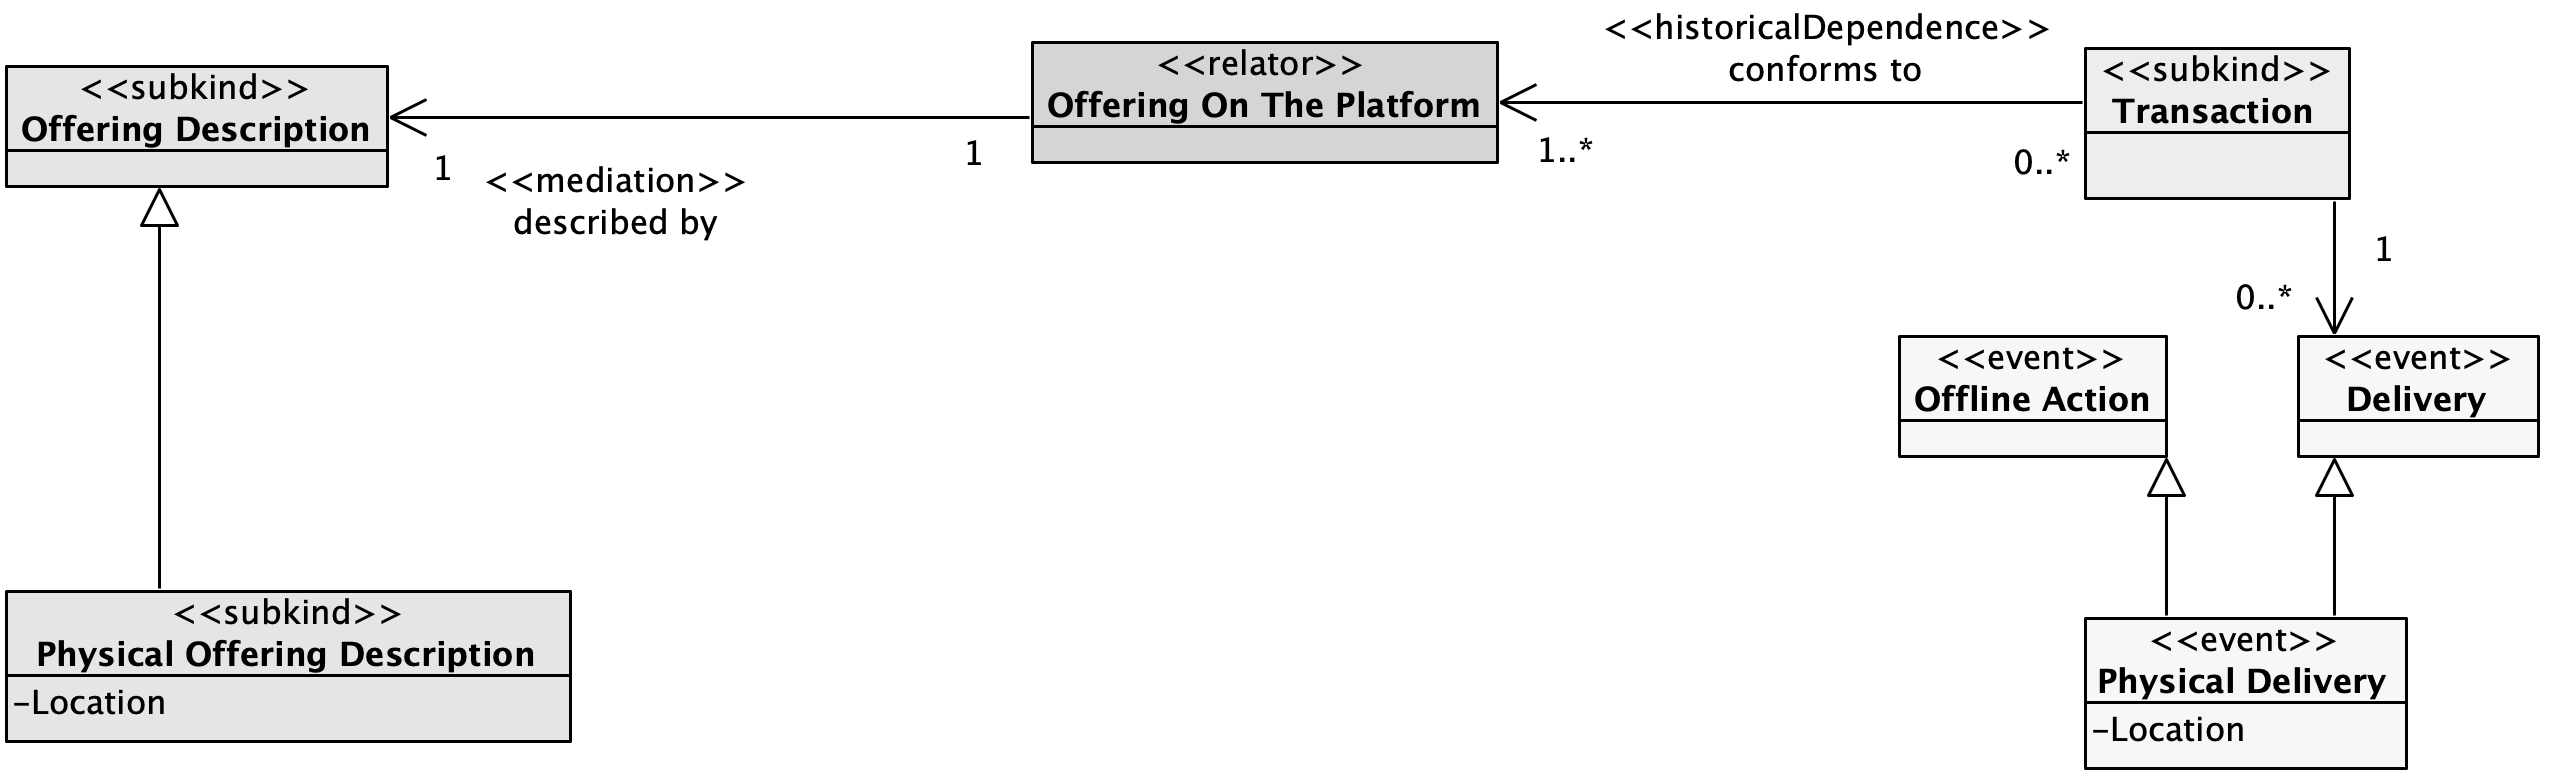

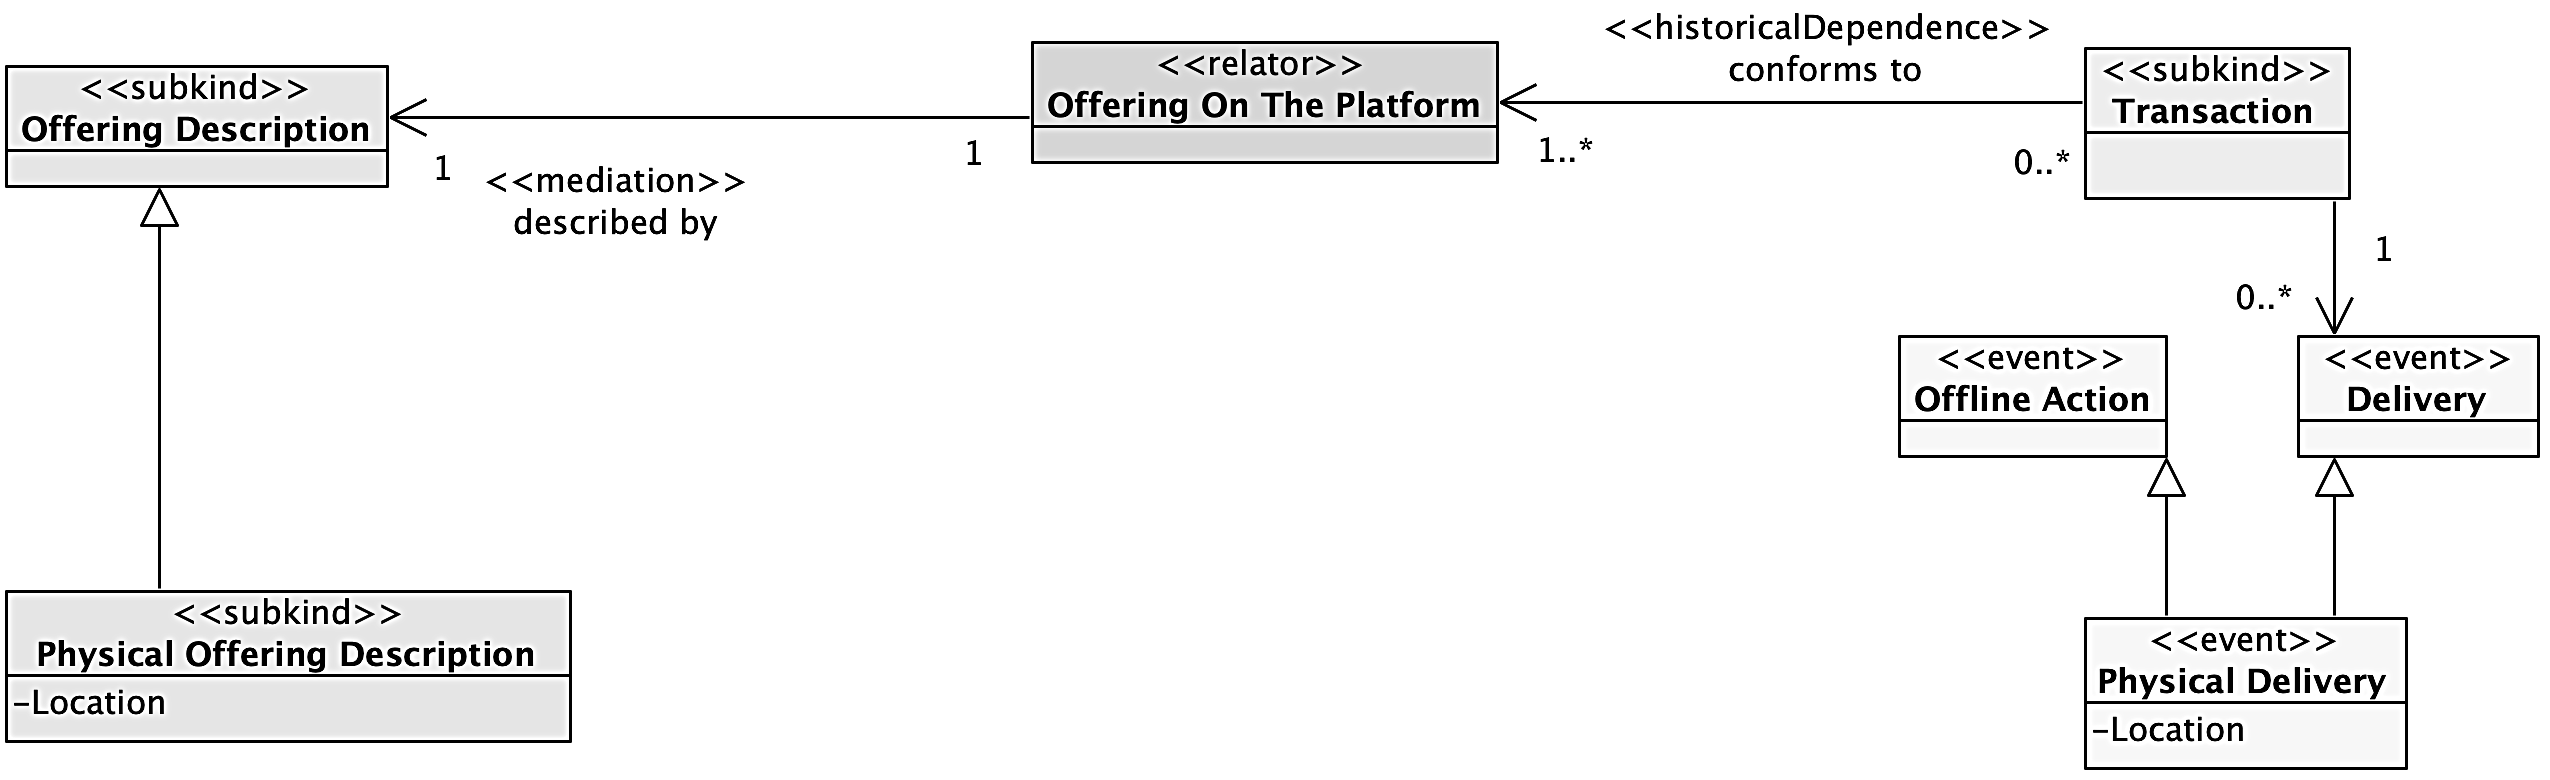

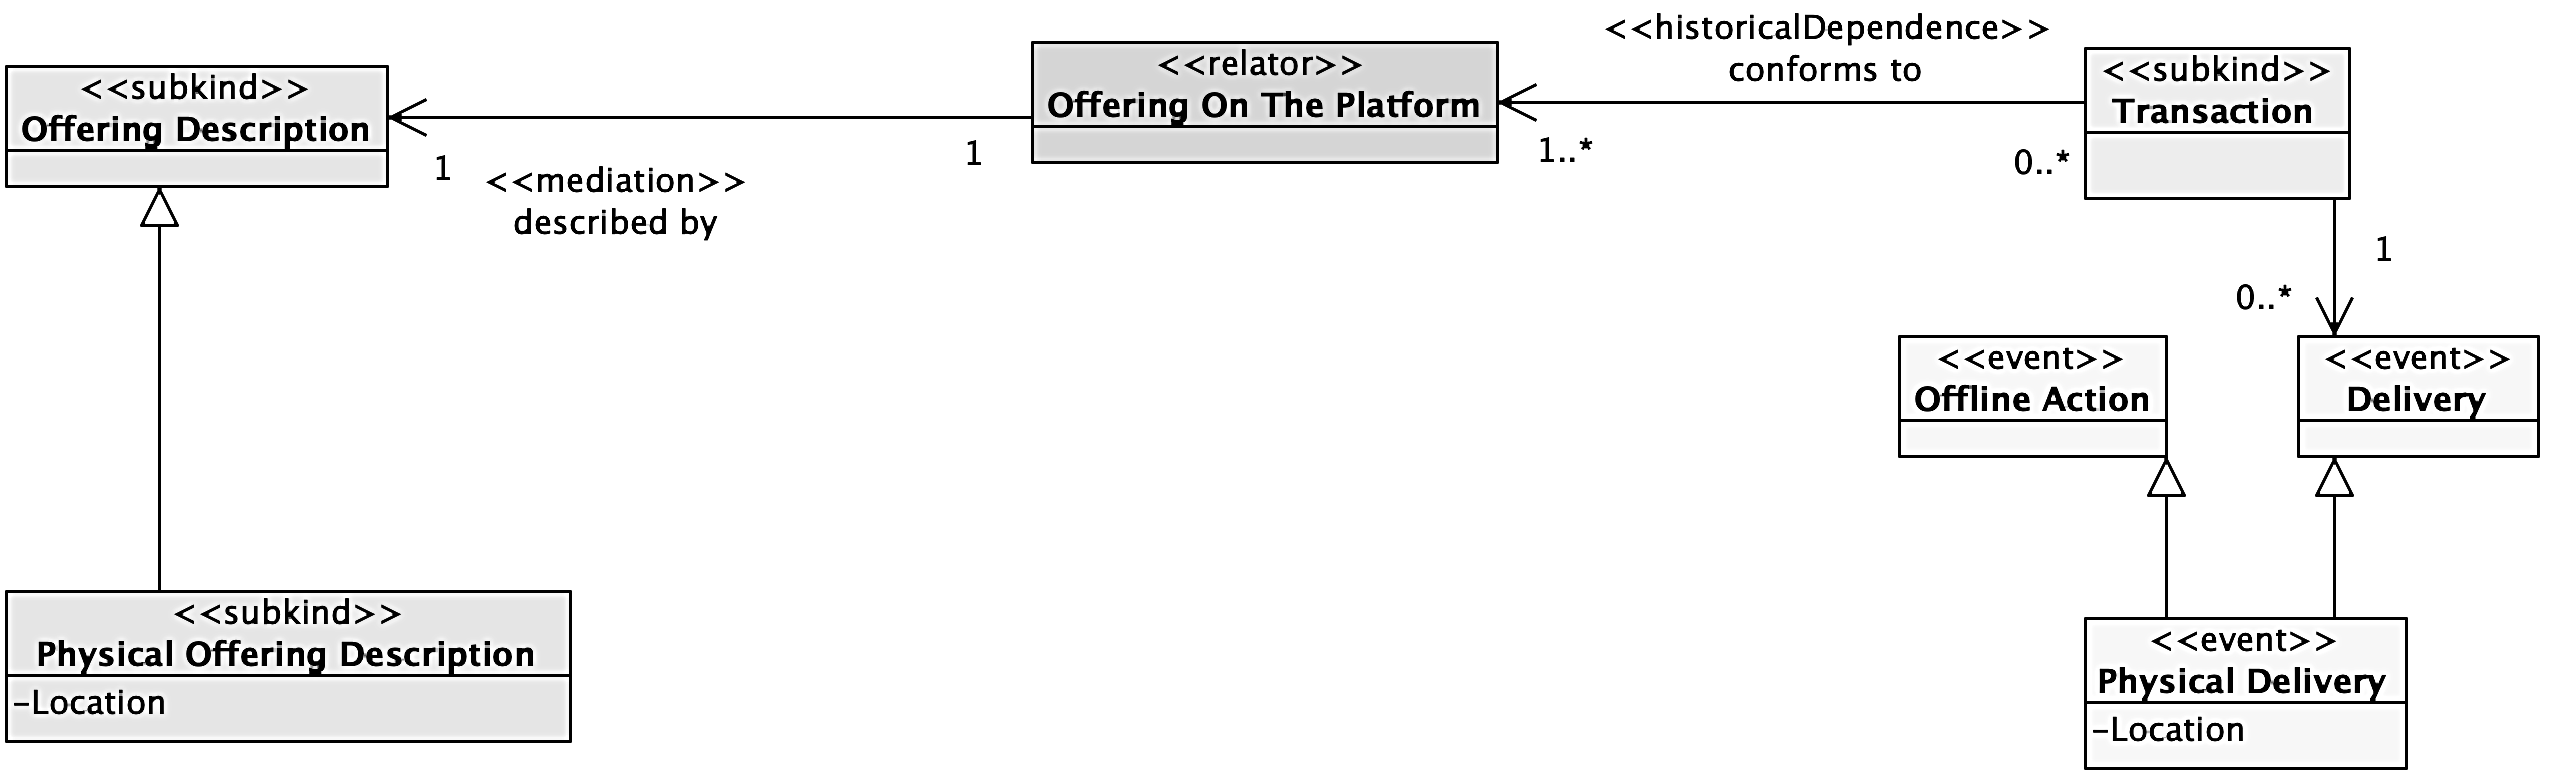

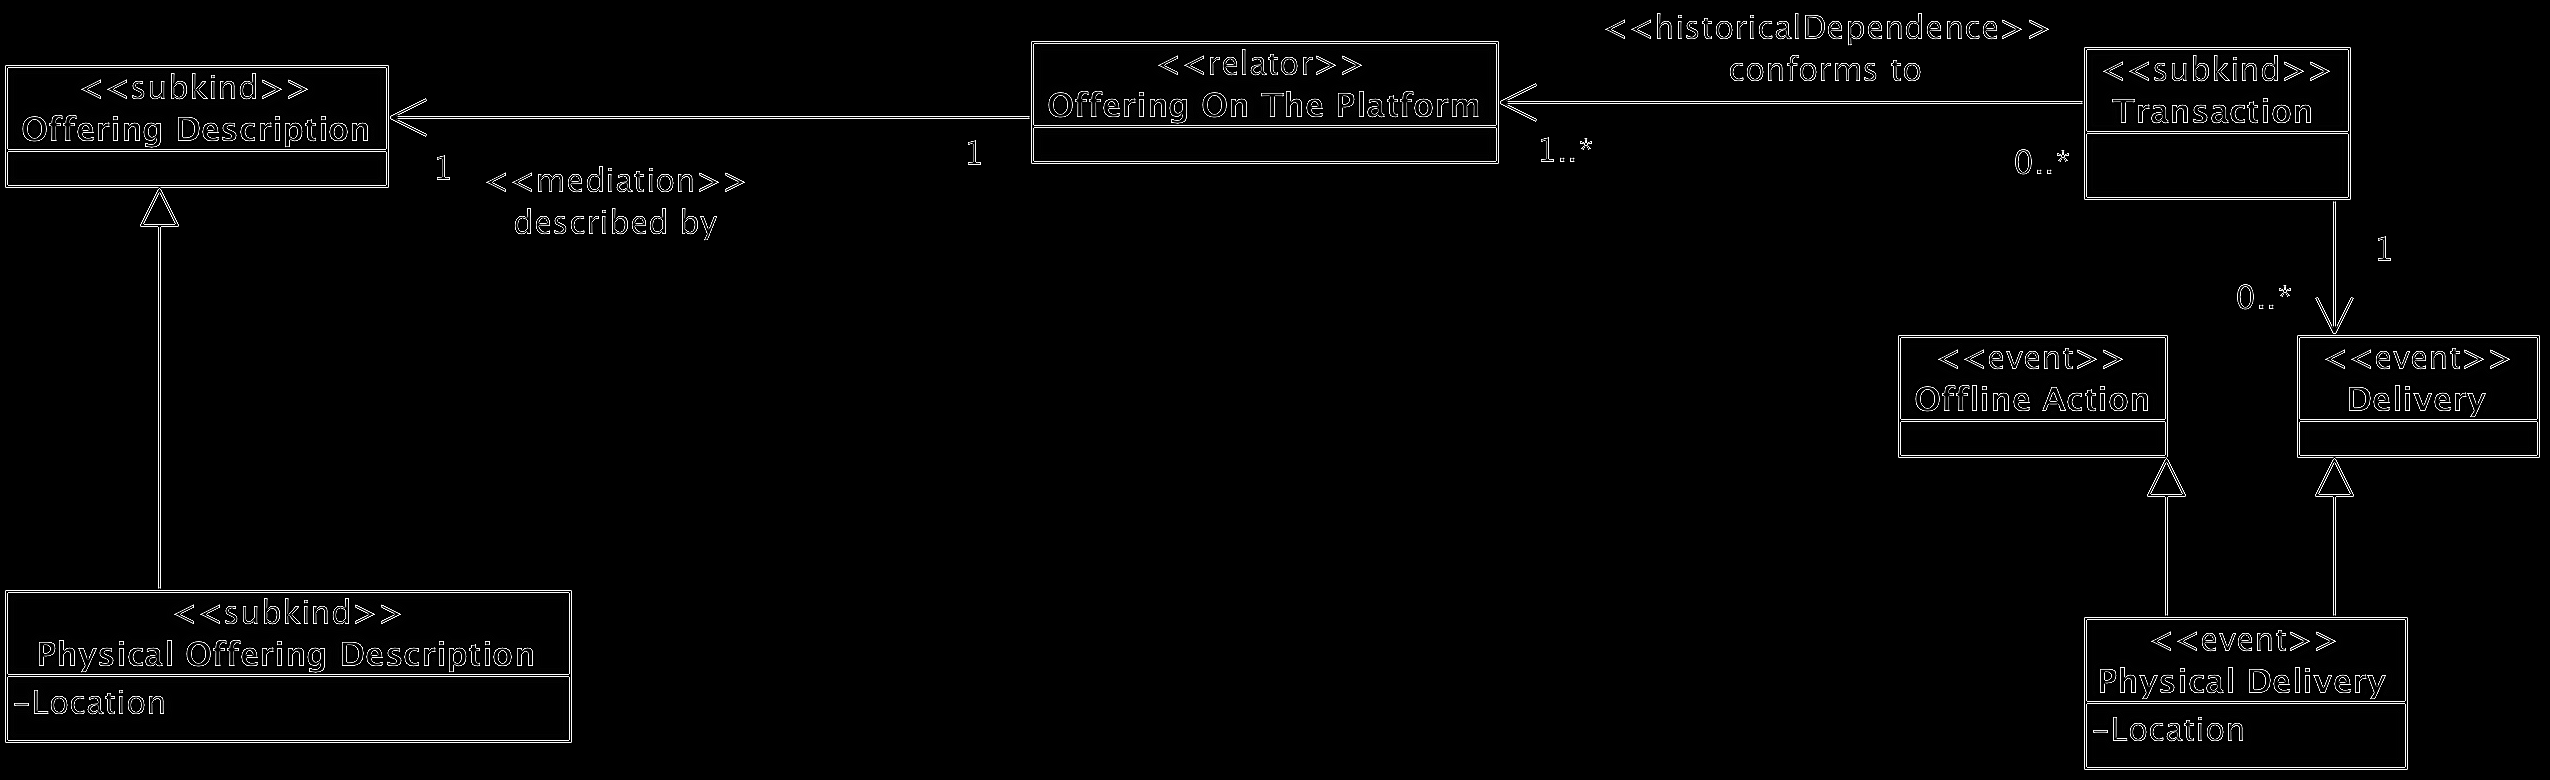

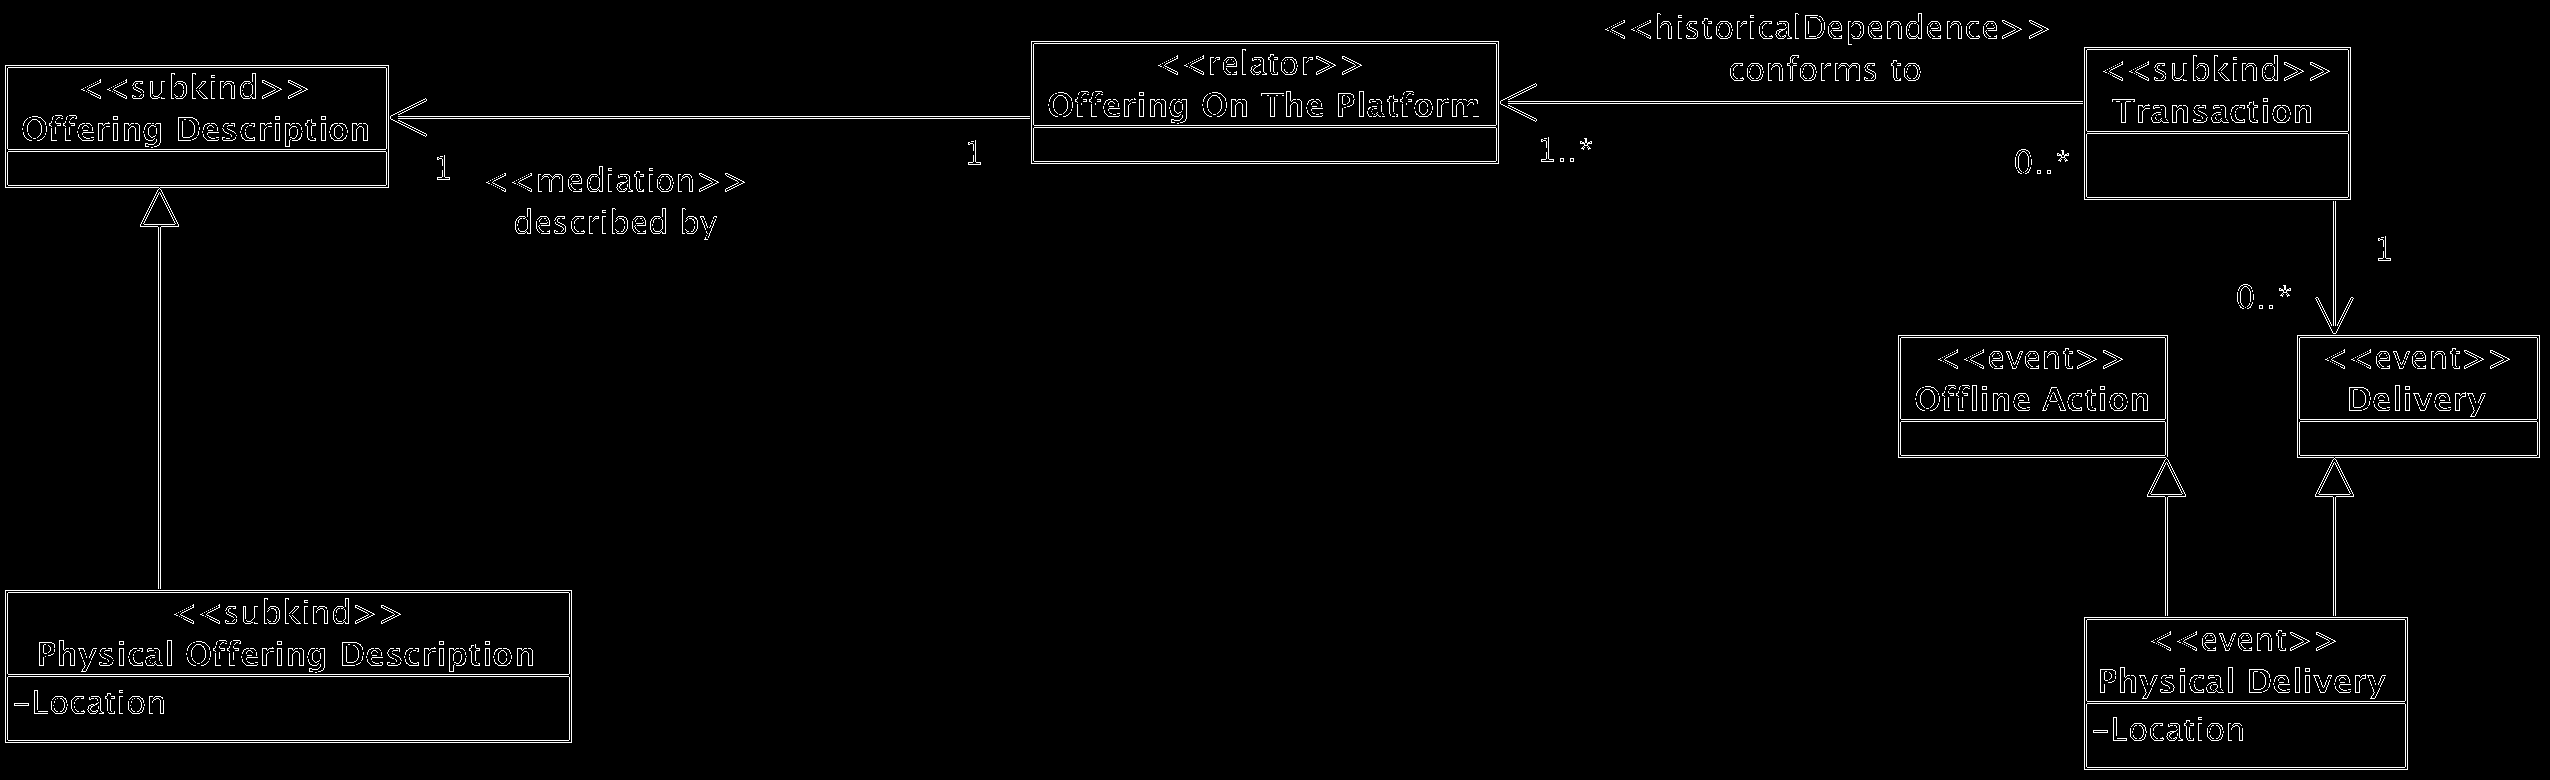

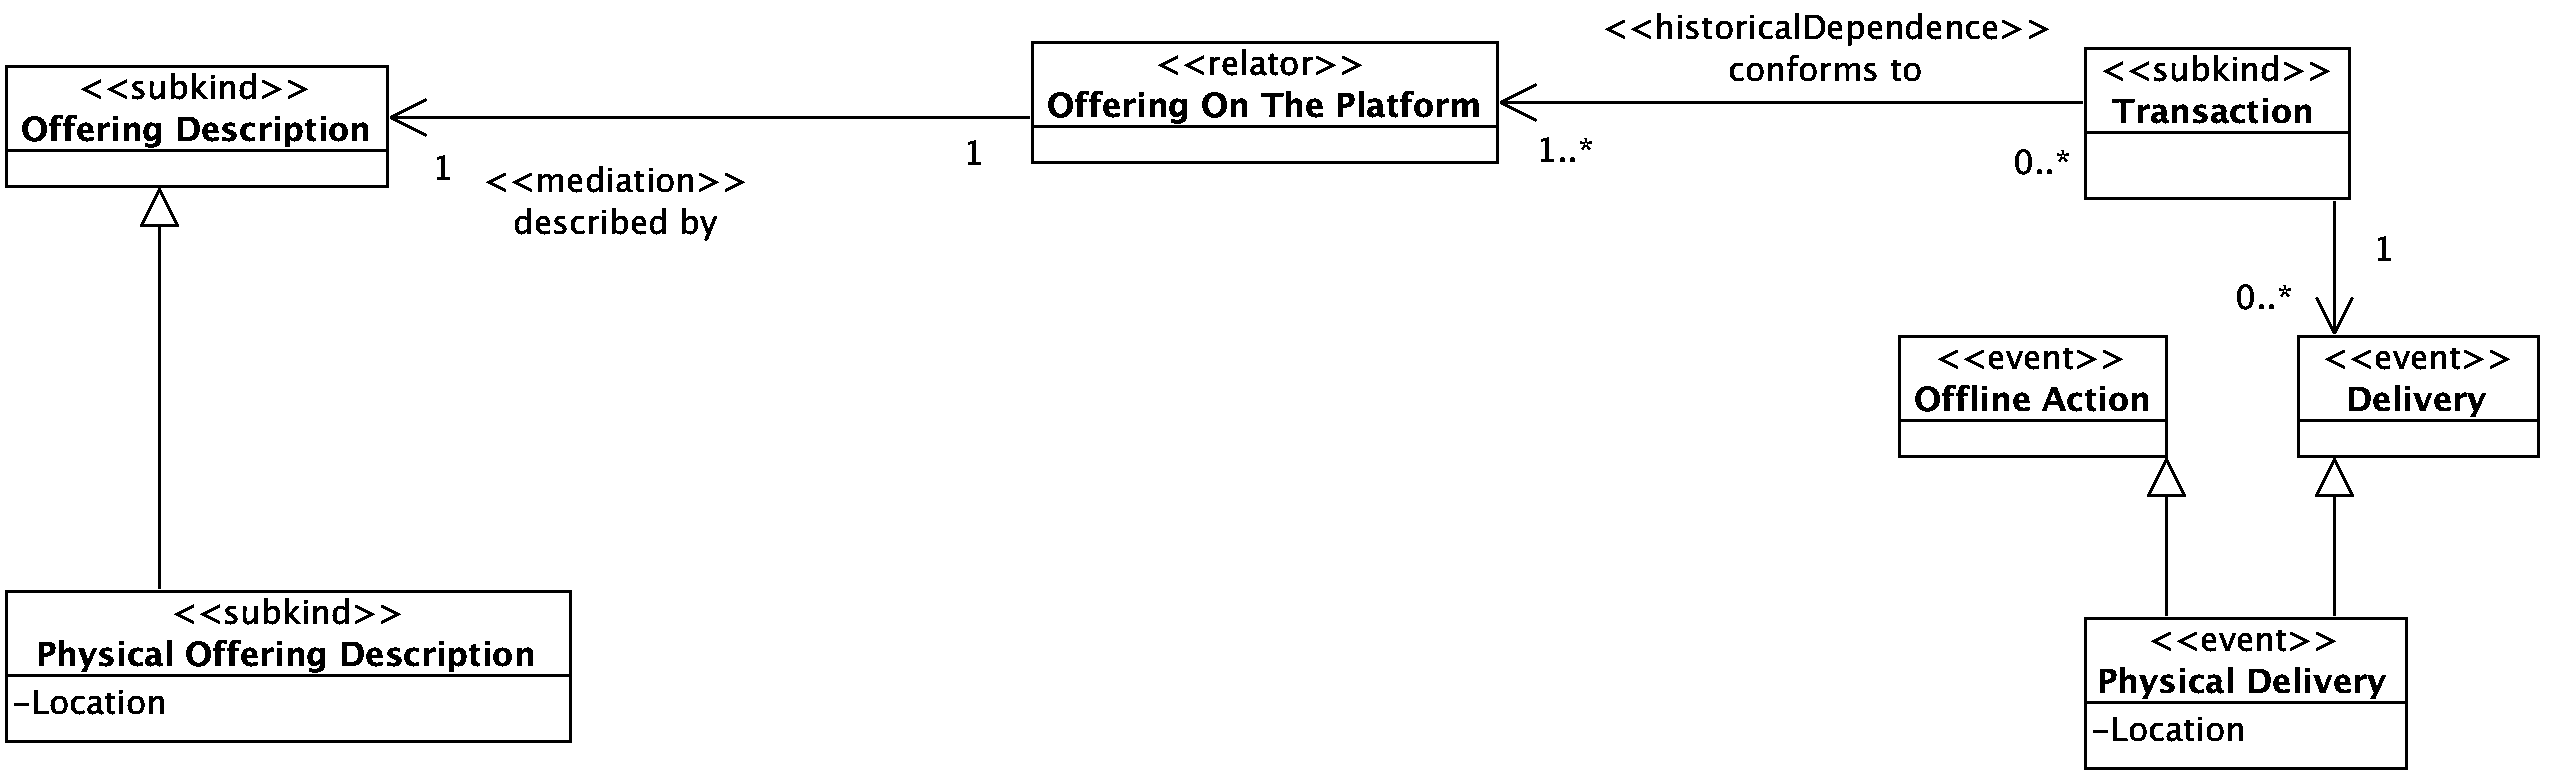

In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pytesseract
from pytesseract import Output
from google.colab import drive


def get_img_processed(img_path):
  # Load the image
  image = cv2.imread(img_path)

  # Convert the image to grayscale
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  cv2_imshow(gray_image)
  # Apply Gaussian blur for sharpening
  blurred = cv2.GaussianBlur(gray_image, (0, 0), sigmaX=3, sigmaY=3)
  sharpened = cv2.addWeighted(gray_image, 1.5, blurred, -0.5, 0)

  # Display the sharpened image
  cv2_imshow(sharpened)
  # Define the kernel for erosion and dilation
  kernel = np.ones((3, 3), np.uint8)

  # Perform erosion followed by dilation - they say they do it in the paper but
  # its commented out in their code and it didnt really do good for me.
  eroded = cv2.erode(sharpened, kernel, iterations=1)
  dilated = cv2.dilate(eroded, kernel, iterations=1)
  cv2_imshow(dilated)


  laplacian = cv2.Laplacian(sharpened, cv2.CV_64F)
  cv2_imshow(laplacian)
  _, thresholded = cv2.threshold(laplacian, 128, 255, cv2.THRESH_BINARY)
  cv2_imshow(thresholded)


  #Perform threshold conversion(every pixel with value < 150 goes whire, the rest black)
  _, binary_image = cv2.threshold(sharpened, 150, 255, cv2.THRESH_BINARY)


  # Display the final image
  cv2_imshow(binary_image)

  return sharpened, binary_image

image_path = 'offline.png'
diagram_name = image_path.replace(".png", "")

processed_img, binary_img = get_img_processed(image_path)
clean_img = cv2.imread(image_path)


# Rectangle check
Check if rectangle has similar sides, similar diagonals, and approx 90 degree agngles

In [3]:
def make_points_arr(approx_curve):
  points = []

  for p in approx_curve:
    points.append([p[0][0], p[0][1]])
  return np.array(points)

def is_approx_rectangle(approx_curve, tol=35):
    """
    Check if the given set of points forms an approximate rectangle.

    Parameters:
    points (numpy array): Array of shape (4, 2) containing the points.
    tol (float): Tolerance for angle approximation in degrees.

    Returns:
    bool: True if the points form an approximate rectangle, False otherwise.
    """
    points = make_points_arr(approx_curve)
    # Ensure points are sorted by their x and y coordinates to maintain correct order
    points = points[np.lexsort((points[:, 1], points[:, 0]))]

    # Function to calculate Euclidean distance
    def distance(p1, p2):
        return np.linalg.norm(p1 - p2)

    # Calculate distances between consecutive points
    d1 = distance(points[0], points[1])
    d2 = distance(points[1], points[2])
    d3 = distance(points[2], points[3])
    d4 = distance(points[3], points[0])

    #print(f"d1 {d1} d2 {d2} d3 {d3} d4 {d4}")

    # Calculate diagonal distances
    diag1 = distance(points[0], points[2])
    diag2 = distance(points[1], points[3])

    # Check if opposite sides are approximately equal
    sides_equal = np.isclose(d1, d3, 10.0) and np.isclose(d2, d4, 10.0)

    # Check if diagonals are approximately equal
    diagonals_equal = np.isclose(diag1, diag2, 15.0)

    # Function to calculate angle between three points (p1 -> p2 -> p3)
    def angle(p1, p2, p3):
        v1 = p1 - p2
        v2 = p3 - p2
        cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        angle = np.arccos(cosine_angle)
        return np.degrees(angle)

    # Calculate angles at each corner
    angle1 = angle(points[0], points[1], points[2])
    angle2 = angle(points[1], points[2], points[3])
    angle3 = angle(points[2], points[3], points[0])
    angle4 = angle(points[3], points[0], points[1])

    # Check if all angles are approximately 90 degrees
    angles_90 = all(np.isclose(angle, 90, atol=tol) for angle in [angle1, angle2, angle3, angle4])

    #print(f"sides equal : {sides_equal}")
    #print(f"diags equal : {diagonals_equal}")
    #print(f"angles 90 : {angles_90}")

    # Final check for rectangle
    return sides_equal and diagonals_equal and angles_90





# Rectangle detection
Detect rectangles and filter on size

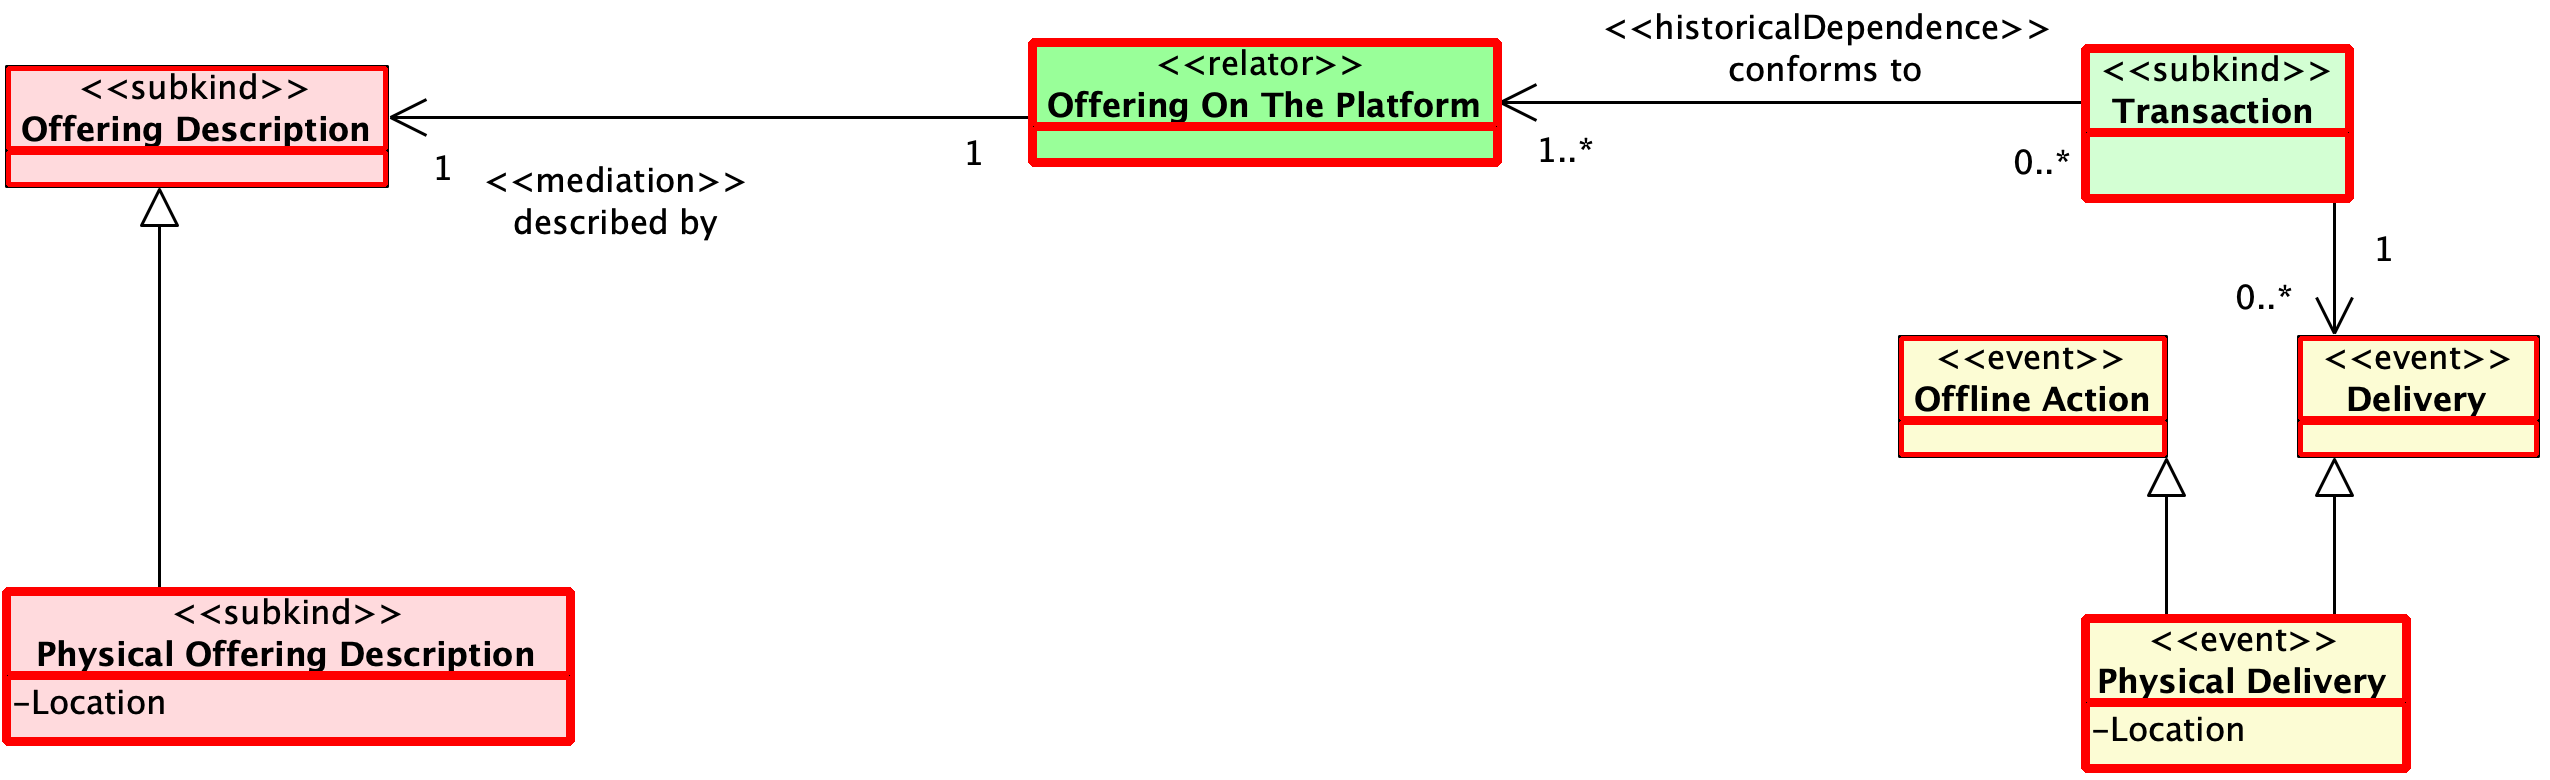

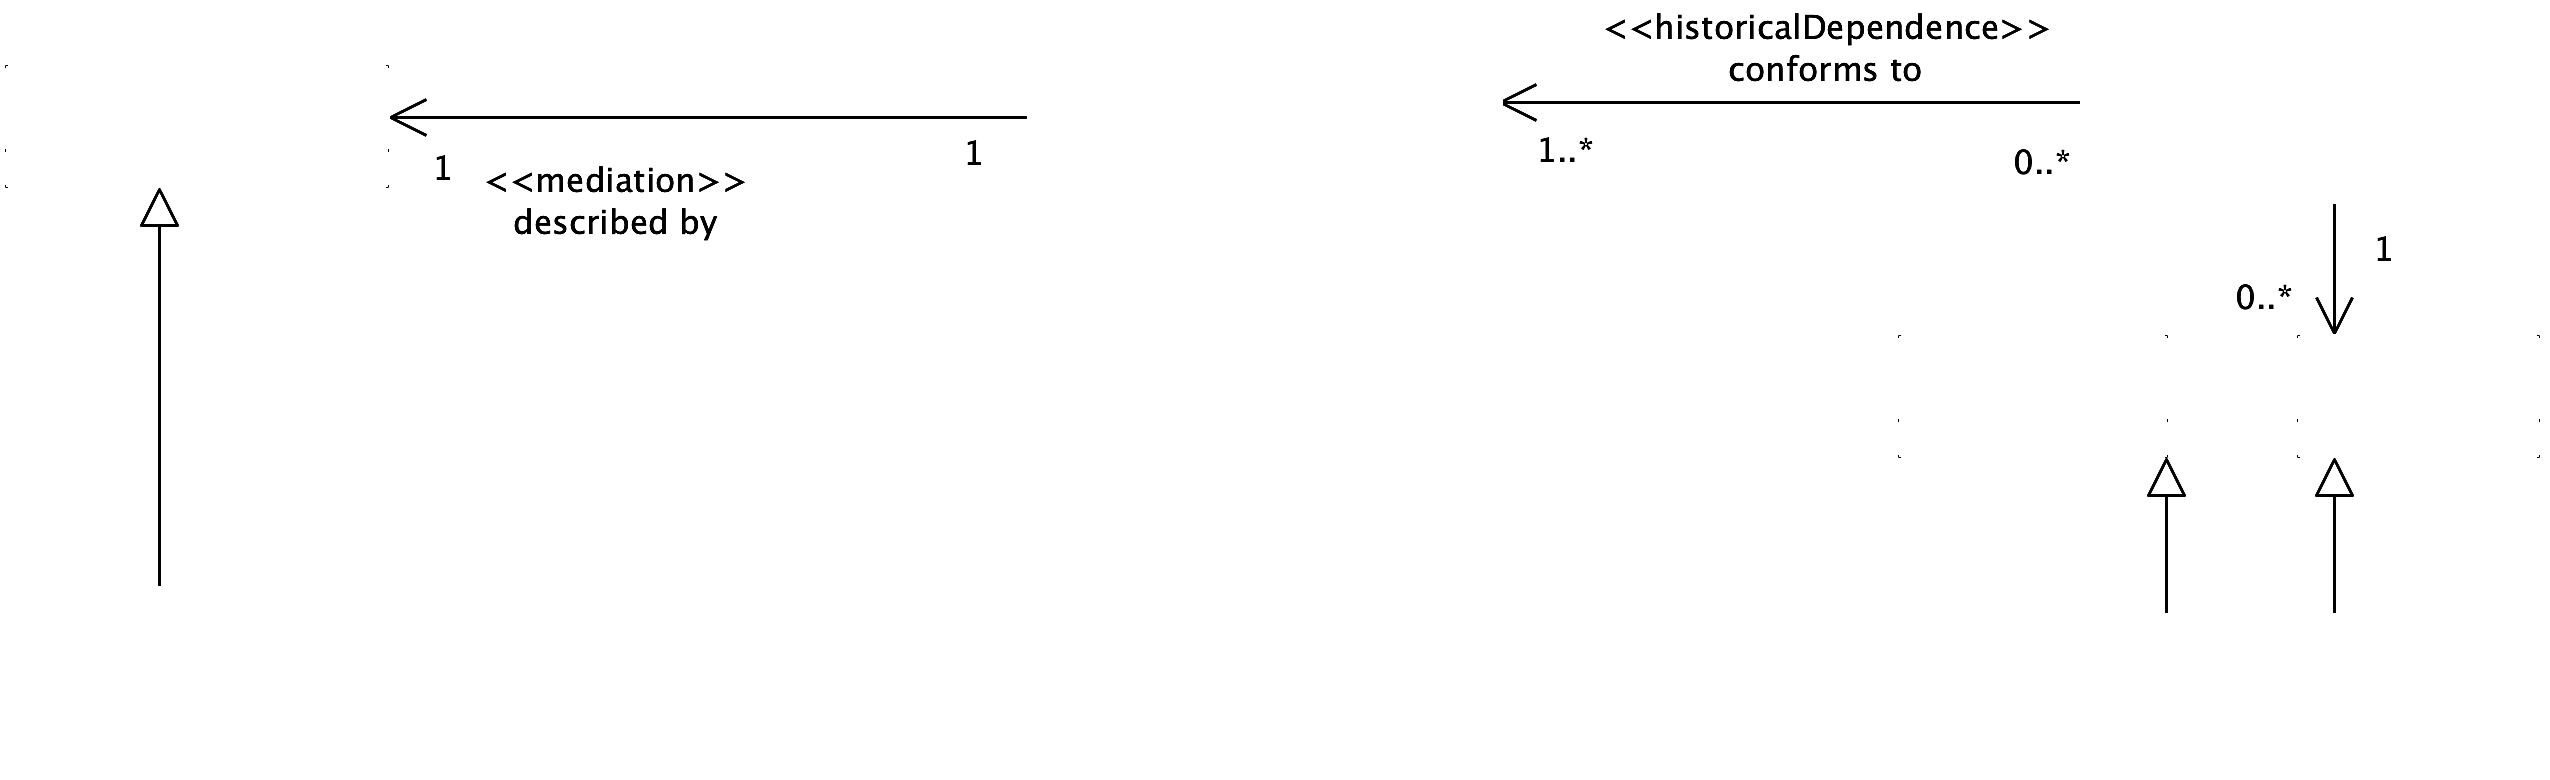

Detected 18 rectangles


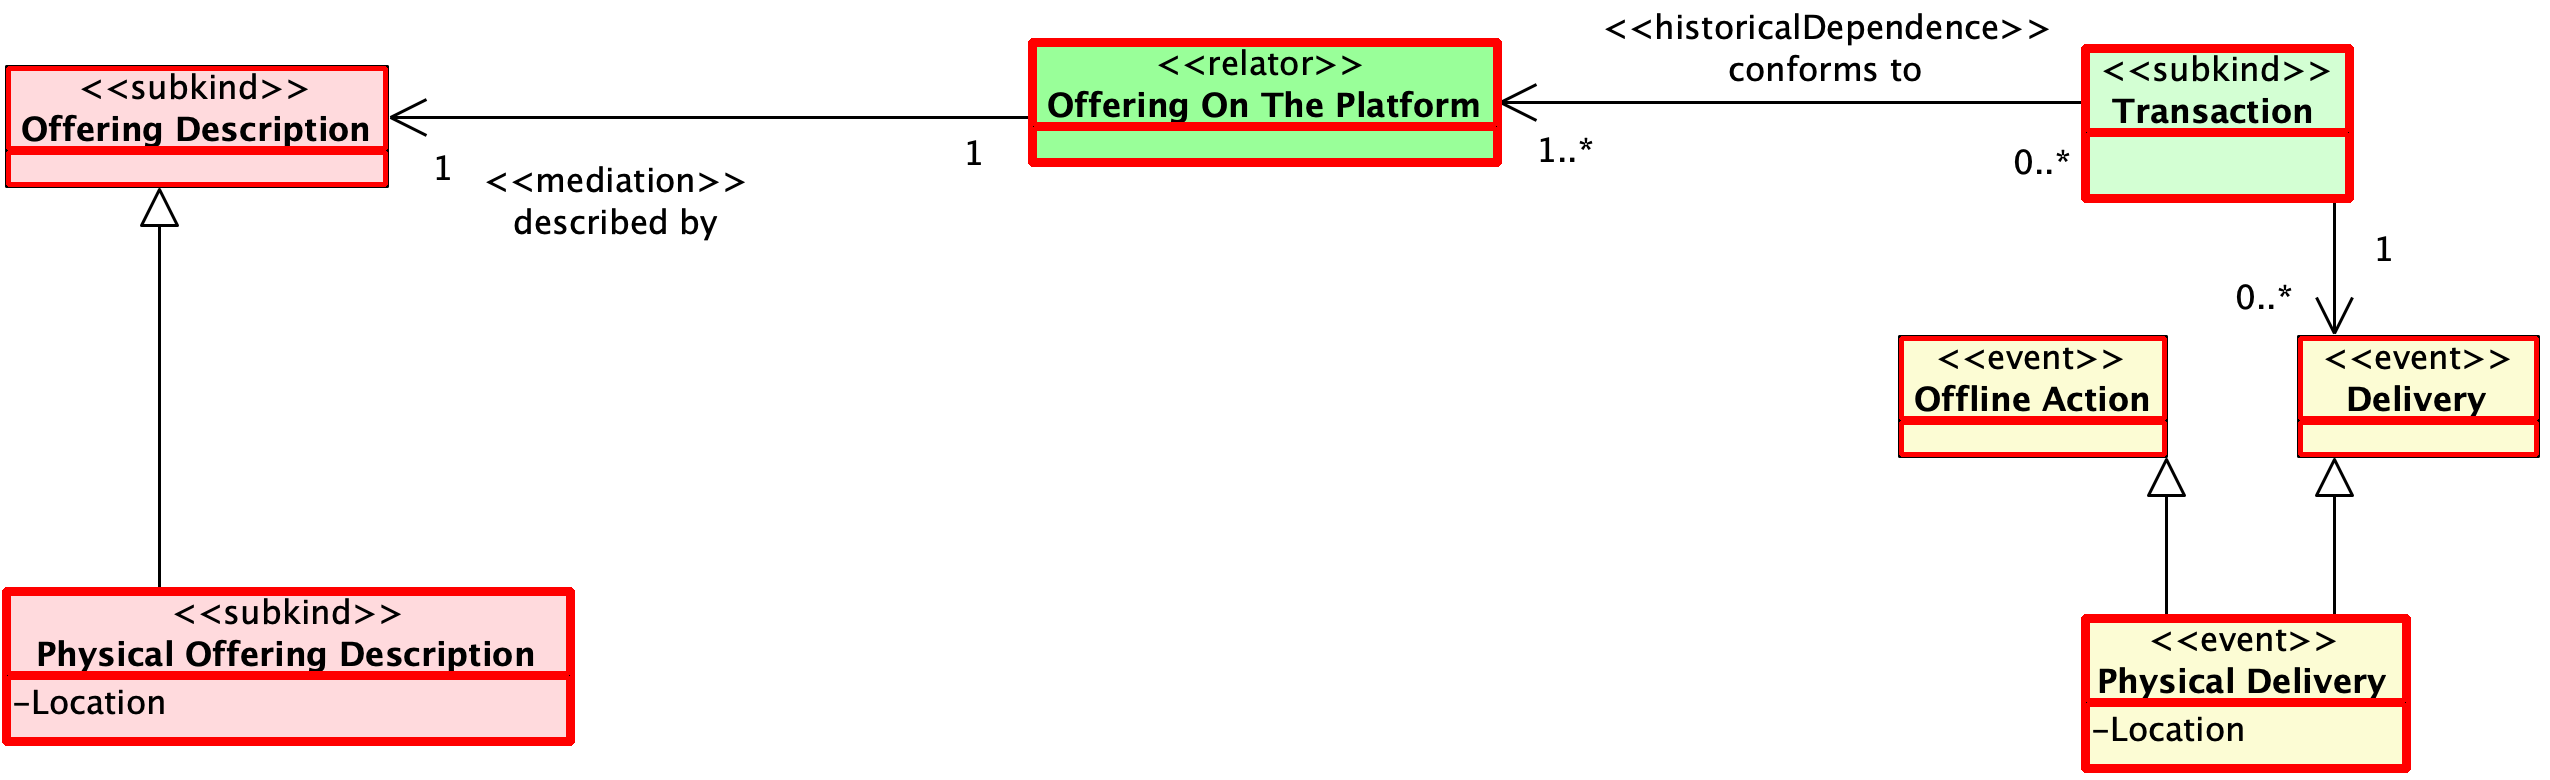

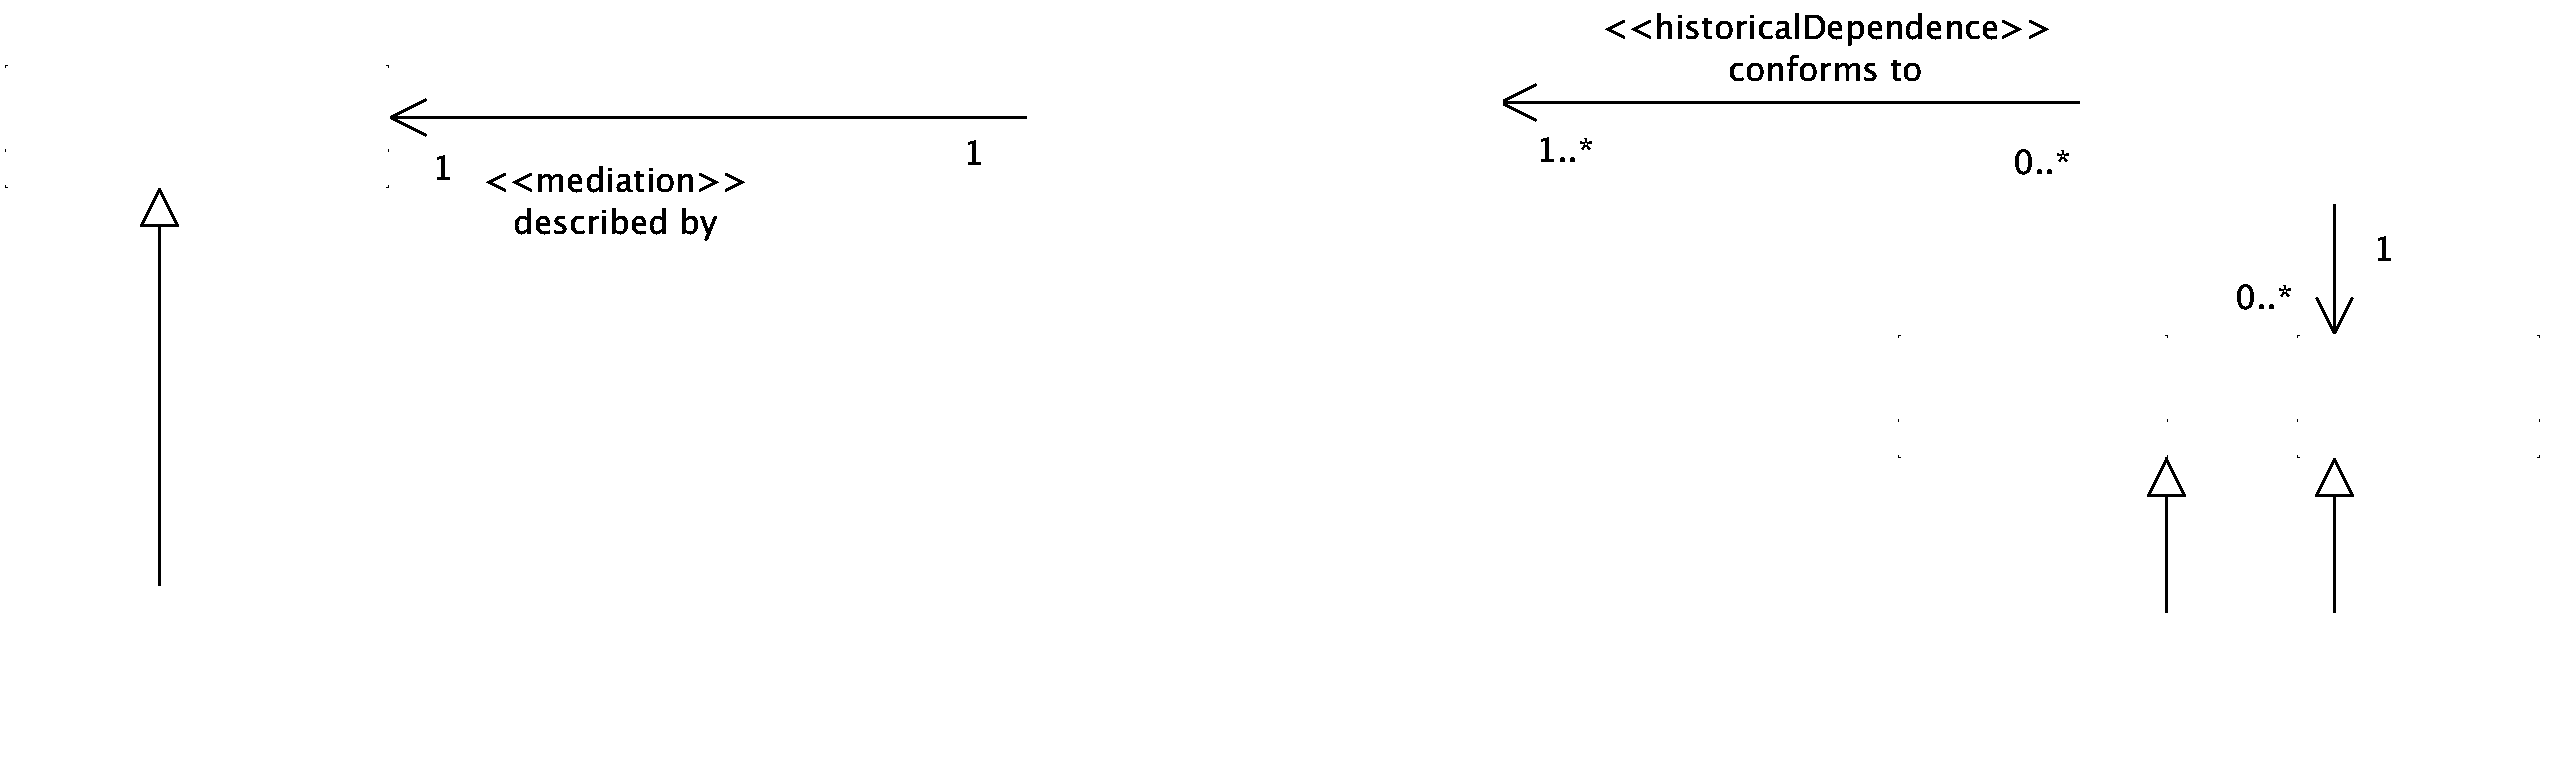

Detected 18 rectangles


In [4]:

class Rectangle:
    def __init__(self, image=None, contour=None, approx_curve=None, x=0, y=0, width=0, height=0):
        self.image = image
        self.contour = contour
        self.approx_curve = approx_curve
        self.within_cls_obj = False

        # Calculate the bounding box from the approx_curve
        if approx_curve is not None:
            x, y, w, h = cv2.boundingRect(approx_curve)
            self.x = x
            self.y = y
            self.width = w
            self.height = h
        else:
          self.x = x
          self.y = y
          self.width = width
          self.height = height

    def tl(self):
        return (self.x, self.y)

    def br(self):
        return (self.x + self.width, self.y + self.height)

    def clone(self):
        return Rectangle(self.image, self.contour, self.approx_curve)
    def print_rectangle(self):
      print(f"approx_curve: {self.approx_curve}")
      print(f"x: {self.x}")
      print(f"y: {self.y}")
      print(f"width: {self.width}")
      print(f"height: {self.height}")
      print(f"within_class: {self.within_cls_obj}")

    def contains(self, point):
        return (self.x <= point[0] <= self.x + self.width) and (self.y <= point[1] <= self.y + self.height)



def detect_rectangles(original_img, image_path):
    img = original_img.copy()
    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    all_rect_areas = []
    rect_contours = []

    # Calculate area thresholds
    cd_area = img.shape[0] * img.shape[1]
    min_cls_area = 60
    max_cls_area = cd_area * 0.5

    for contour in contours:
        # Calculate contour area
        contour_area = cv2.contourArea(contour)
        if contour_area < min_cls_area or contour_area > max_cls_area:
            continue
        # Approximate the contour to a polygon
        curve = np.array(contour, dtype=np.float32)
        approx_curve = cv2.approxPolyDP(curve, 0.01 * cv2.arcLength(curve, True), True)

        '''
        if len(approx_curve) == 4:
          image = cv2.imread(image_path)
          cv2.drawContours(image, [contour], -1, (0, 0, 255), 3)
          cv2_imshow(image)
        '''
        # If the approximation has 4 vertices, it is considered a rectangle
        if len(approx_curve) == 4 and is_approx_rectangle(approx_curve):
            #print("good")
            # Save the rectangle
            rect = Rectangle(img.copy(), contour, approx_curve)
            all_rect_areas.append(rect)
            rect_contours.append(contour)

            # Fill the rectangle to remove it from the image
            cv2.fillConvexPoly(img, contour, (255, 255, 255))


    # Display all the recognised rectangles
    image_all = cv2.imread(image_path)
    for contour in rect_contours:
      image = cv2.imread(image_path)
      cv2.drawContours(image, [contour], -1, (0, 0, 255), 3)
      cv2.drawContours(image_all, [contour], -1, (0, 0, 255), 3)
      #cv2_imshow(image)
    cv2_imshow(image_all)

    # Draw and wipe the rectangles
    cv2.drawContours(img, rect_contours, -1, (255, 255, 255), 5)

    # Display the result
    cv2_imshow(img)

    print(f"Detected {len(rect_contours)} rectangles")
    return img, all_rect_areas

# Example usage:
no_class_img, rectangles = detect_rectangles(processed_img, image_path)
no_class_img2, rectangles2 =  detect_rectangles(binary_img, image_path)
binary = False
# take whichever processing resulted in more rectangles detected
if len(rectangles2) > len(rectangles):
  rectangles, no_class_img = rectangles2, no_class_img2
  binary = True


# Rectangle clustering
Cluster class rectangles based on size and position

In [5]:
class UMLClass:
    def __init__(self):
        self.list = []
        self.top = None
        self.mid = None
        self.bottom = None
        self.temp_rect = None
        self.whole = None
        self.title = ""
        self.attris_str = ""
        self.methods_str = ""
        self.name = ""
        self.stereotype = ""
        self.id = ""

    def setTitle(self, title):
        self.title = title.strip()

    def setAttrisStr(self, attris_str):
        self.attris_str = attris_str.strip()

    def setMethodsStr(self, methods_str):
        self.methods_str = methods_str.strip()

    def setName(self, name_str):
        self.name = name_str

    def setStereotype(self, stereotype_str):
        self.stereotype = stereotype_str

    def setId(self, id):
        self.id = id


def merge_into_class(all_rect_areas_in_cd):
    result = []

    # Get all rectangles
    rect_area_list = all_rect_areas_in_cd[1]

    for all_rect_index in range(len(rect_area_list)):
        current_rect = rect_area_list[all_rect_index]

        # If the current rect already belongs to a class, skip it
        if current_rect.within_cls_obj:
            continue

        # Otherwise, assign it to a new class
        uml_class = UMLClass()
        uml_class.list.append(current_rect)
        current_rect.within_cls_obj = True

        # This temp_rect is for updating the class's size
        uml_class.temp_rect = current_rect.clone()

        # Compare the temp_rect with other rects in all_rect_areas
        for j in range(all_rect_index + 1, len(rect_area_list)):
            other_rect = rect_area_list[j]

            # Check if the horizontal distance between left-tops is within 3-5 pixels
            if abs(other_rect.tl()[0] - uml_class.temp_rect.tl()[0]) <= 5:
                if uml_class.temp_rect.tl()[1] < other_rect.tl()[1]:
                    if other_rect.tl()[1] - uml_class.temp_rect.tl()[1] - uml_class.temp_rect.height <= 5:
                        uml_class.list.append(other_rect)
                        other_rect.within_cls_obj = True
                        uml_class.temp_rect.height += other_rect.height
                else:
                    if uml_class.temp_rect.tl()[1] - other_rect.tl()[1] - other_rect.height <= 5:
                        uml_class.list.append(other_rect)
                        other_rect.within_cls_obj = True
                        uml_class.temp_rect.x = other_rect.x
                        uml_class.temp_rect.y = other_rect.y
                        uml_class.temp_rect.height += other_rect.height

        # Sort the rects in the class into top, mid, and bottom
        uml_class.list.sort(key=lambda r: r.y)

        for j, r_in_l in enumerate(uml_class.list):
            if r_in_l is not None:
                if j == 0:
                    uml_class.top = r_in_l
                elif j == 1:
                    uml_class.mid = r_in_l
                elif j == 2:
                    uml_class.bottom = r_in_l

        # Adjust top, mid, bottom if necessary
        if uml_class.mid:
            if uml_class.bottom:
                if uml_class.top.y + uml_class.top.height >= uml_class.bottom.y + uml_class.bottom.height:
                    top_old_height = uml_class.top.height
                    uml_class.top = uml_class.mid.clone()
                    uml_class.mid = uml_class.bottom.clone()
                    uml_class.bottom.y = uml_class.top.y + uml_class.top.height + uml_class.mid.height
                    uml_class.bottom.height = top_old_height - uml_class.top.height - uml_class.mid.height
            else:
                if uml_class.top.y + uml_class.top.height >= uml_class.mid.y + uml_class.mid.height:
                    top_old_height = uml_class.top.height
                    uml_class.top = uml_class.mid.clone()
                    uml_class.mid.y = uml_class.top.y + uml_class.top.height
                    uml_class.mid.height = top_old_height - uml_class.top.height

        # Calculate the whole class's size
        whole_height = uml_class.top.height
        if uml_class.mid:
            whole_height += uml_class.mid.height
        if uml_class.bottom:
            whole_height += uml_class.bottom.height

        uml_class.whole = Rectangle(None, None, None, uml_class.top.x, uml_class.top.y, uml_class.top.width, whole_height)

        result.append(uml_class)

    return result


# Example usage:
all_rect_areas_in_cd = (processed_img, rectangles)
merged_classes = merge_into_class(all_rect_areas_in_cd)
print(len(merged_classes))

7


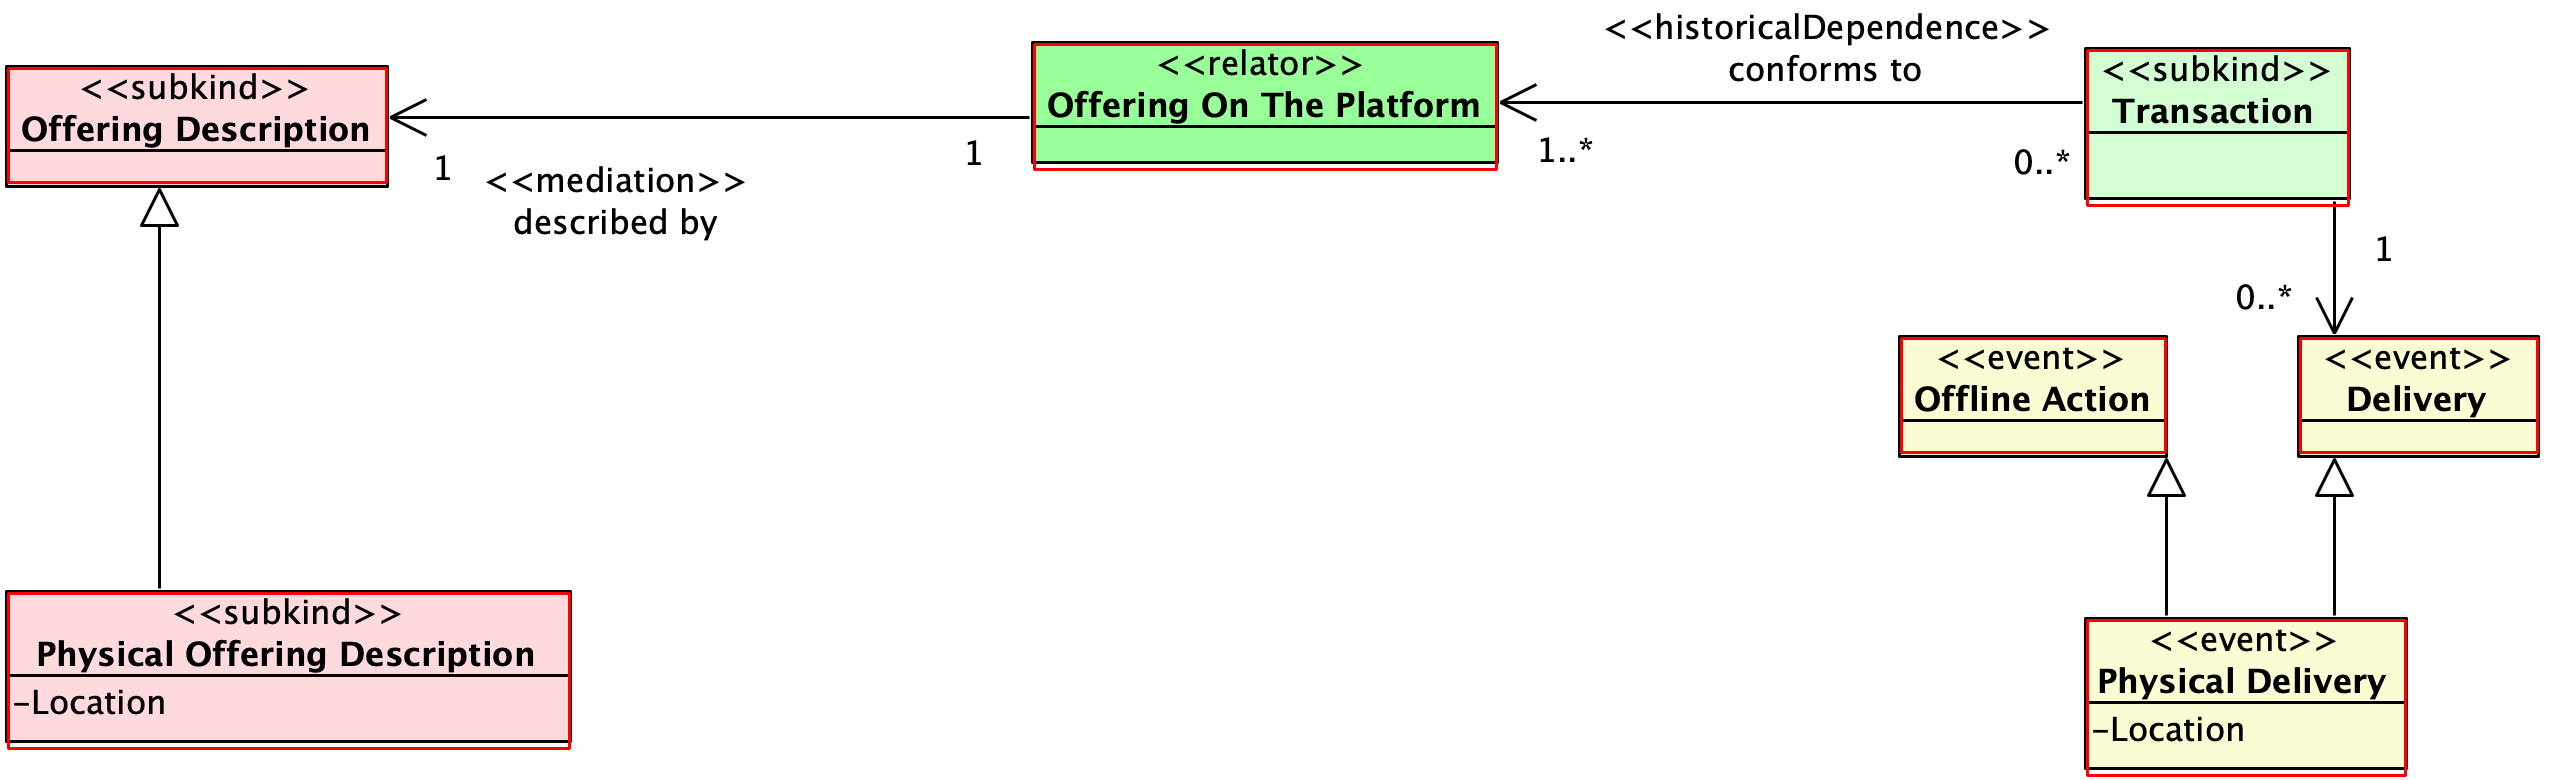

In [6]:
def draw_rectangles(image, rectangles):
    # Copy the image to draw rectangles on it
    output_image = cv2.imread(image_path)

    # Loop over each rectangle and draw it on the image
    for rect_obj in rectangles:
        rect = rect_obj.whole
        # Draw the rectangle
        cv2.rectangle(output_image, rect.tl(), rect.br(), (0, 0, 255), 2)


    # Display the image with rectangles
    cv2_imshow(output_image)
draw_rectangles(processed_img, merged_classes)







In [23]:
# TODO uncomment to install ai upscale lib
#!pip install waifu2x-ncnn-py
# Run this if you're using linux
#!apt install -y libomp5 libvulkan-dev



# Text recognition
Cut out the top rectangle and apply OCR

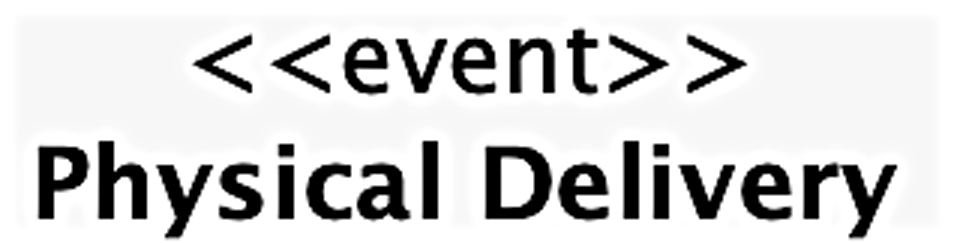

<<event>>
Physical Delivery





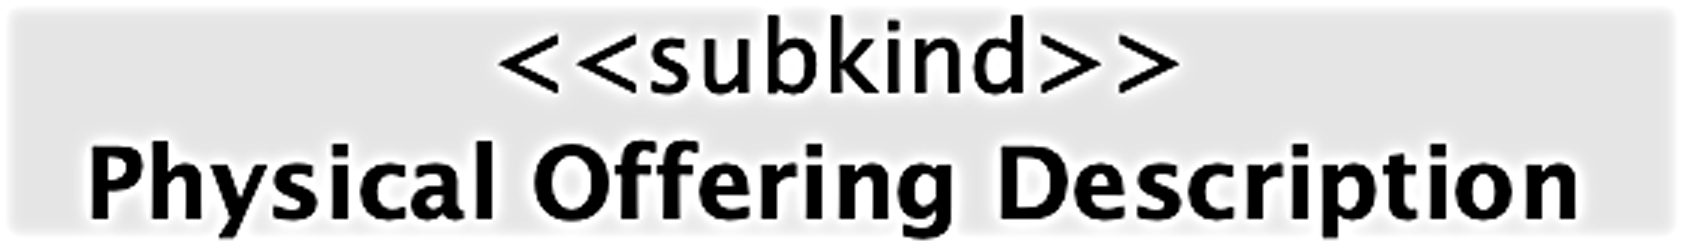

<<subkind>>
Physical Offering Description





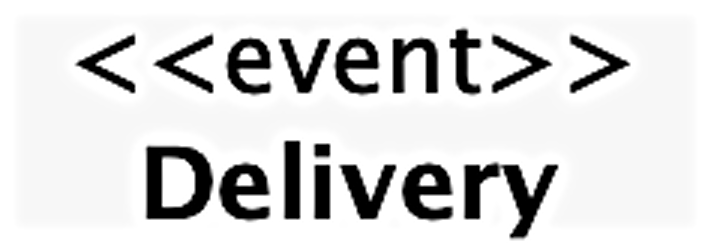

<<event>>
Delivery





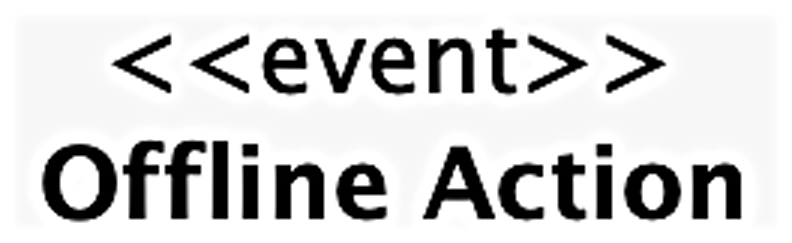

<<event>>
Offline Action





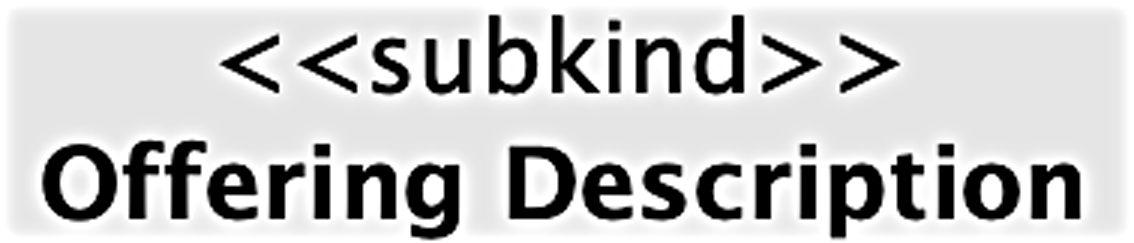

<<subkind>>
Offering Description





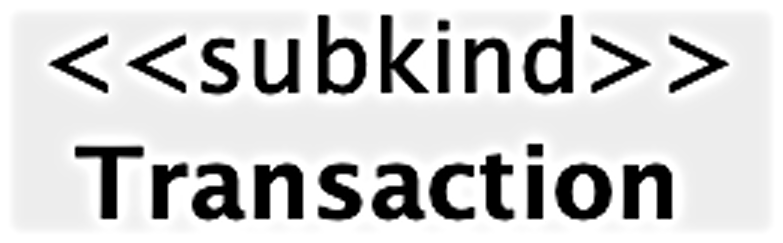

<<subkind>>
Transaction





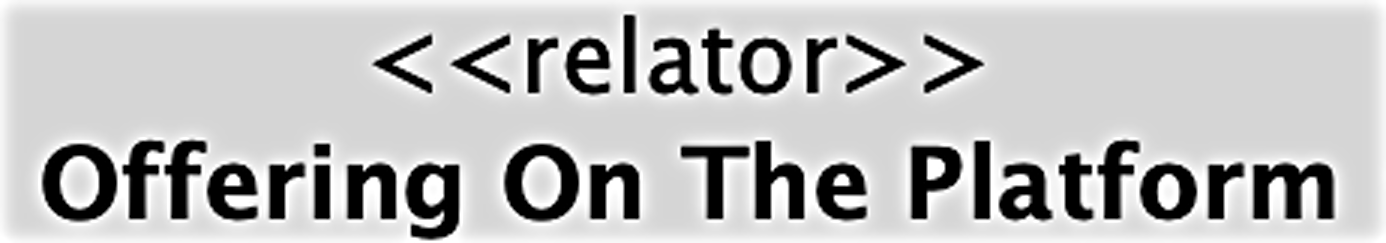

<<relator>>
Offering On The Platform





In [7]:
#not used because worse performance than just resizing to 2x
#from waifu2x_ncnn_py import Waifu2x
#waifu2x = Waifu2x(-1, False, 1, 3, 2, 0, "models-cunet")
#def upscale_img(image):
  #image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  #ai_processed_image = waifu2x.process_cv2(image)
  #cv2_imshow(ai_processed_image)
  #return ai_processed_image

def cutImage(image, rect):
    return image[rect.y:rect.y + rect.height, rect.x:rect.x + rect.width]

# TODO maybe make it so you can select the language
def detectText(cls_diagram, classes):

    for uc in classes:
        try:
            # Process the top region
            if uc.top is not None:
                img = cutImage(cls_diagram, uc.top)
                #increse image size
                img = cv2.resize(img, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
                if img.size > 0:
                    cv2_imshow(img)
                    img_string = pytesseract.image_to_string(img)
                    uc.setTitle(img_string)
                    print(img_string)
                    print("\n")

            # Process the mid region
            if uc.mid is not None:
                img = cutImage(cls_diagram, uc.mid)

                if img.size > 0:
                    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    uc.setAttrisStr(pytesseract.image_to_string(img, lang='eng'))

            # Process the bottom region
            if uc.bottom is not None:
                if uc.bottom.y > uc.whole.y:
                    uc.bottom.y = uc.whole.y

                img = cutImage(cls_diagram, uc.bottom)
                if img.size > 0:
                    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    uc.setMethodsStr(pytesseract.image_to_string(img, lang='eng'))

        except Exception as e:
            print(f"Error processing class {uc}: {e}")

    return classes

# Example usage
classes = detectText(processed_img, merged_classes)
# for uml_class in classes:
#   print(uml_class.title)
#   print("\n\n")

# Process Text
Extract the stereotyoe and class name

In [8]:
import re


def process_class_text(text):
  # Replace special characters
  text = text.replace("«", "<<")
  text = text.replace("< <", "<<")
  text = text.replace("»", ">>")
  text = text.replace("::", ":")
  # Shouldn't have more than 1 stereotype
  if text.count("<<") > 1:
    return ""

  lines = text.split('\n')
  if not lines:
        return text

  # Check if the second line includes '<<' or '<'
  if len(lines) > 1 and ('>>' in lines[1] or '>' in lines[1]):
      # Combine the first and second lines
      lines[0] = lines[0] + ' ' + lines[1]
      # Remove the second line from the list
      lines.pop(1)
  first_line = lines[0]

  # Check if the first line contains '<<' and does not contain '>>'
  if '<<' in first_line and '>>' not in first_line:
      # Check if the last character of the first line is 's'
      if first_line.endswith('s'):
          # Replace the last 's' with '>>'
          first_line = first_line[:-1] + '>>'
      elif first_line.endswith('>s'):
          # Replace the last 's' with '>>'
          first_line = first_line[:-1] + '>'
      elif first_line.endswith('> >'):
          # Replace the last 's' with '>>'
          first_line = first_line[:-2] + '>'

  # Update the first line in the list of lines
  lines[0] = first_line

  # Join the lines back into a single string
  return '\n'.join(lines)


def extract_class_info(text):
  text = process_class_text(text)
  # Extract the stereotype
  pattern = r"<<(.*?)>>"
  match = re.search(pattern, text)
  if match:
    stereotype = match.group(1)
  else:
    print("No stereotype found")
    stereotype = ""

  # Extract the class name
  if(stereotype != ""):
    # Split the input string into lines and ignore the first line containing <<>>
    lines = text.split('\n')[1:]
    text = '\n'.join(lines).strip()
  # Remove new lines
  text = text.replace('\n', ' ')
  # Step 3: Split the remaining text based on the colon, to remove package name
  parts = text.split(':')
  if len(parts) > 1:
      before_colon = parts[0].strip()
      after_colon = parts[1].strip()
      return stereotype, after_colon
  else:
      before_colon = text.strip()
      return stereotype, before_colon

classes_to_remove = []
for uml_class in classes:
  stereotype, class_name = extract_class_info(uml_class.title)
  if class_name == "" and stereotype == "":
    classes_to_remove.append(uml_class)
  else:
    uml_class.setName(class_name)
    uml_class.setStereotype(stereotype)
    # TODO check for OntoUML specific stereotypes
    print(f"class: {class_name}, stereotype: {stereotype}")
#Remove classes from classes_to_remove
for cls in classes_to_remove:
  classes.remove(cls)

class: Physical Delivery, stereotype: event
class: Physical Offering Description, stereotype: subkind
class: Delivery, stereotype: event
class: Offline Action, stereotype: event
class: Offering Description, stereotype: subkind
class: Transaction, stereotype: subkind
class: Offering On The Platform, stereotype: relator


# Filter stereotypes
Check if stereotypes are OntoUML

In [9]:

import Levenshtein

# List of OntoUML class stereotypes
terms = [
    "abstract", "category", "collective", "datatype", "enumeration",
    "event", "historicalRole", "historicalRoleMixin", "kind", "mixin",
    "mode", "phase", "phaseMixin", "quality", "quantity", "relator",
    "role", "roleMixin", "situation", "subkind", "type", "powertype",
    "highordertype", "hou", "universal", "2ndOT", "relatorKind", "modeKind",
    "quantityKind", "collectiveKind", "qualityKind"
]




terms_old = ["powertype", "highordertype", "hou", "universal",
             "2ndOT", "relatorKind", "modeKind", "quantityKind",
             "collectiveKind", "qualityKind"]
terms_new = ["type","type","type","type","type","relator", "mode",
             "quantity", "collective", "quality"]

# Update old OntoUML stereotypes to the corresponding new ones
def update_stereotype(stereotype):
    if stereotype in terms_old:
        index = terms_old.index(stereotype)
        return terms_new[index]
    else:
        return stereotype


def check_stereotypes(classes):
  num_ontouml_stereotypes = 0
  for cls in classes:
    #get stereotype
    stereotype = cls.stereotype
    #get the distance to the closest ontouml stereotype
    similarities = [(term, Levenshtein.distance(stereotype, term)) for term in terms]
    # Find the term with the minimum distance
    most_similar_term, min_distance = min(similarities, key=lambda x: x[1])
    #if distance <=2 save it and up num_ontouml_stereotypes
    if min_distance <= 2:
      num_ontouml_stereotypes += 1
      stereotype_new = update_stereotype(most_similar_term)
      cls.stereotype = stereotype_new
  return num_ontouml_stereotypes


# Example usage
ontouml_stereotypes = check_stereotypes(classes)
print(f"There are {ontouml_stereotypes} OntoUML stereotypes in the model")

#TODO if 0 its not an OntoUML model, so stop

There are 7 OntoUML stereotypes in the model


In [10]:
print(len(classes))

7


# Cut out class rectangles

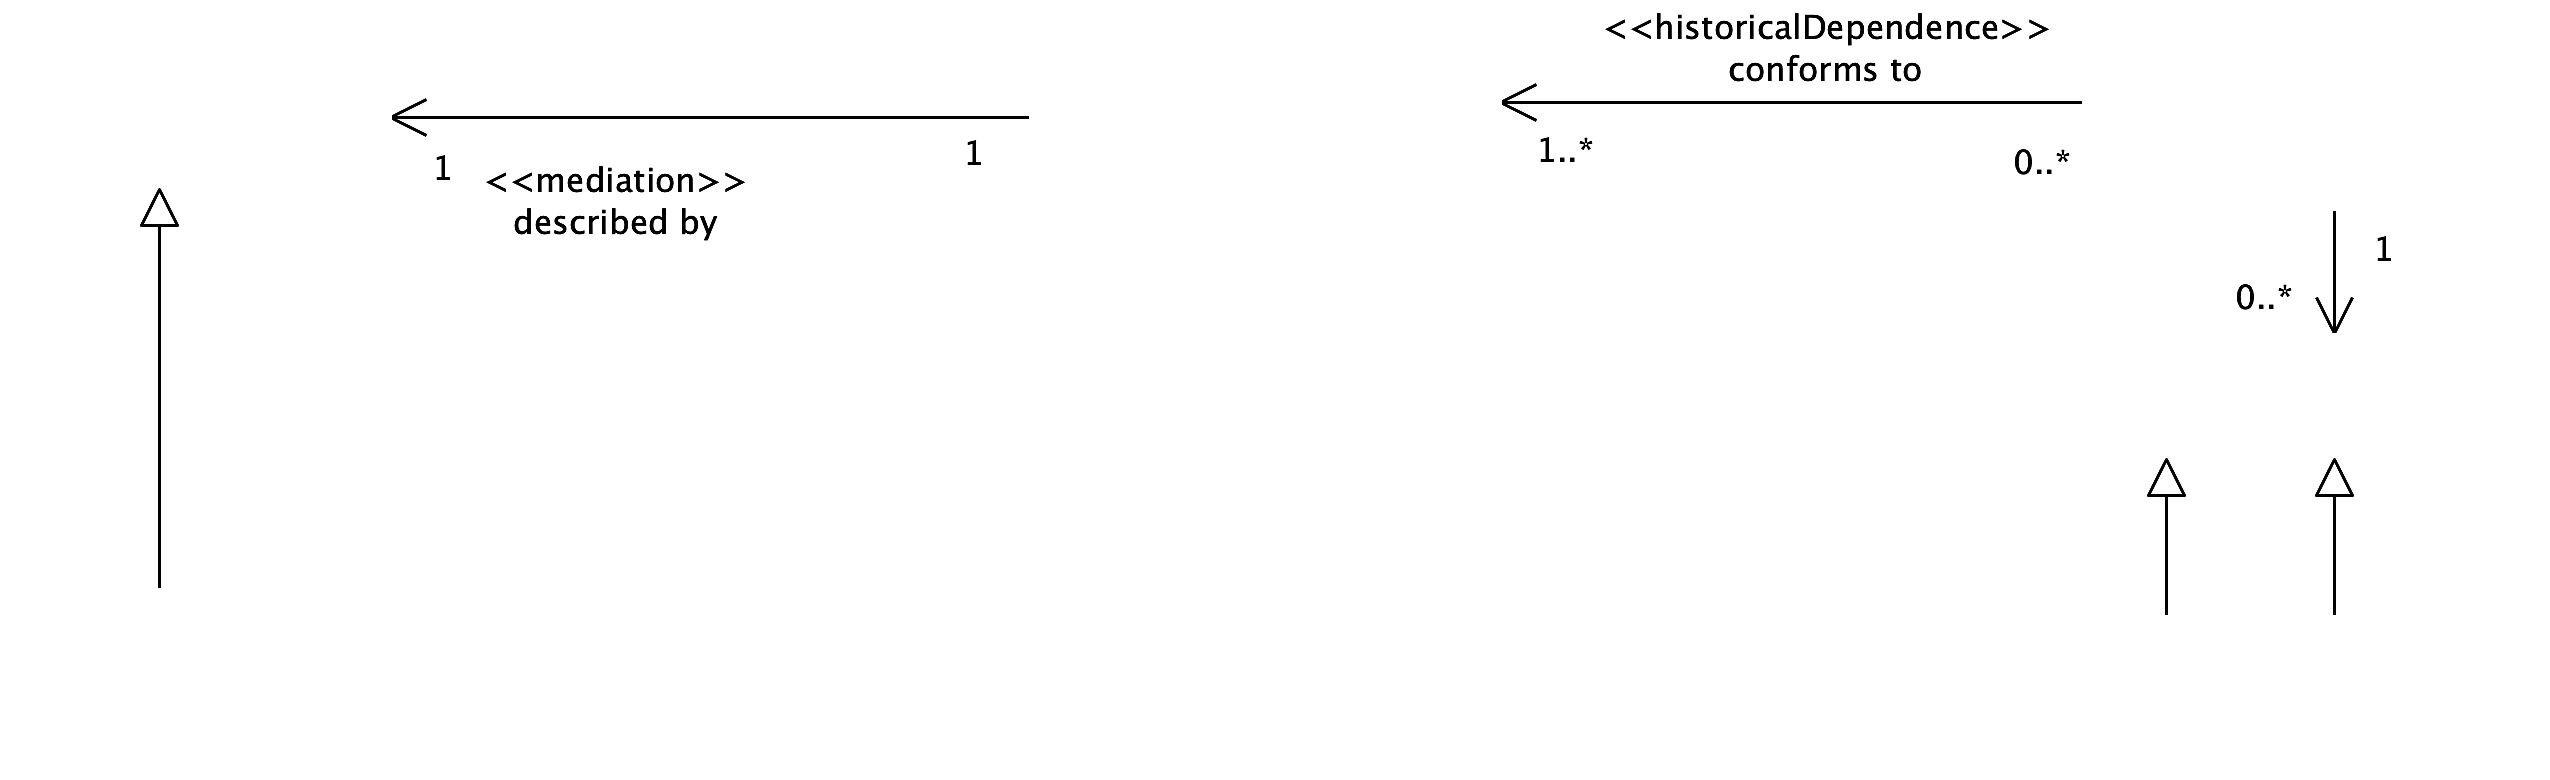

In [11]:
def wipe_classes(img, classes):
  no_class_img = img.copy()
  for c in classes:
    #TODO get the contour of the whole rectangle of the class
    contour = []
    cv2.rectangle(no_class_img, (c.whole.x - 5 , c.whole.y - 5), (c.whole.x + c.whole.width + 5, c.whole.y + c.whole.height + 5), (255,255,255), -1)
    # Fill the rectangle to remove it from the image
    #cv2.fillConvexPoly(img, contour, (255, 255, 255))
  return no_class_img

if binary:
  no_class_img2 = wipe_classes(binary_img, classes)
else:
  no_class_img2 = wipe_classes(processed_img, classes)
cv2_imshow(no_class_img2)


# Detect remaining shapes
Apply contour detection to detect the remaining shapes

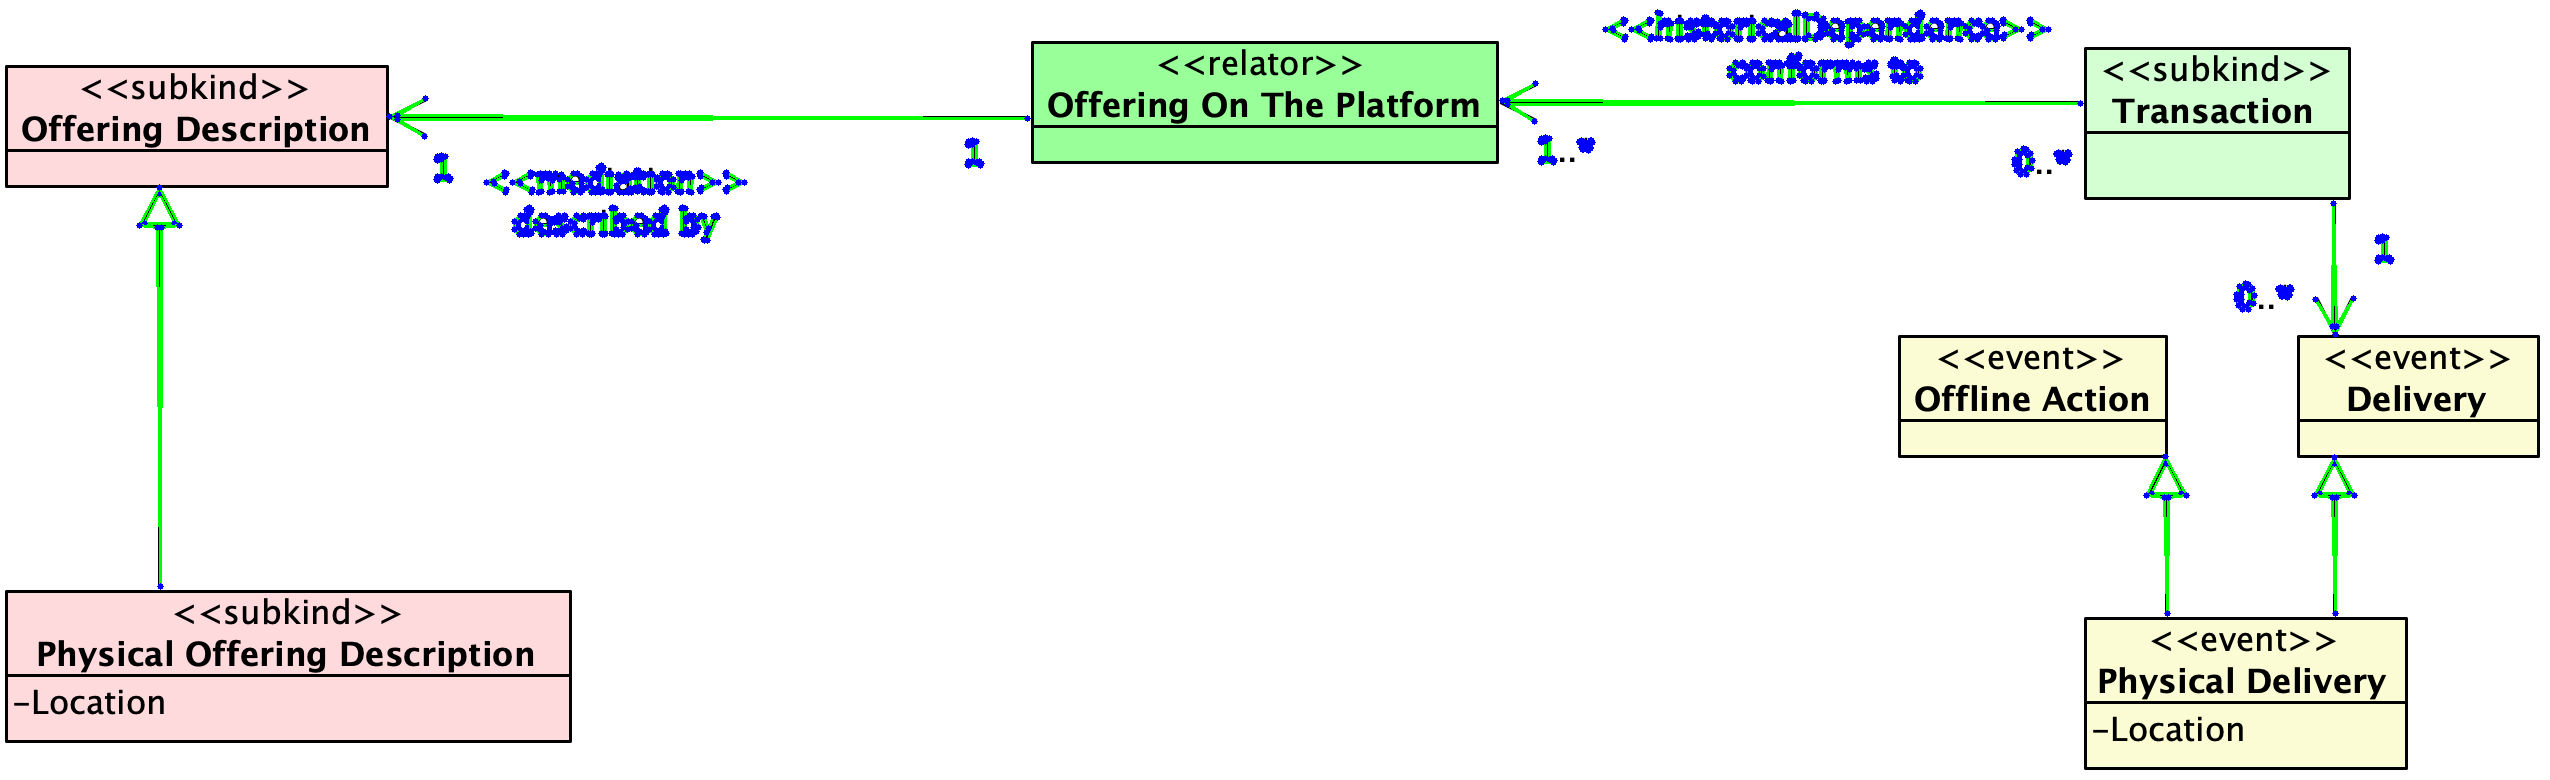

In [12]:
def detect_relations(original_img, image_path):
    img = original_img.copy()
    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    relations = []

    # Calculate area thresholds
    cd_area = img.shape[0] * img.shape[1]
    min_cls_area = 60
    max_cls_area = cd_area * 0.5

    image_all =  cv2.imread(image_path)
    for contour in contours:
        # Calculate contour area
        contour_area = cv2.contourArea(contour)
        if contour_area < min_cls_area or contour_area > max_cls_area:
            continue

        # Approximate the contour to a polygon
        curve = np.array(contour, dtype=np.float32)
        approx_curve = cv2.approxPolyDP(curve, 0.01 * cv2.arcLength(curve, True), True)

        image = cv2.imread(image_path)
        cv2.polylines(image_all, [approx_curve.astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.polylines(image, [approx_curve.astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)
        for point in approx_curve:
          cv2.circle(image_all, (int(point[0][0]), int(point[0][1])), 3, (255, 0, 0), -1)
          cv2.circle(image, (int(point[0][0]), int(point[0][1])), 3, (255, 0, 0), -1)
        #cv2_imshow(image)
        relations.append(approx_curve)
    cv2_imshow(image_all)
    return relations

relations = detect_relations(no_class_img, image_path)

# Relationship Detection
Determine which of the shapes connect classes

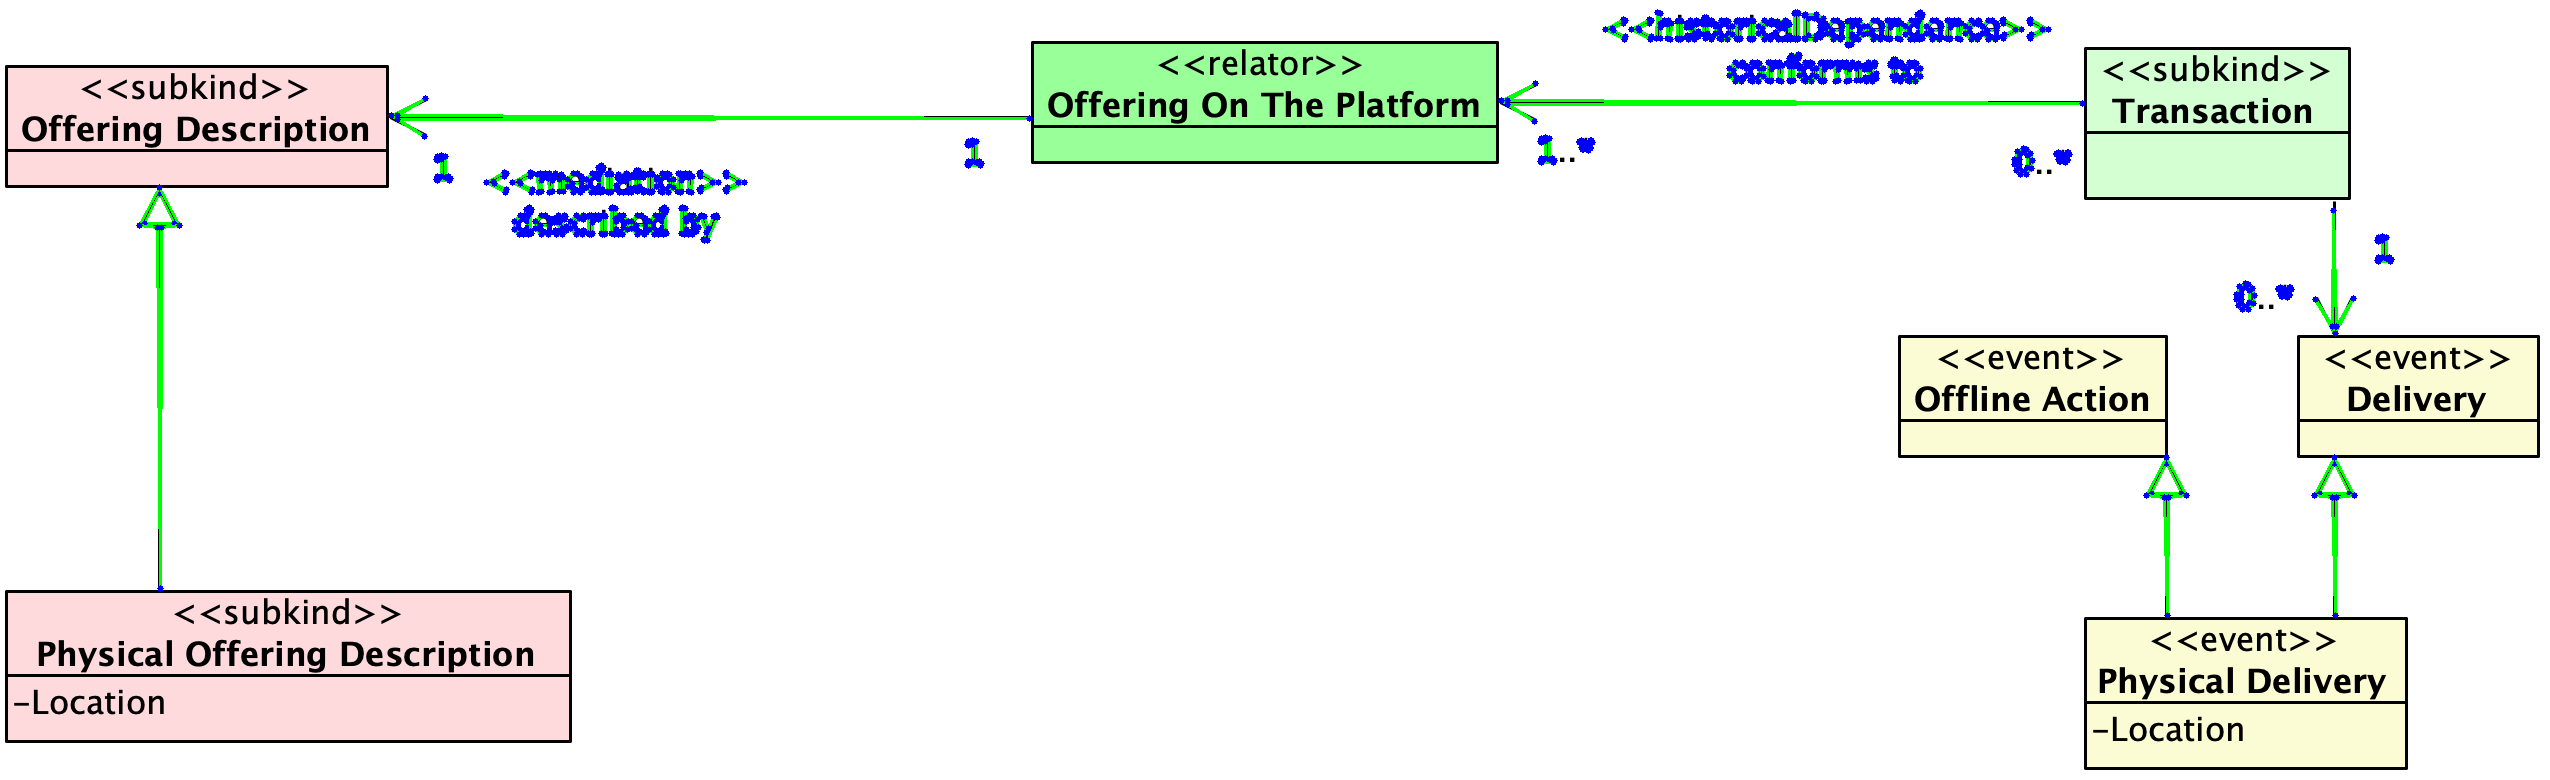

related classes:
Delivery
Physical Delivery


related classes:
Offline Action
Physical Delivery


related classes:
Transaction
Delivery


related classes:
Offering Description
Physical Offering Description


related classes:
Offering Description
Offering On The Platform


related classes:
Offering On The Platform
Transaction




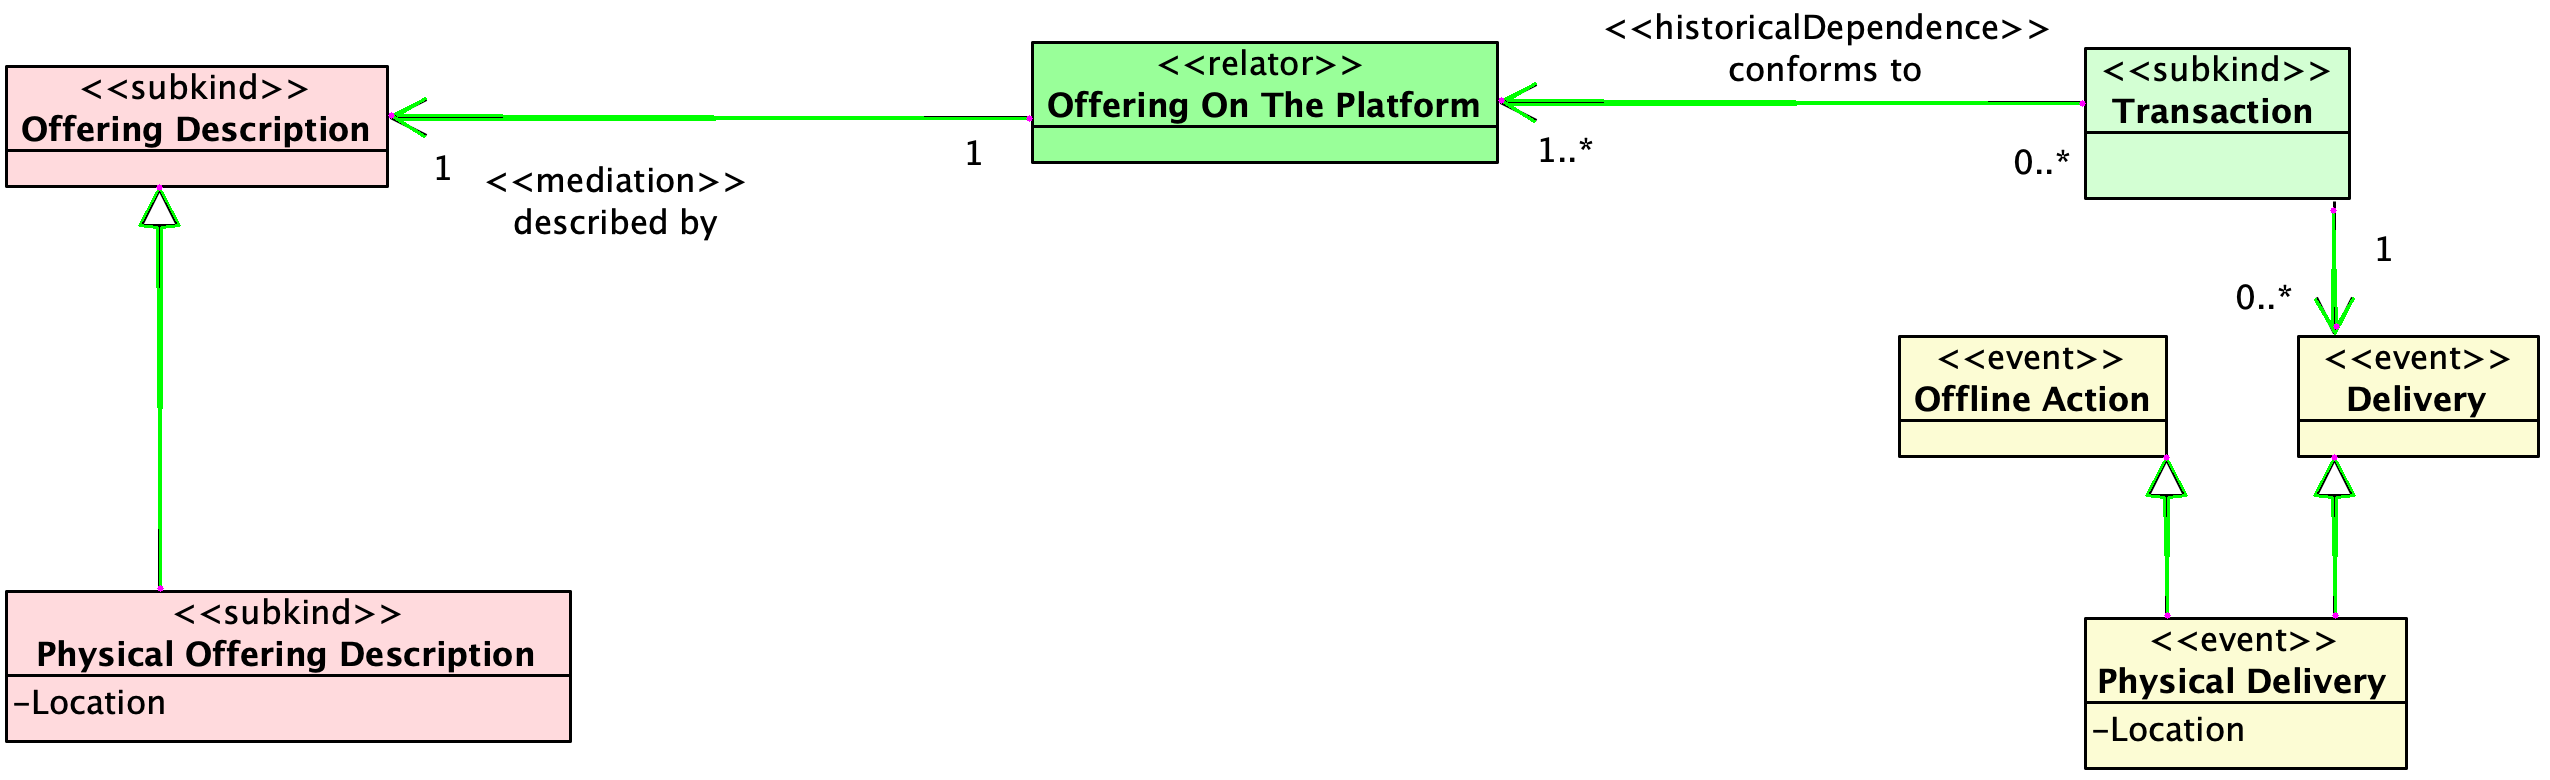

In [21]:
class Relation:
    def __init__(self, curve):
        self.classes = []
        self.endpoints = []
        self.curve = curve
        self.rel_type = ""
        self.source = -1

    def addClass(self, uml_class, endpoint):
        if uml_class not in self.classes:
          self.classes.append(uml_class)
          self.endpoints.append(endpoint)

    def set_type(self, rel_type, source = -1):
      self.rel_type = rel_type
      self.source = source

class_prox = 15 # TODO should be based on original image size

def get_relations(relations, classes):
  final_relations = []
  for relation in relations:
    new_relation = Relation(relation)
    related_classes = []
    points = []
    for p in relation:
      new_point = [p[0][0], p[0][1]]
      points.append(new_point)
    points = np.array(points)
    for point in points:
      point_up = [point[0], point[1]+ class_prox]
      point_ur = [point[0]+ class_prox, point[1]+ class_prox]
      point_ul = [point[0]+ class_prox, point[1]- class_prox]
      point_down = [point[0], point[1]- class_prox]
      point_dr = [point[0]- class_prox, point[1]+ class_prox]
      point_dl = [point[0]- class_prox, point[1]- class_prox]
      point_left = [point[0] - class_prox, point[1]]
      point_right = [point[0] + class_prox, point[1]]
      for uml_class in classes:
        if uml_class.whole.contains(point_up) or uml_class.whole.contains(point_down) or uml_class.whole.contains(point_left) or uml_class.whole.contains(point_right):
          related_classes.append(uml_class)
          new_relation.addClass(uml_class, point)
        if uml_class.whole.contains(point_ul) or uml_class.whole.contains(point_ur) or uml_class.whole.contains(point_dl) or uml_class.whole.contains(point_dr):
          related_classes.append(uml_class)
          new_relation.addClass(uml_class, point)
    # Only if it has > 1 class
    if len(new_relation.classes) >= 2:

      final_relations.append(new_relation)

  return final_relations


def printRelations(relations):

  image_all = cv2.imread(image_path)
  for rel in relations:
    image = cv2.imread(image_path)
    cv2.polylines(image, [rel.curve.astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)
    cv2.polylines(image_all, [rel.curve.astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)
    for ep in rel.endpoints:
      cv2.circle(image, (int(ep[0]), int(ep[1])), 3, (255, 0, 255), -1)
      cv2.circle(image_all, (int(ep[0]), int(ep[1])), 3, (255, 0, 255), -1)
    #cv2_imshow(image)
    print("related classes:")
    for rc in rel.classes:
      print(rc.name)
    print("\n")
  cv2_imshow(image_all)



def get_number_of_classes(class_relations):
  clss = 0
  for rel in class_relations:
    clss += len(rel.classes)
  return clss


relations2 = detect_relations(no_class_img2, image_path)
class_relations2 = get_relations(relations2, classes)

class_relations = get_relations(relations, classes)



if len(class_relations) > len(class_relations2):
  printRelations(class_relations)
else:
  # If equal # of relations, pick the one which connects more classes
  if len(class_relations) == len(class_relations2):
    cl1 = get_number_of_classes(class_relations)
    cl2 = get_number_of_classes(class_relations2)
    if cl1 > cl2:
      printRelations(class_relations)
    else:
      printRelations(class_relations2)
  else:
    printRelations(class_relations2)


In [14]:
print(len(class_relations))

10


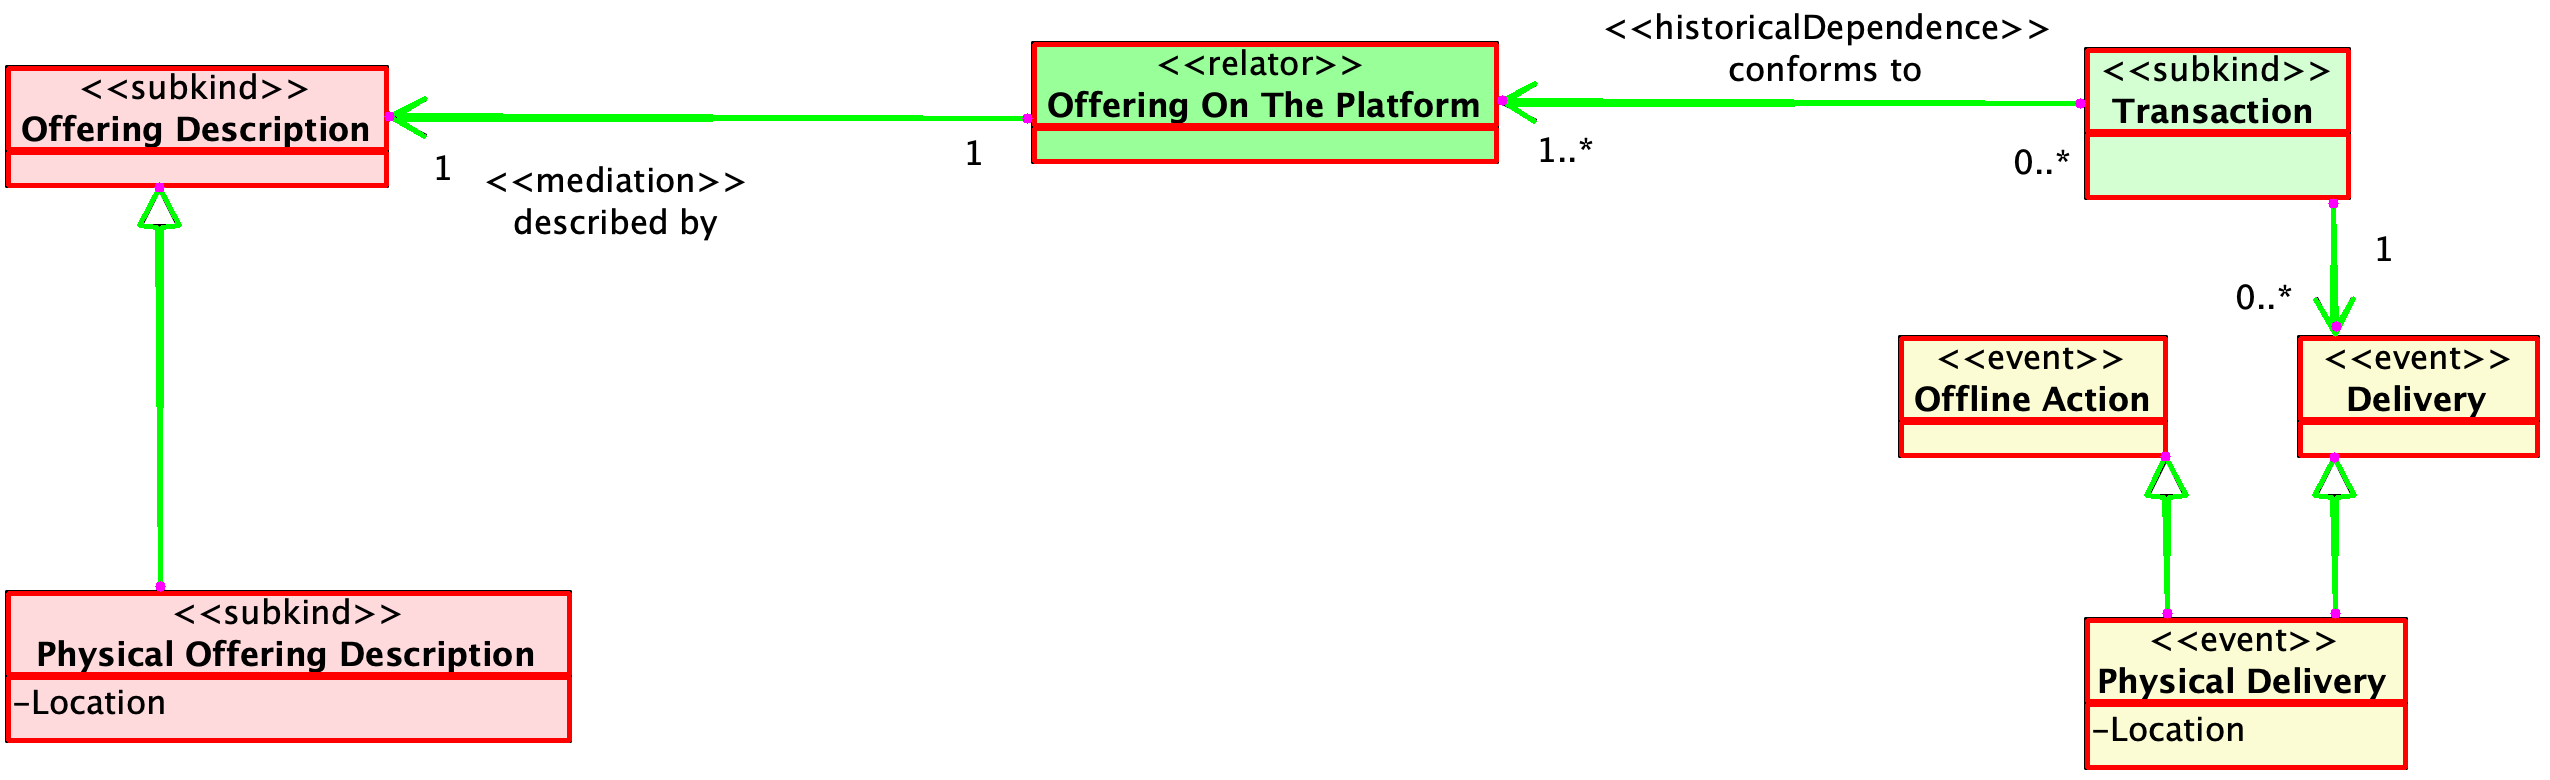

In [23]:
def draw_rectangles_and_rels(image, rectangles, relationships):
    # Copy the image to draw rectangles on it
    output_image = cv2.imread(image_path)

    # Loop over each rectangle and draw it on the image
    for rect_obj in rectangles:
        rect1 = rect_obj.top
        # Draw the rectangle
        cv2.rectangle(output_image, rect1.tl(), rect1.br(), (0, 0, 255), 3)
        rect2 = rect_obj.mid
        # Draw the rectangle
        cv2.rectangle(output_image, rect2.tl(), rect2.br(), (0, 0, 255), 3)

    for rel in relationships:
      cv2.polylines(output_image, [rel.curve.astype(int)], isClosed=True, color=(0, 255, 0), thickness=3)
      for ep in rel.endpoints:
        cv2.circle(output_image, (int(ep[0]), int(ep[1])), 5, (255, 0, 255), -1)
    cv2_imshow(output_image)

draw_rectangles_and_rels(processed_img, merged_classes, class_relations)

# Detect relationship type
Cut out the ends of the relationship lines and apply triangle detection to find generalisation relations and update relation types

Mounted at /content/drive


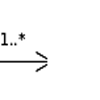

1/1 [==============================] - 2s 2s/step
[[0.00236579 0.6165255  0.38110873]]


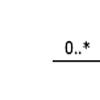

1/1 [==============================] - 0s 60ms/step
[[0.1752964  0.05744432 0.76725924]]




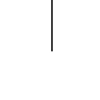

1/1 [==============================] - 0s 63ms/step
[[0.08240823 0.00663976 0.910952  ]]


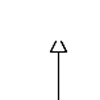

1/1 [==============================] - 0s 52ms/step
[[9.9741346e-01 2.0620688e-03 5.2444707e-04]]
Generalisation


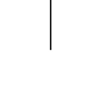

1/1 [==============================] - 0s 57ms/step
[[9.9959713e-01 6.8986929e-17 4.0286122e-04]]
Generalisation




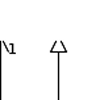

1/1 [==============================] - 0s 65ms/step
[[9.9808735e-01 1.6478833e-03 2.6476674e-04]]
Generalisation


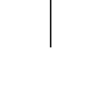

1/1 [==============================] - 0s 67ms/step
[[9.996176e-01 5.563858e-16 3.823925e-04]]
Generalisation




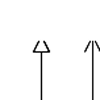

1/1 [==============================] - 0s 75ms/step
[[0.99675435 0.00185591 0.00138969]]
Generalisation


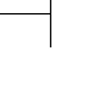

1/1 [==============================] - 0s 63ms/step
[[9.9928004e-01 8.2237946e-11 7.1996613e-04]]
Generalisation


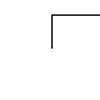

1/1 [==============================] - 0s 59ms/step
[[0.0518468  0.010708   0.93744516]]




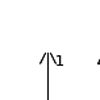

1/1 [==============================] - 0s 59ms/step
[[0.08887257 0.9056376  0.0054898 ]]


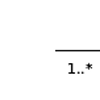

1/1 [==============================] - 0s 65ms/step
[[0.00654929 0.00756679 0.9858839 ]]




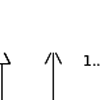

1/1 [==============================] - 0s 51ms/step
[[0.06409246 0.92467856 0.01122896]]


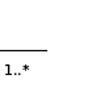

1/1 [==============================] - 0s 54ms/step
[[1.2375759e-04 2.2833797e-03 9.9759287e-01]]




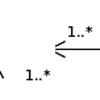

1/1 [==============================] - 0s 52ms/step
[[0.00254789 0.99328846 0.00416367]]


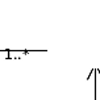

1/1 [==============================] - 0s 50ms/step
[[0.04975806 0.05236687 0.8978751 ]]




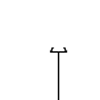

1/1 [==============================] - 0s 51ms/step
[[0.9355879  0.01309987 0.05131224]]
Generalisation


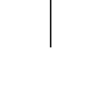

1/1 [==============================] - 0s 65ms/step
[[9.996176e-01 5.563858e-16 3.823925e-04]]
Generalisation




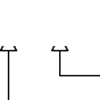

1/1 [==============================] - 0s 55ms/step
[[0.97488016 0.02220771 0.00291209]]
Generalisation


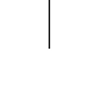

1/1 [==============================] - 0s 53ms/step
[[5.2655642e-03 7.0730801e-04 9.9402714e-01]]




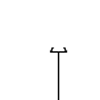

1/1 [==============================] - 0s 62ms/step
[[0.9355879  0.01309987 0.05131224]]
Generalisation


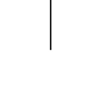

1/1 [==============================] - 0s 51ms/step
[[9.9959713e-01 6.8986929e-17 4.0286122e-04]]
Generalisation




In [15]:
import tensorflow as tf
drive.mount('/content/drive',  force_remount=True)

save_path = '/content/drive/My Drive/Onto_UML_Data/Relation_Images2/'

# Load model
model_path = f'{save_path}/Relationship_classifier'
model = tf.keras.models.load_model(model_path)

filename = image_path.replace(".png", "")

num = 0

def calculate_square_size(image_size, num_classes, scale_factor=5):
    """
    Calculate the size of the square based on the image size and number of classes.

    Args:
    image_size (tuple): The size of the image (width, height).
    num_classes (int): The number of classes.
    scale_factor (float): A scaling factor to adjust the size calculation.

    Returns:
    int: The calculated size of the square.
    """
    width, height = image_size

    # Calculate the diagonal length of the image
    image_diagonal = (width**2 + height**2)**0.5

    # Determine the base size proportion using the scaling factor
    base_proportion = image_diagonal / scale_factor

    # Calculate the size of the square, inversely proportional to the square root of the number of classes
    square_size = base_proportion / (num_classes**0.5)

    # Ensure the square size is at least 1 pixel
    square_size = max(1, int(square_size))

    return square_size




def classify_relation_sign(image, model, input_size = (100,100)):
    # Resize to the image size the model takes

    image_resized = cv2.resize(image, input_size)
    cv2_imshow(image_resized)
    # Convert to rgb
    rgb_image = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)


    # Add batch dimension
    image_batch = np.expand_dims(rgb_image, axis=0)


    # Predict the class probabilities
    predictions = model.predict(image_batch)
    print(predictions)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class



def get_relation_type(point, image, num, size, model):
  point_x, point_y = int(point[0]), int(point[1])  # Example coordinates of the point

  # Define the size of the square
  #should be based on number of classes: more classes => smaller symbols
  #size = 30

  # Calculate the coordinates for cropping
  top_left_x = max(point_x - size // 2, 0)
  top_left_y = max(point_y - size // 2, 0)
  bottom_right_x = min(point_x + size // 2, image.shape[1])
  bottom_right_y = min(point_y + size // 2, image.shape[0])

  # Crop the image
  cropped_image = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
  cropped_image = cv2.resize(cropped_image, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
  #triangles = detect_triangles(cropped_image)
  sign = classify_relation_sign(cropped_image, model)


  # Display or save the cropped image
  #cv2_imshow(cropped_image)

  if sign[0] == 0:
    print("Generalisation")
    return "Generalisation"
  else:
    return "Other"







def detect_triangles(image):
    # Read the image

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Edge detection using Canny
    edged = cv2.Canny(blurred, 60, 150)

    # Find contours
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    triangles = []

    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the approximated contour has 3 vertices
        if len(approx) == 3:
            triangles.append(approx)
            # Draw the triangle on the image
            #cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)

    # Display the result
    if len(triangles) > 0:
      #cv2_imshow(image)
      return True
    return False


height, width = processed_img.shape[:2]
image_size = (width, height)

sq_size = calculate_square_size(image_size, len(classes))

for relation in class_relations:
  if(len(relation.classes) >= 2):
    for index,ep in enumerate(relation.endpoints):
      ep_type = get_relation_type(ep, no_class_img2, num, sq_size, model)
      if ep_type == "Generalisation":
        relation.set_type(ep_type, index)

    if relation.rel_type == "":
      relation.set_type("Other")
    print("\n")

# Save
Generate OntoUML Vocab code and save to .ttl file

In [33]:
import uuid
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF


# Function to create and add class triples
def create_class_triples(class_list, g, namespace):
    class_uris = {}
    iter = 0
    for class_item in class_list:
        class_id = str(uuid.uuid4())
        iter += 1
        class_item.setId(class_id)
        class_name = class_item.name
        class_stereotype = class_item.stereotype

        class_uri = URIRef(f"{namespace}{class_id}")
        class_uris[class_name] = class_uri  # Store URI for later reference

        # Create triples
        g.add((class_uri, RDF.type, namespace.Class))
        g.add((class_uri, namespace.name, Literal(class_name, lang="en")))
        if not class_stereotype == "":
          g.add((class_uri, namespace.stereotype, URIRef(f"{namespace}{class_stereotype}")))
    return class_uris


def create_relationship_triples(relations, g, namespace, class_uris):
  i = 0
  for relation in relations:
    rel_id = str(uuid.uuid4())
    rel_uri = URIRef(f"{namespace}{rel_id}")
    if relation.rel_type == "Generalisation" and relation.source != -1:
      # add relationship
      g.add((rel_uri, RDF.type, namespace.Generalization))
      # Add relationship classes
      for index,cls in enumerate(relation.classes):
        if index == relation.source:
          #add as general
          g.add((rel_uri, namespace.general, class_uris[cls.name]))
        else:
          #add as specific
          g.add((rel_uri, namespace.specific, class_uris[cls.name]))
    else:
      continue
    i += 1

  pass

# Create a new graph
g = Graph()

# Define the namespaces
ONTOUML = Namespace("http://example.org/ontouml#")

# Bind the namespace prefix to the graph
g.bind("ontouml", ONTOUML)

# Create and add class and relationship triples to the graph
uris = create_class_triples(classes, g, ONTOUML)
create_relationship_triples(class_relations, g, ONTOUML, uris)



# Save the graph to a Turtle file
g.serialize(destination=f"{diagram_name}.ttl", format="turtle")



<Graph identifier=N52a8c1b280d640b1876b36b4c486ba10 (<class 'rdflib.graph.Graph'>)>

In [30]:
print(class_relations[0].classes[0].id)

CL2


In [4]:
# TODO uncomment to install the OntoUML vocabulary library
!pip install ontouml_vocabulary_lib
from ontouml_vocabulary_lib import *

my_ontouml_class = OntoUML.Class

# Output
print(my_ontouml_class)  # https://w3id.org/ontouml#Class


print(ONTOUML_CLASS_STEREOTYPES)



https://w3id.org/ontouml#Class
(rdflib.term.URIRef('https://w3id.org/ontouml#abstract'), rdflib.term.URIRef('https://w3id.org/ontouml#category'), rdflib.term.URIRef('https://w3id.org/ontouml#collective'), rdflib.term.URIRef('https://w3id.org/ontouml#datatype'), rdflib.term.URIRef('https://w3id.org/ontouml#enumeration'), rdflib.term.URIRef('https://w3id.org/ontouml#event'), rdflib.term.URIRef('https://w3id.org/ontouml#historicalRole'), rdflib.term.URIRef('https://w3id.org/ontouml#historicalRoleMixin'), rdflib.term.URIRef('https://w3id.org/ontouml#kind'), rdflib.term.URIRef('https://w3id.org/ontouml#mixin'), rdflib.term.URIRef('https://w3id.org/ontouml#mode'), rdflib.term.URIRef('https://w3id.org/ontouml#phase'), rdflib.term.URIRef('https://w3id.org/ontouml#phaseMixin'), rdflib.term.URIRef('https://w3id.org/ontouml#quality'), rdflib.term.URIRef('https://w3id.org/ontouml#quantity'), rdflib.term.URIRef('https://w3id.org/ontouml#relator'), rdflib.term.URIRef('https://w3id.org/ontouml#role')

[(0, 1), (2, 3)]


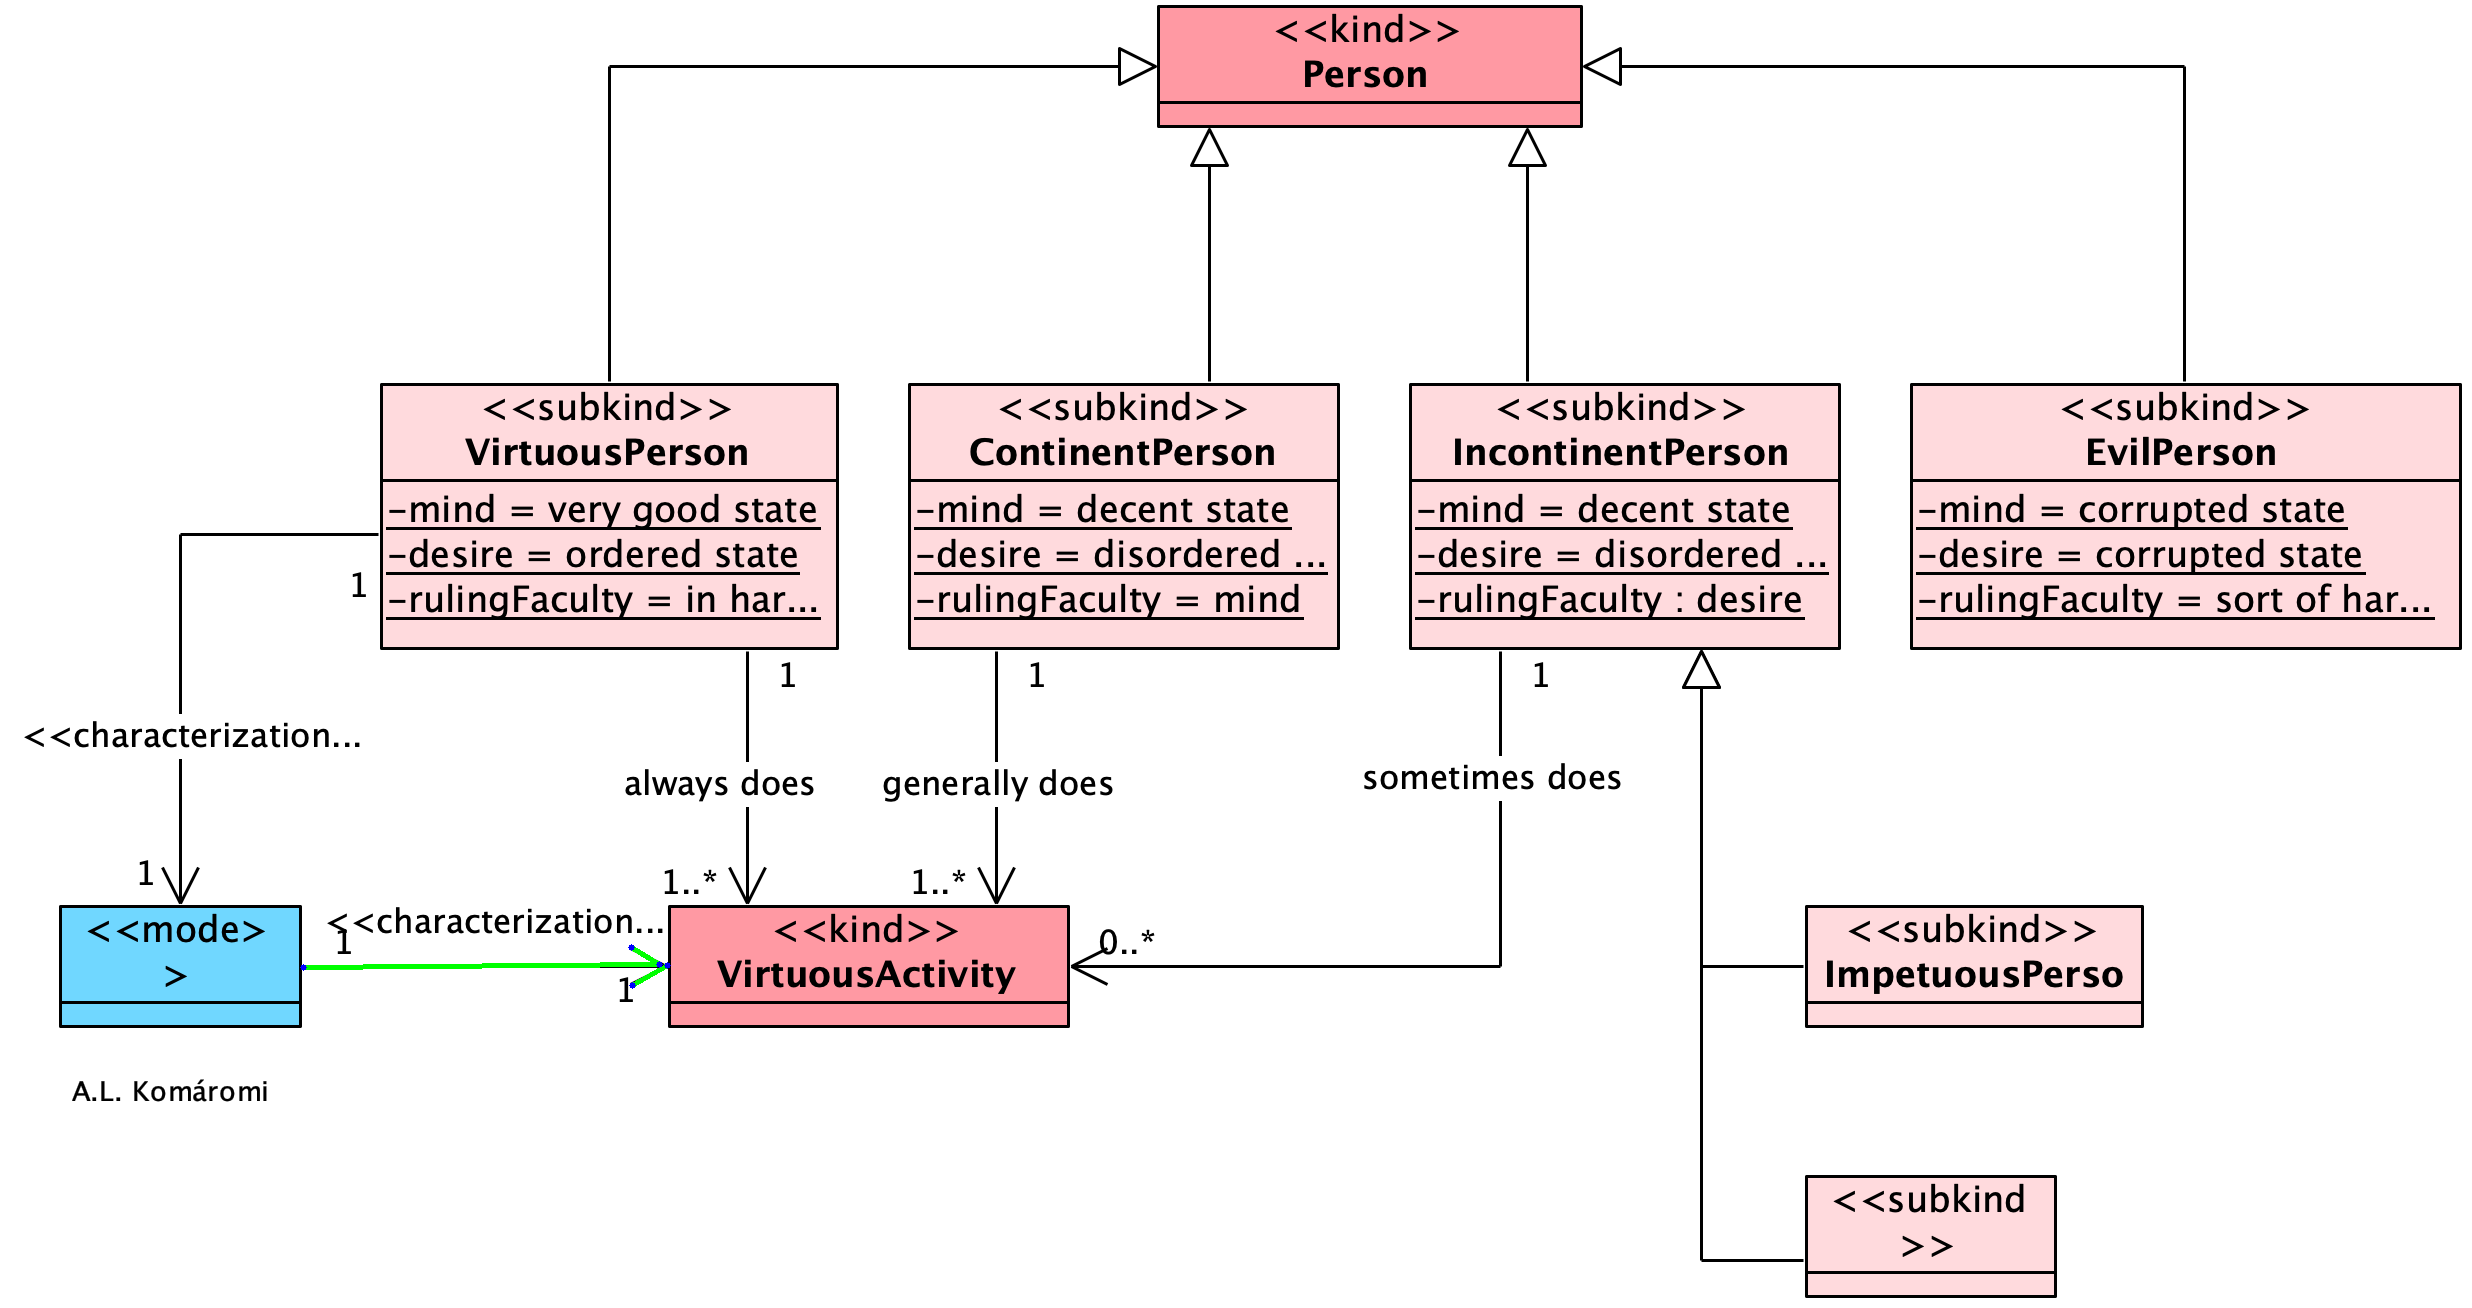



[(1, 2), (3, 5), (4, 5)]


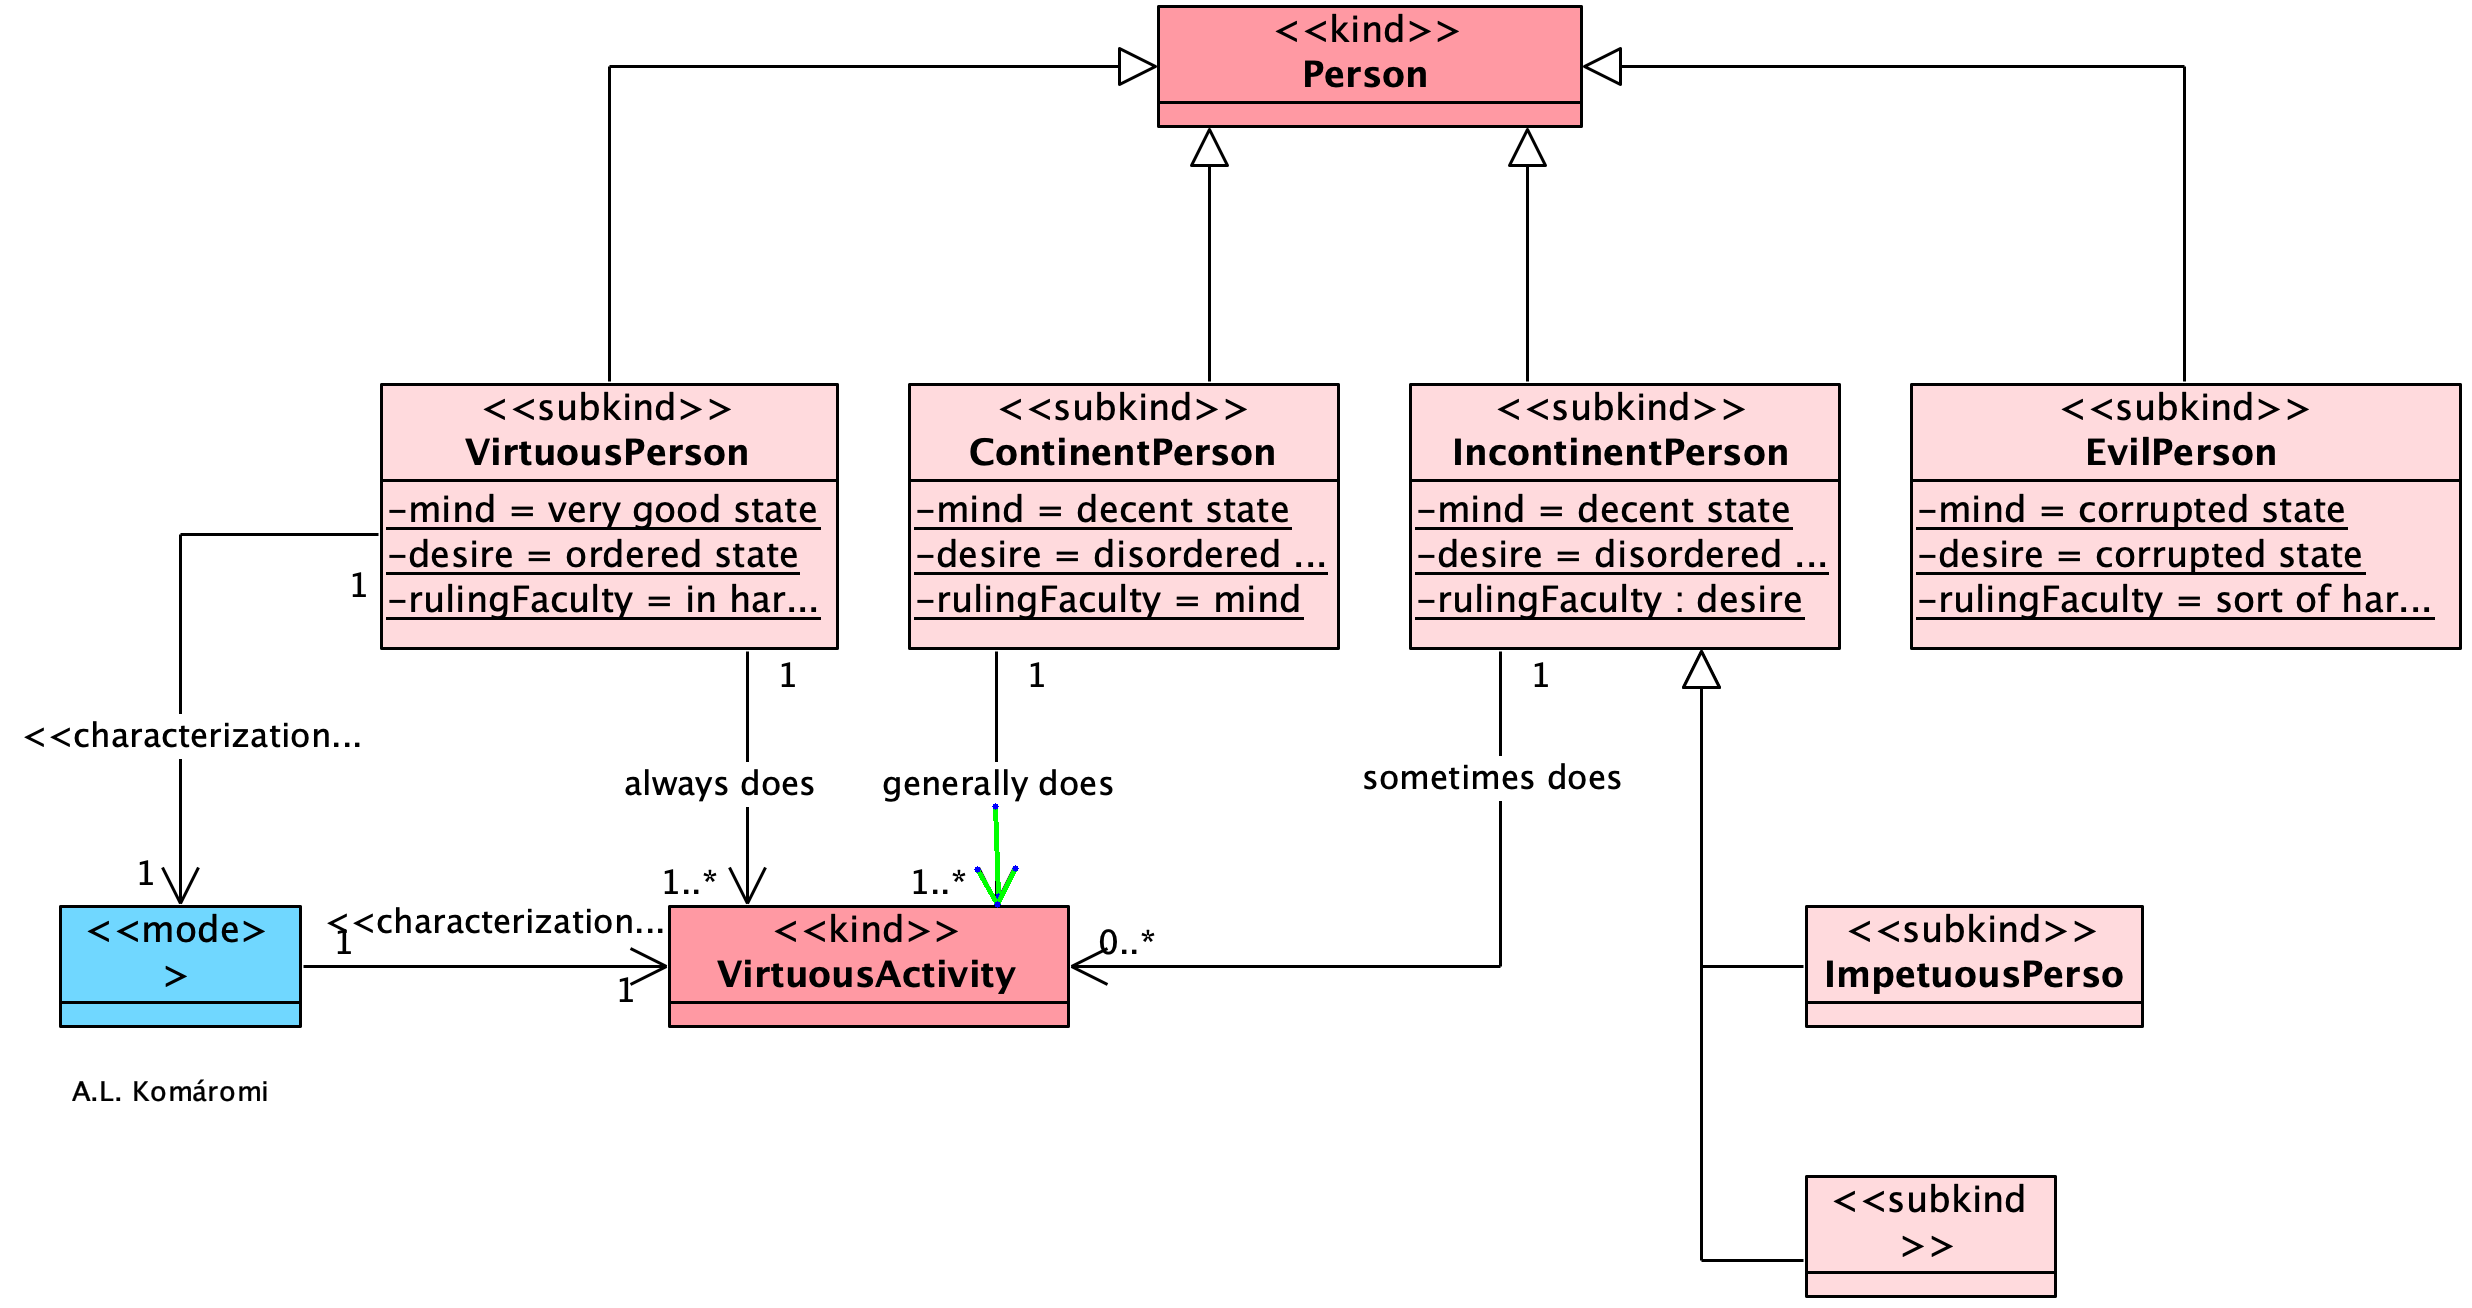



[(1, 2), (3, 5), (4, 5)]


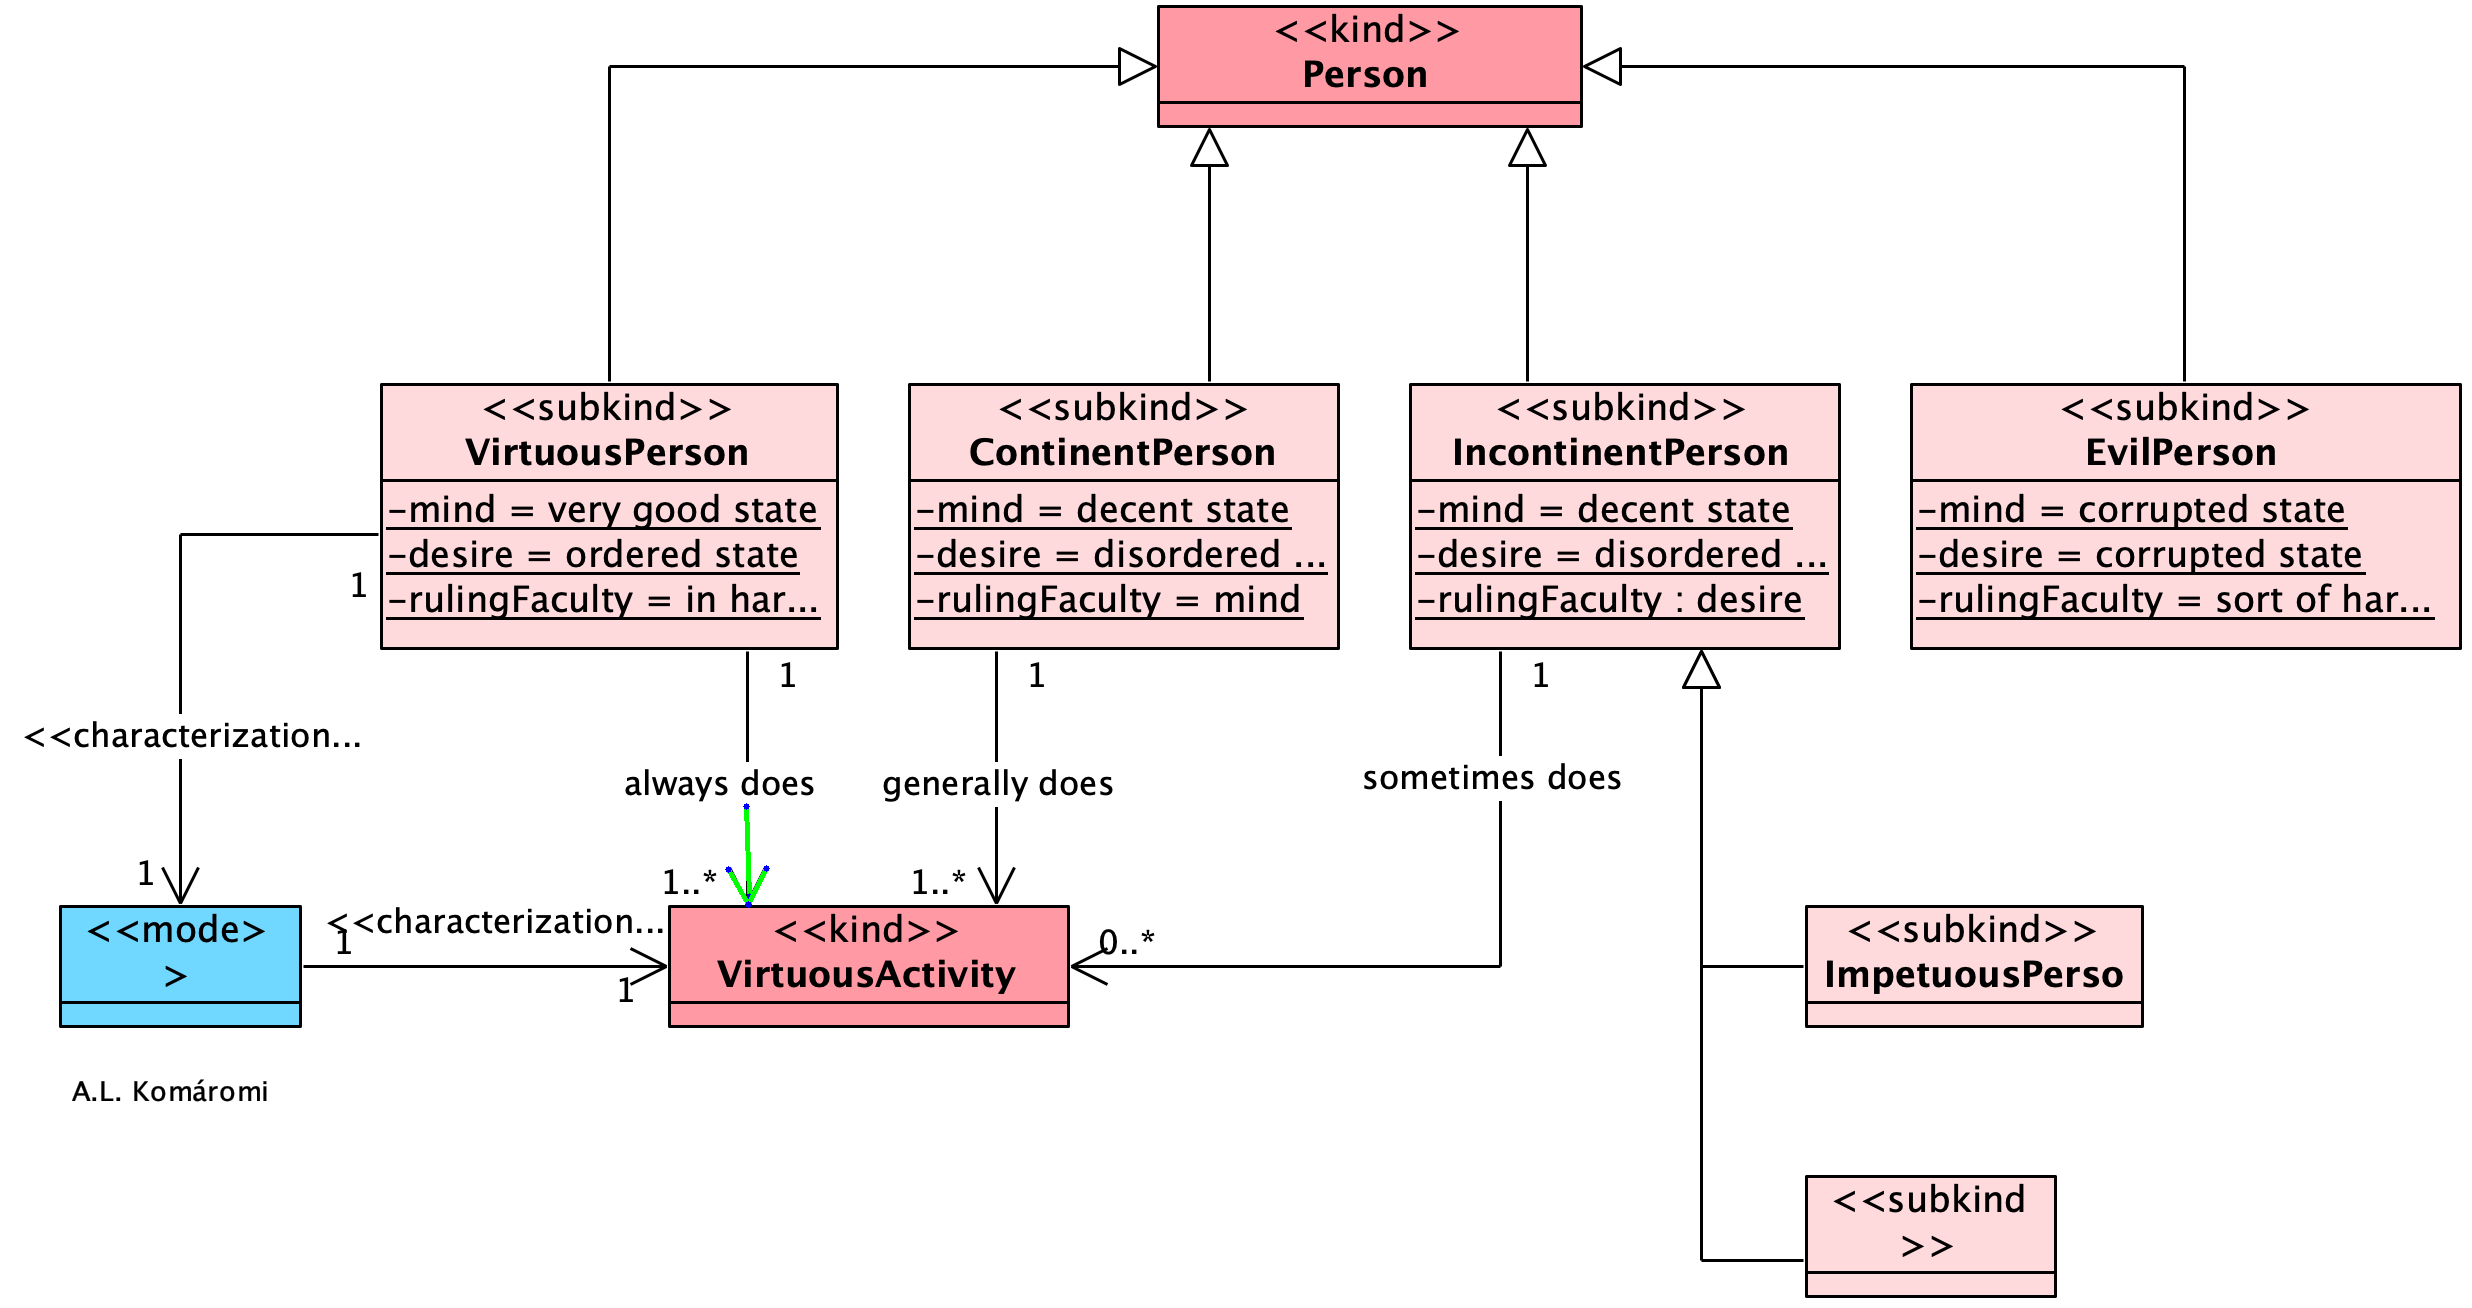



[(1, 7), (2, 3)]


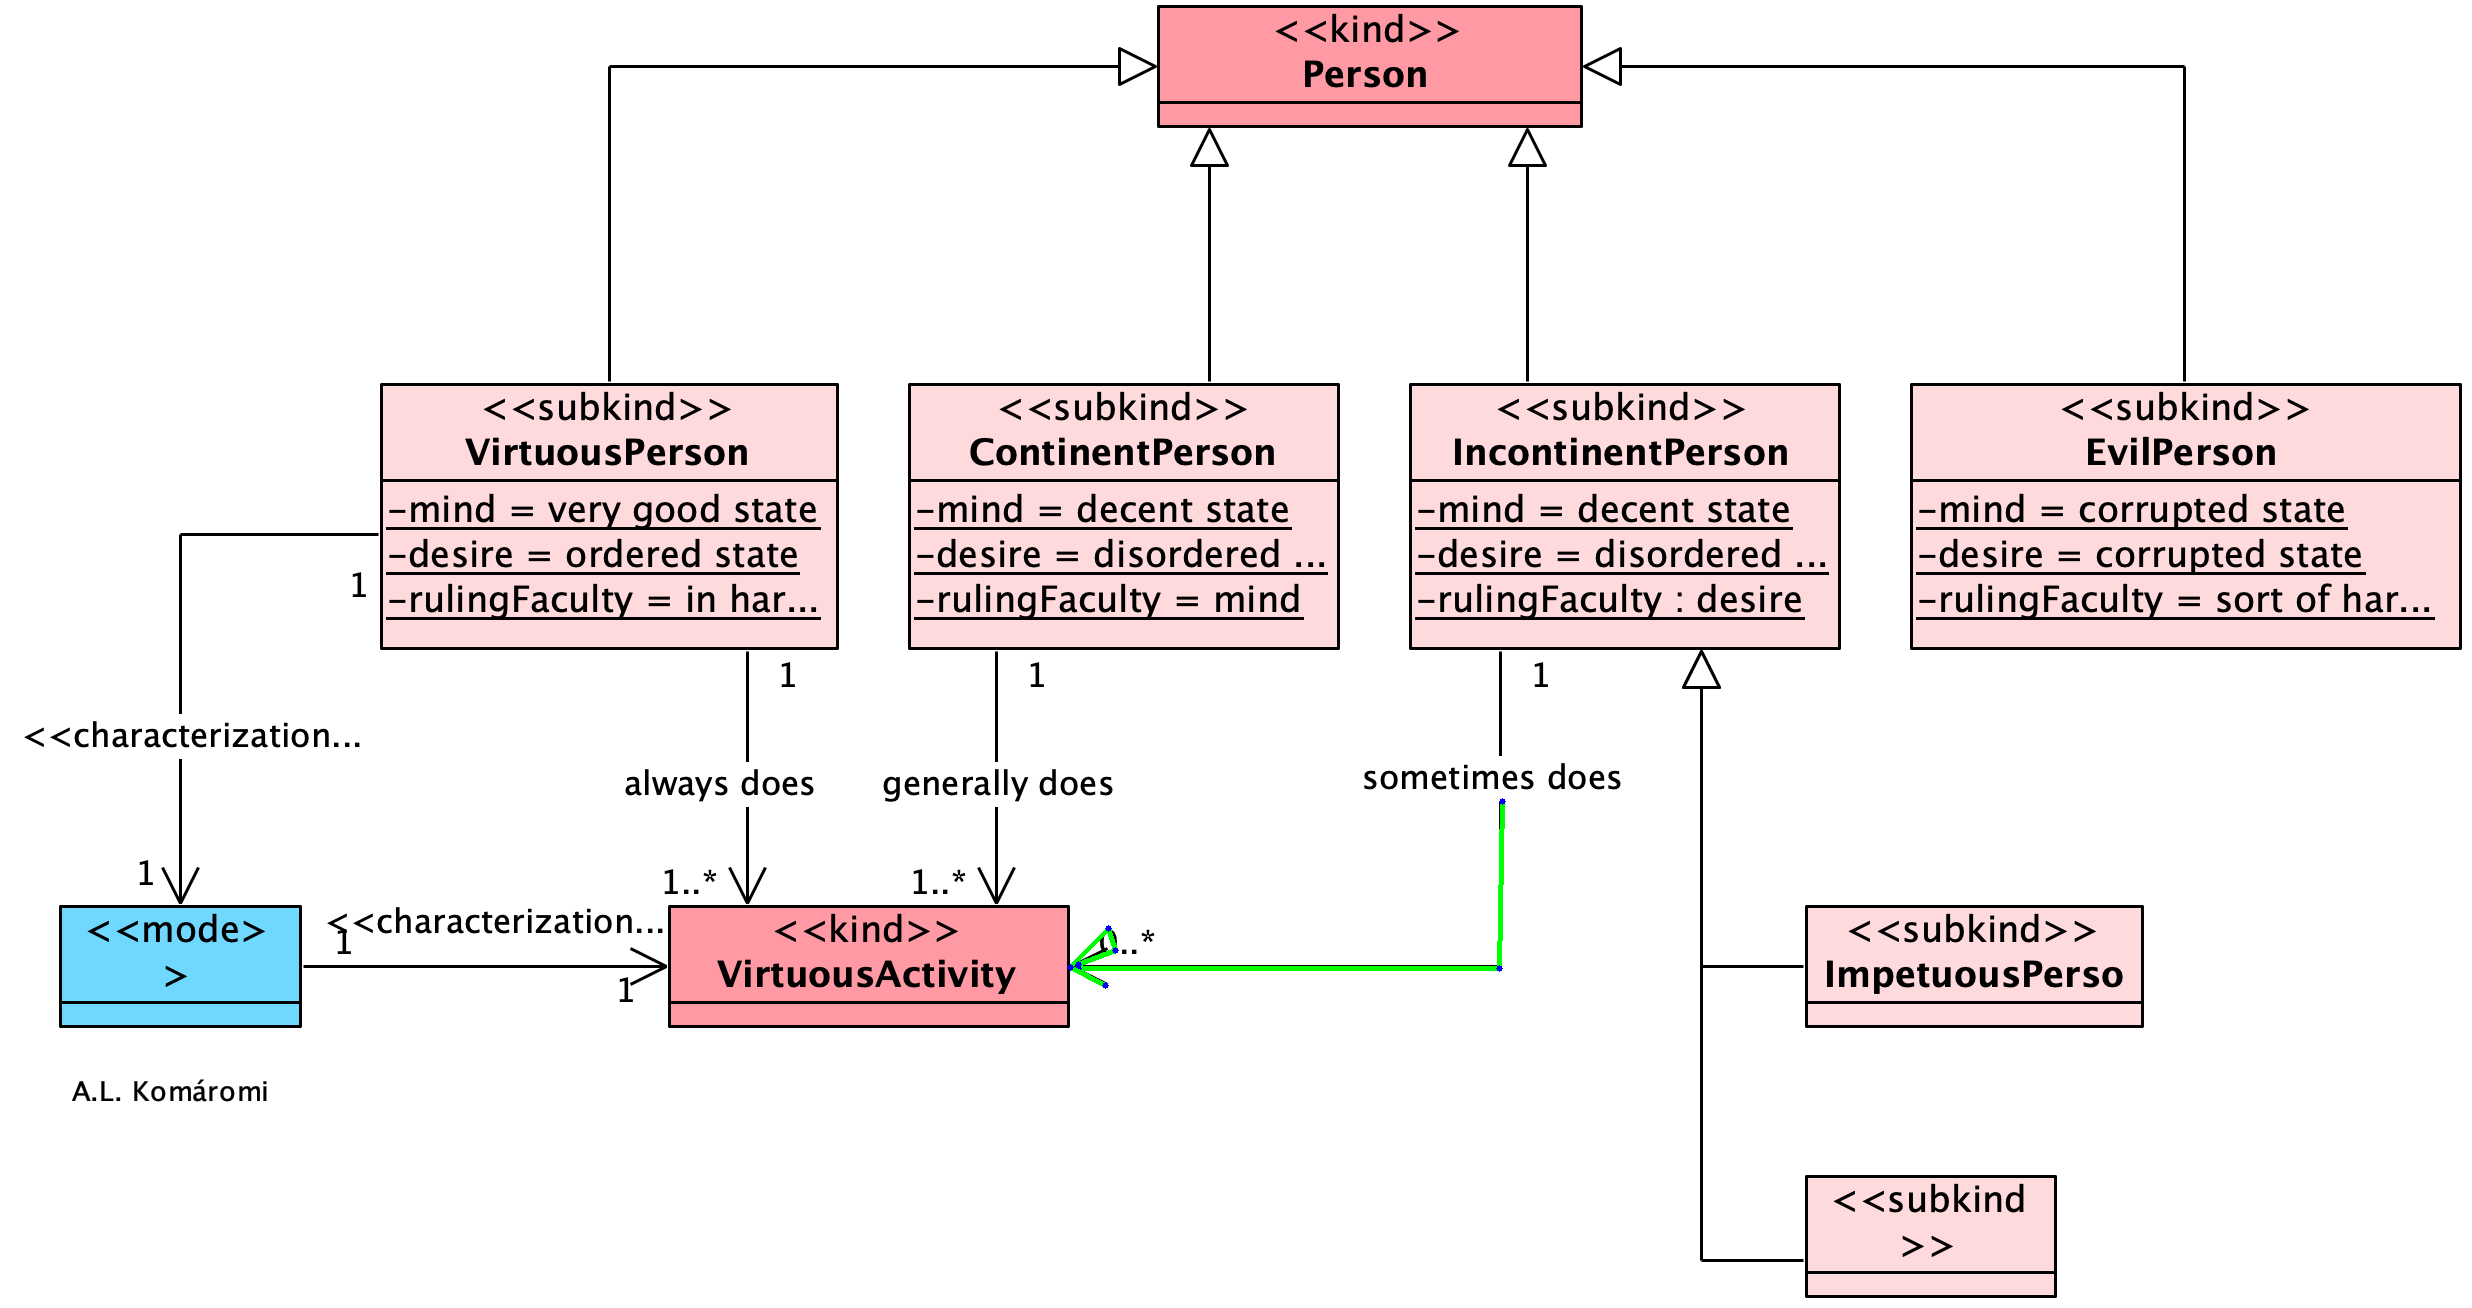



[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (4, 10), (4, 11), (5, 8), (5, 9), (5, 10), (5, 11), (6, 7), (6, 8), (6, 9), (6, 11), (6, 12), (7, 8), (7, 12), (7, 13), (8, 9), (8, 11), (8, 12), (8, 13), (9, 10), (9, 11), (9, 12), (10, 11), (10, 12), (11, 12), (12, 13), (13, 14)]
line skipped
line skipped
line skipped


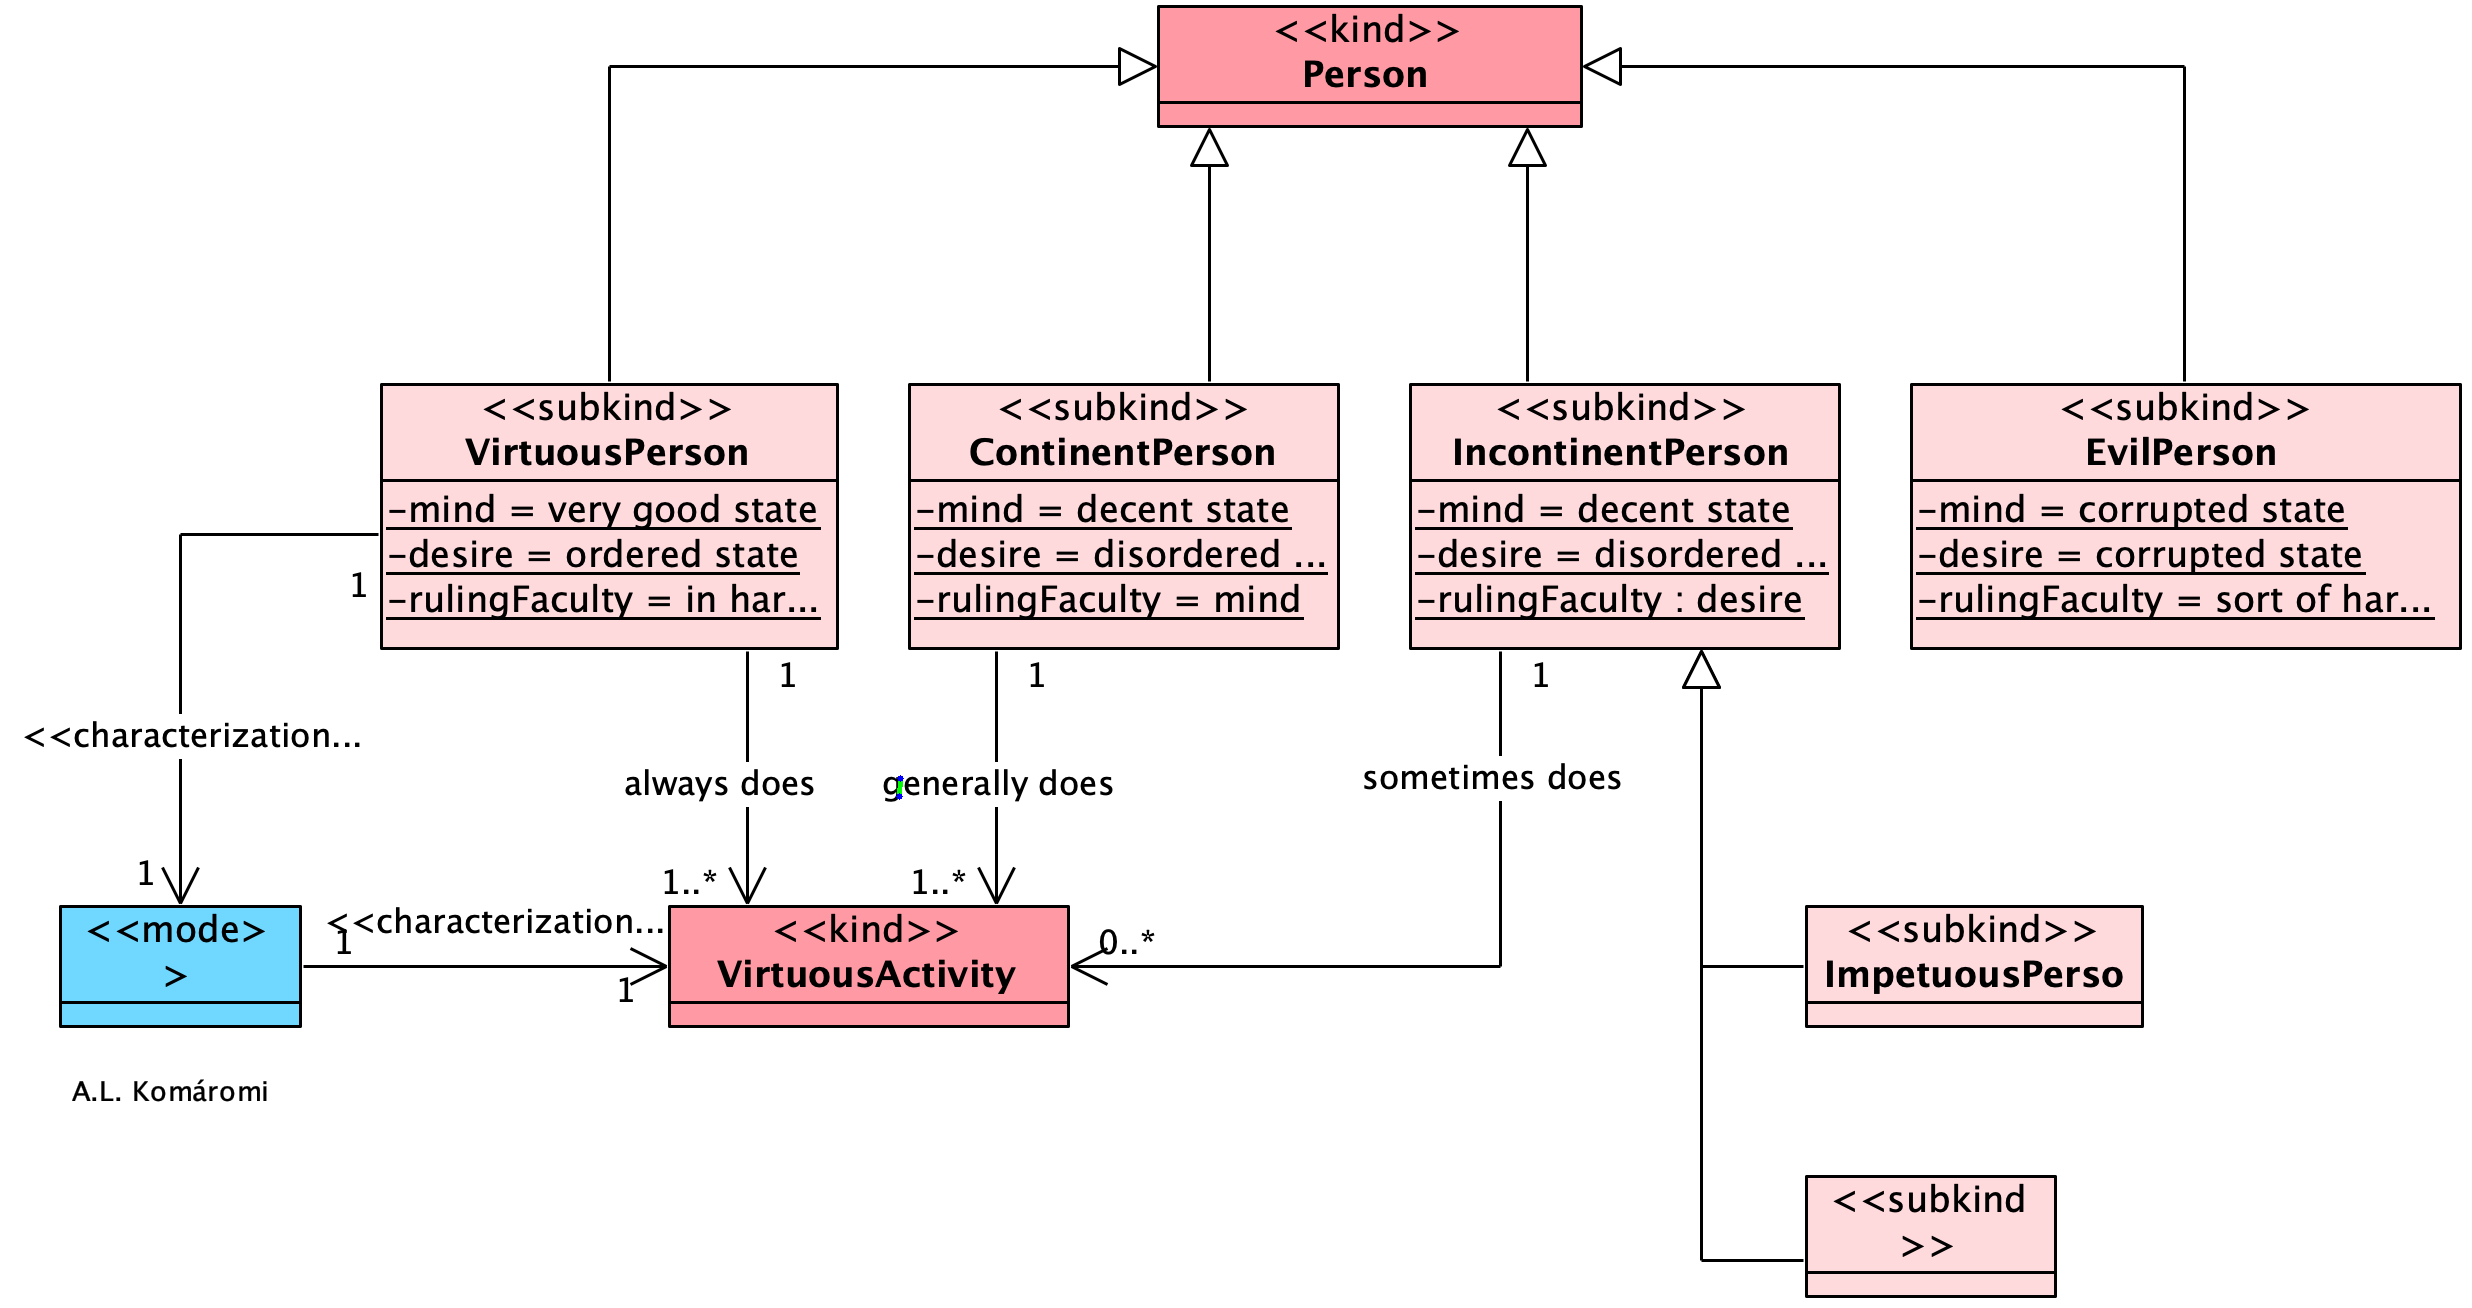



[(0, 1), (0, 12), (0, 13), (0, 14), (1, 12), (1, 13), (1, 14), (2, 11), (2, 12), (2, 13), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (11, 13), (11, 14), (12, 13), (12, 14), (13, 14)]
line skipped
line skipped


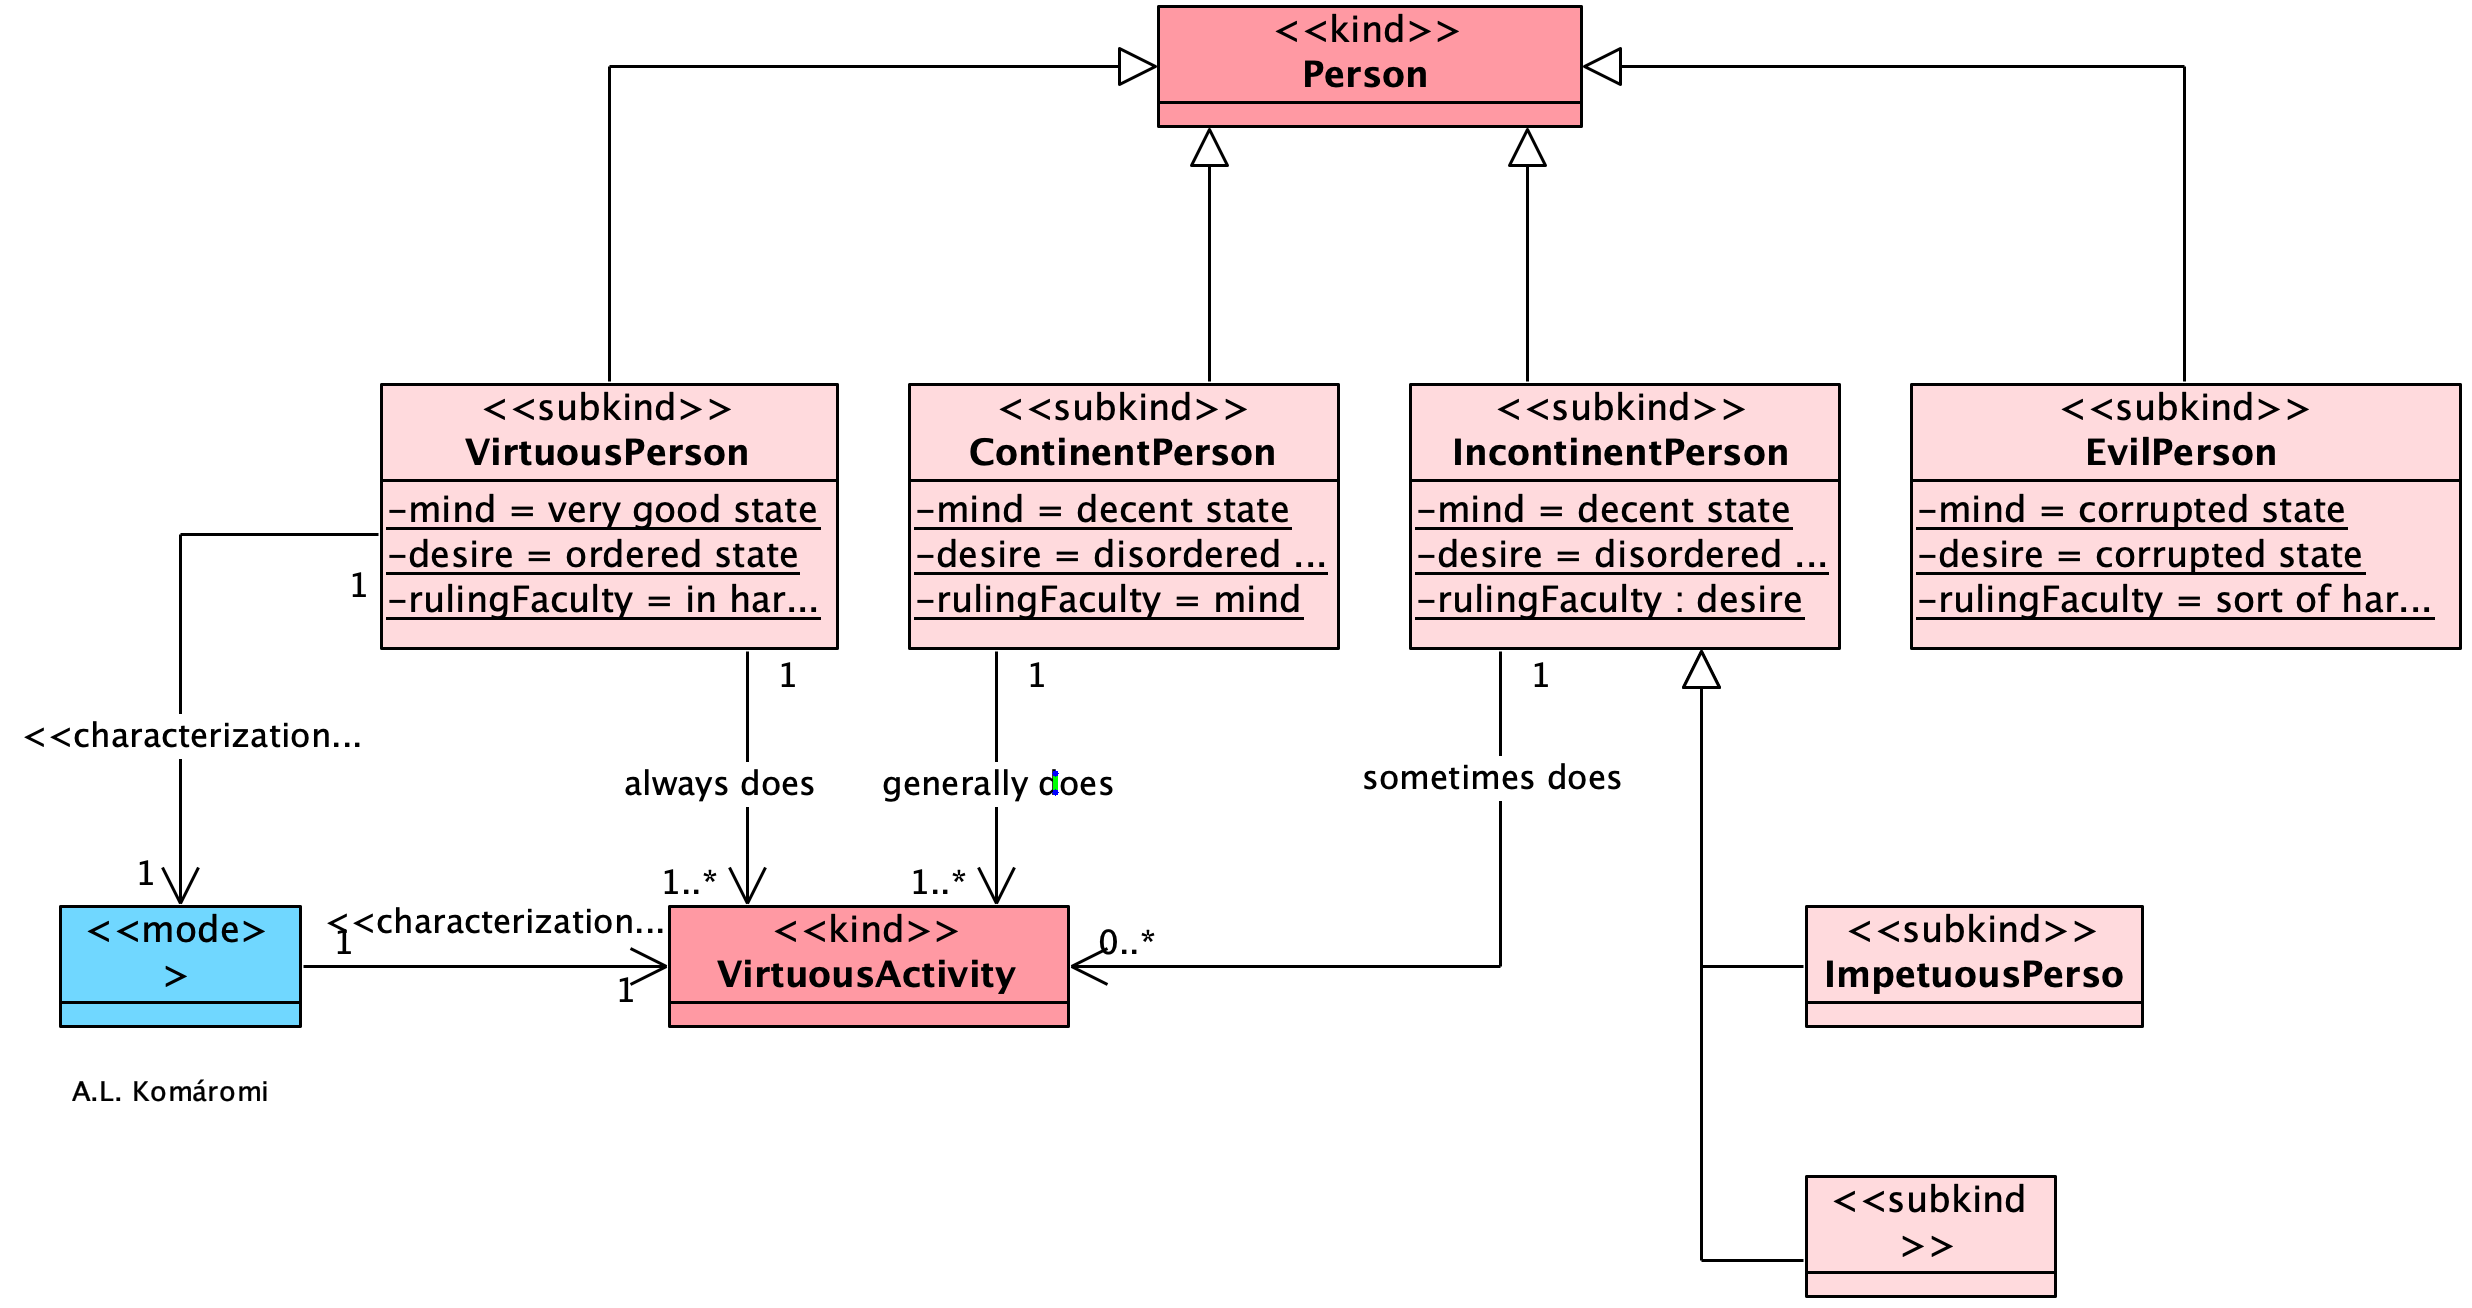



[(0, 1), (0, 12), (0, 13), (0, 14), (1, 12), (1, 13), (1, 14), (2, 11), (2, 12), (2, 13), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (11, 13), (11, 14), (12, 13), (12, 14), (13, 14)]
line skipped
line skipped


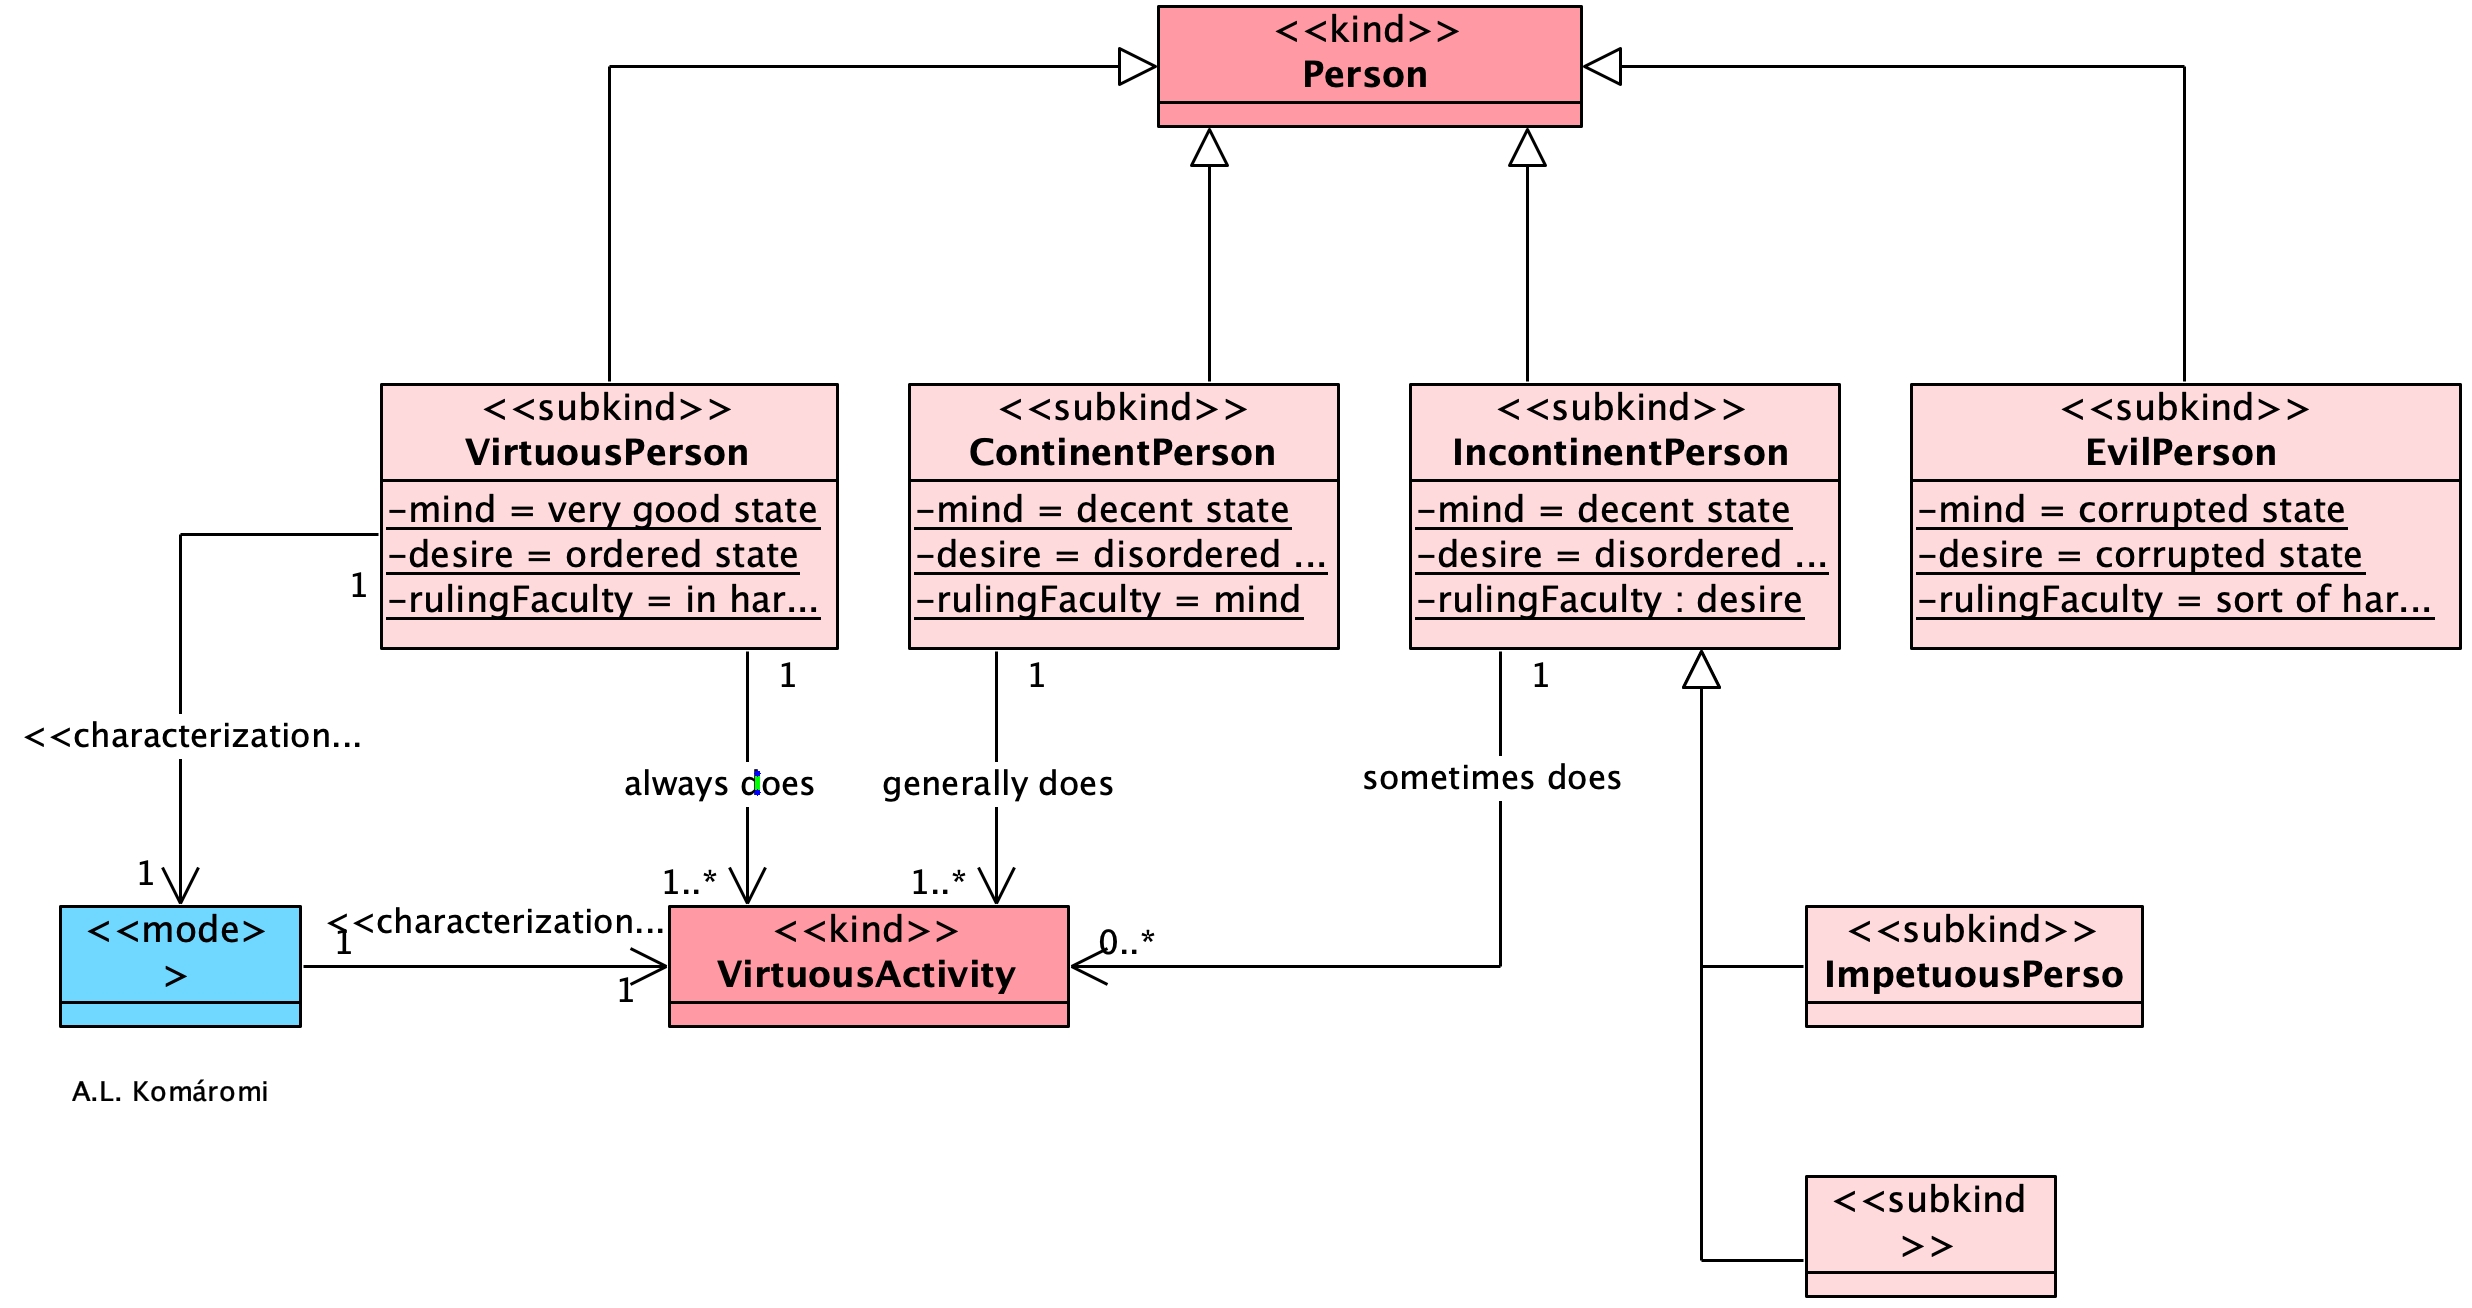



[(0, 1), (0, 12), (0, 13), (0, 14), (1, 12), (1, 13), (1, 14), (2, 11), (2, 12), (2, 13), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (11, 13), (11, 14), (12, 13), (12, 14), (13, 14)]
line skipped
line skipped


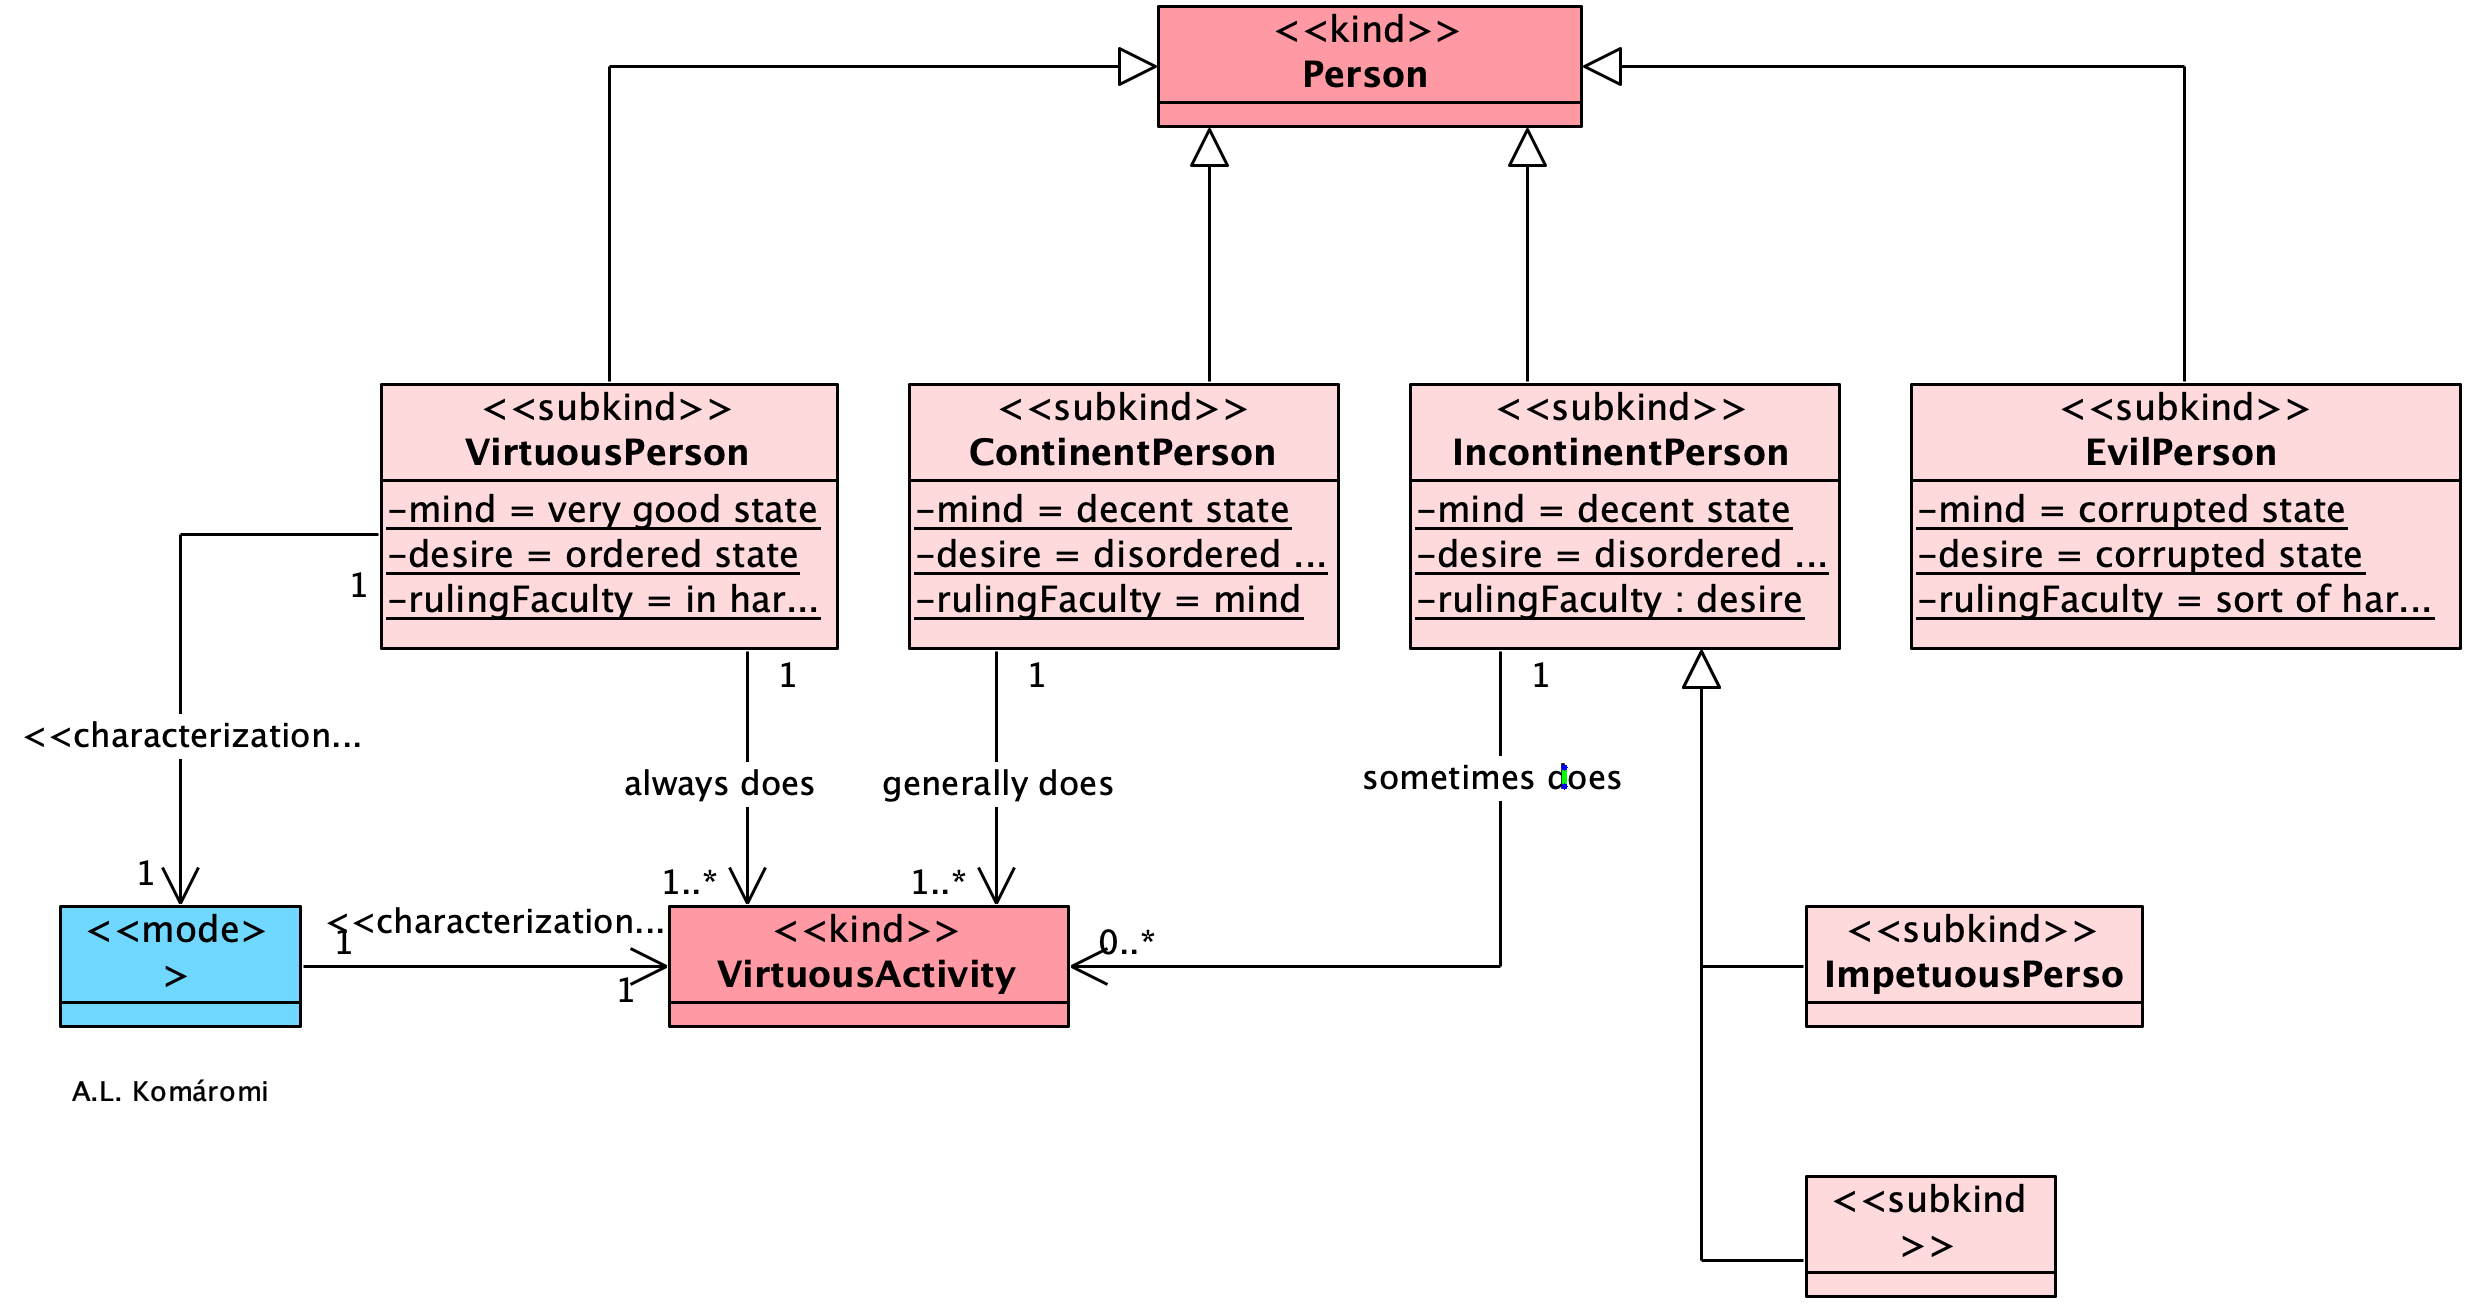



[(1, 2), (3, 4)]


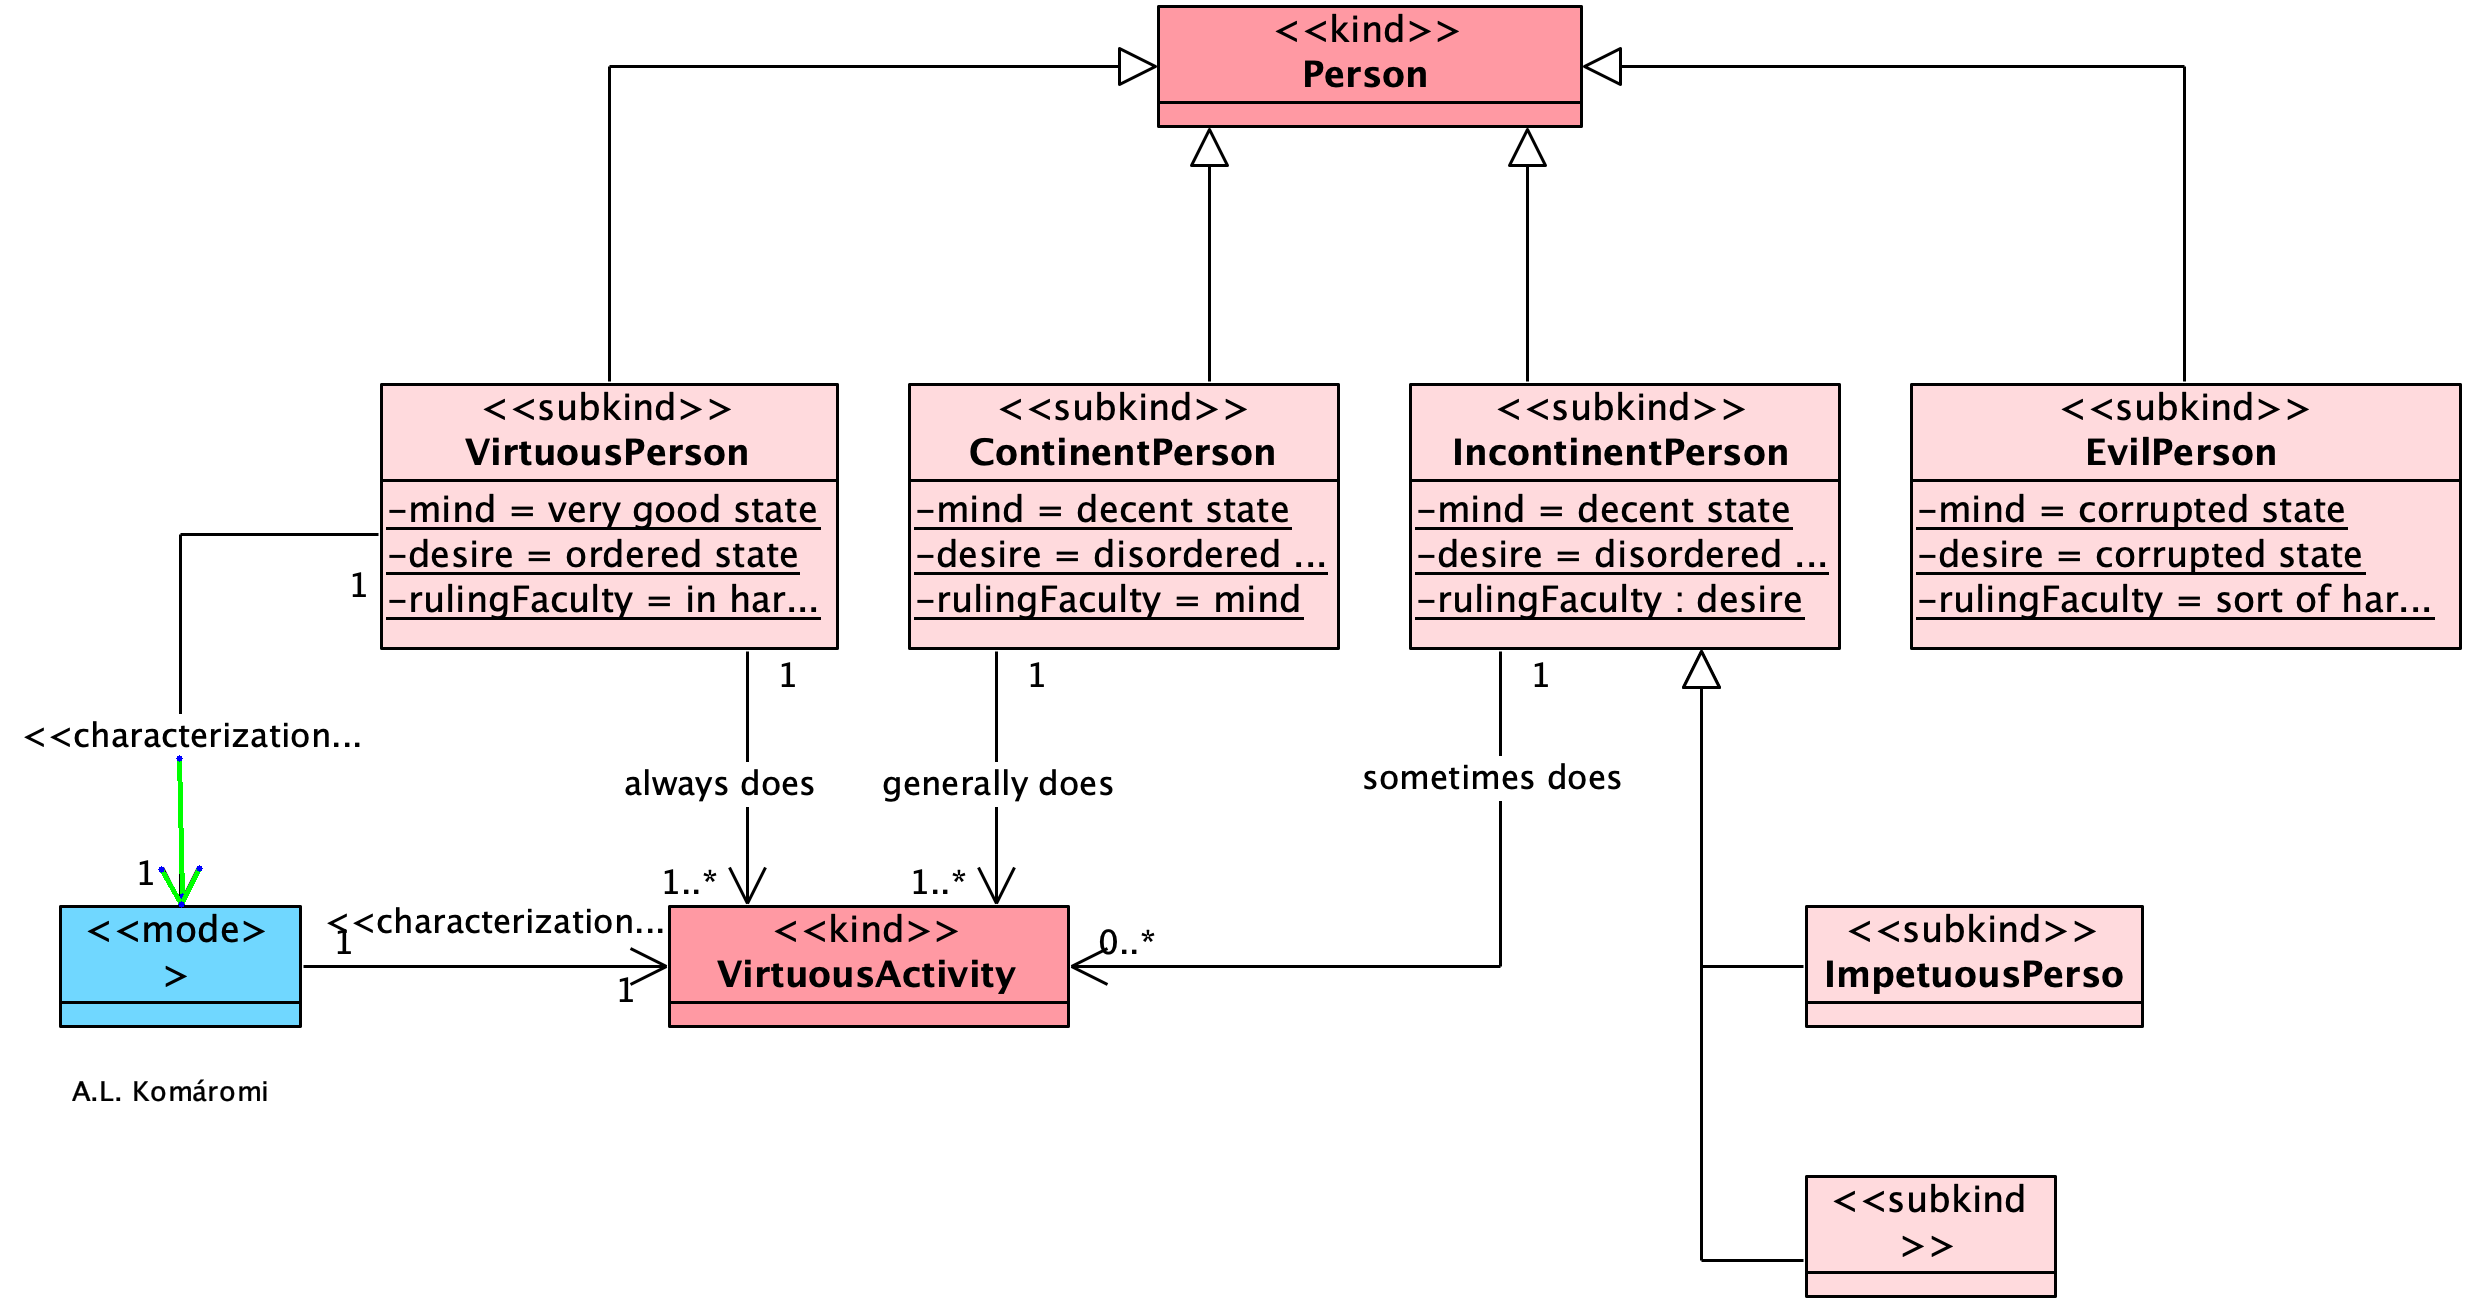



[]


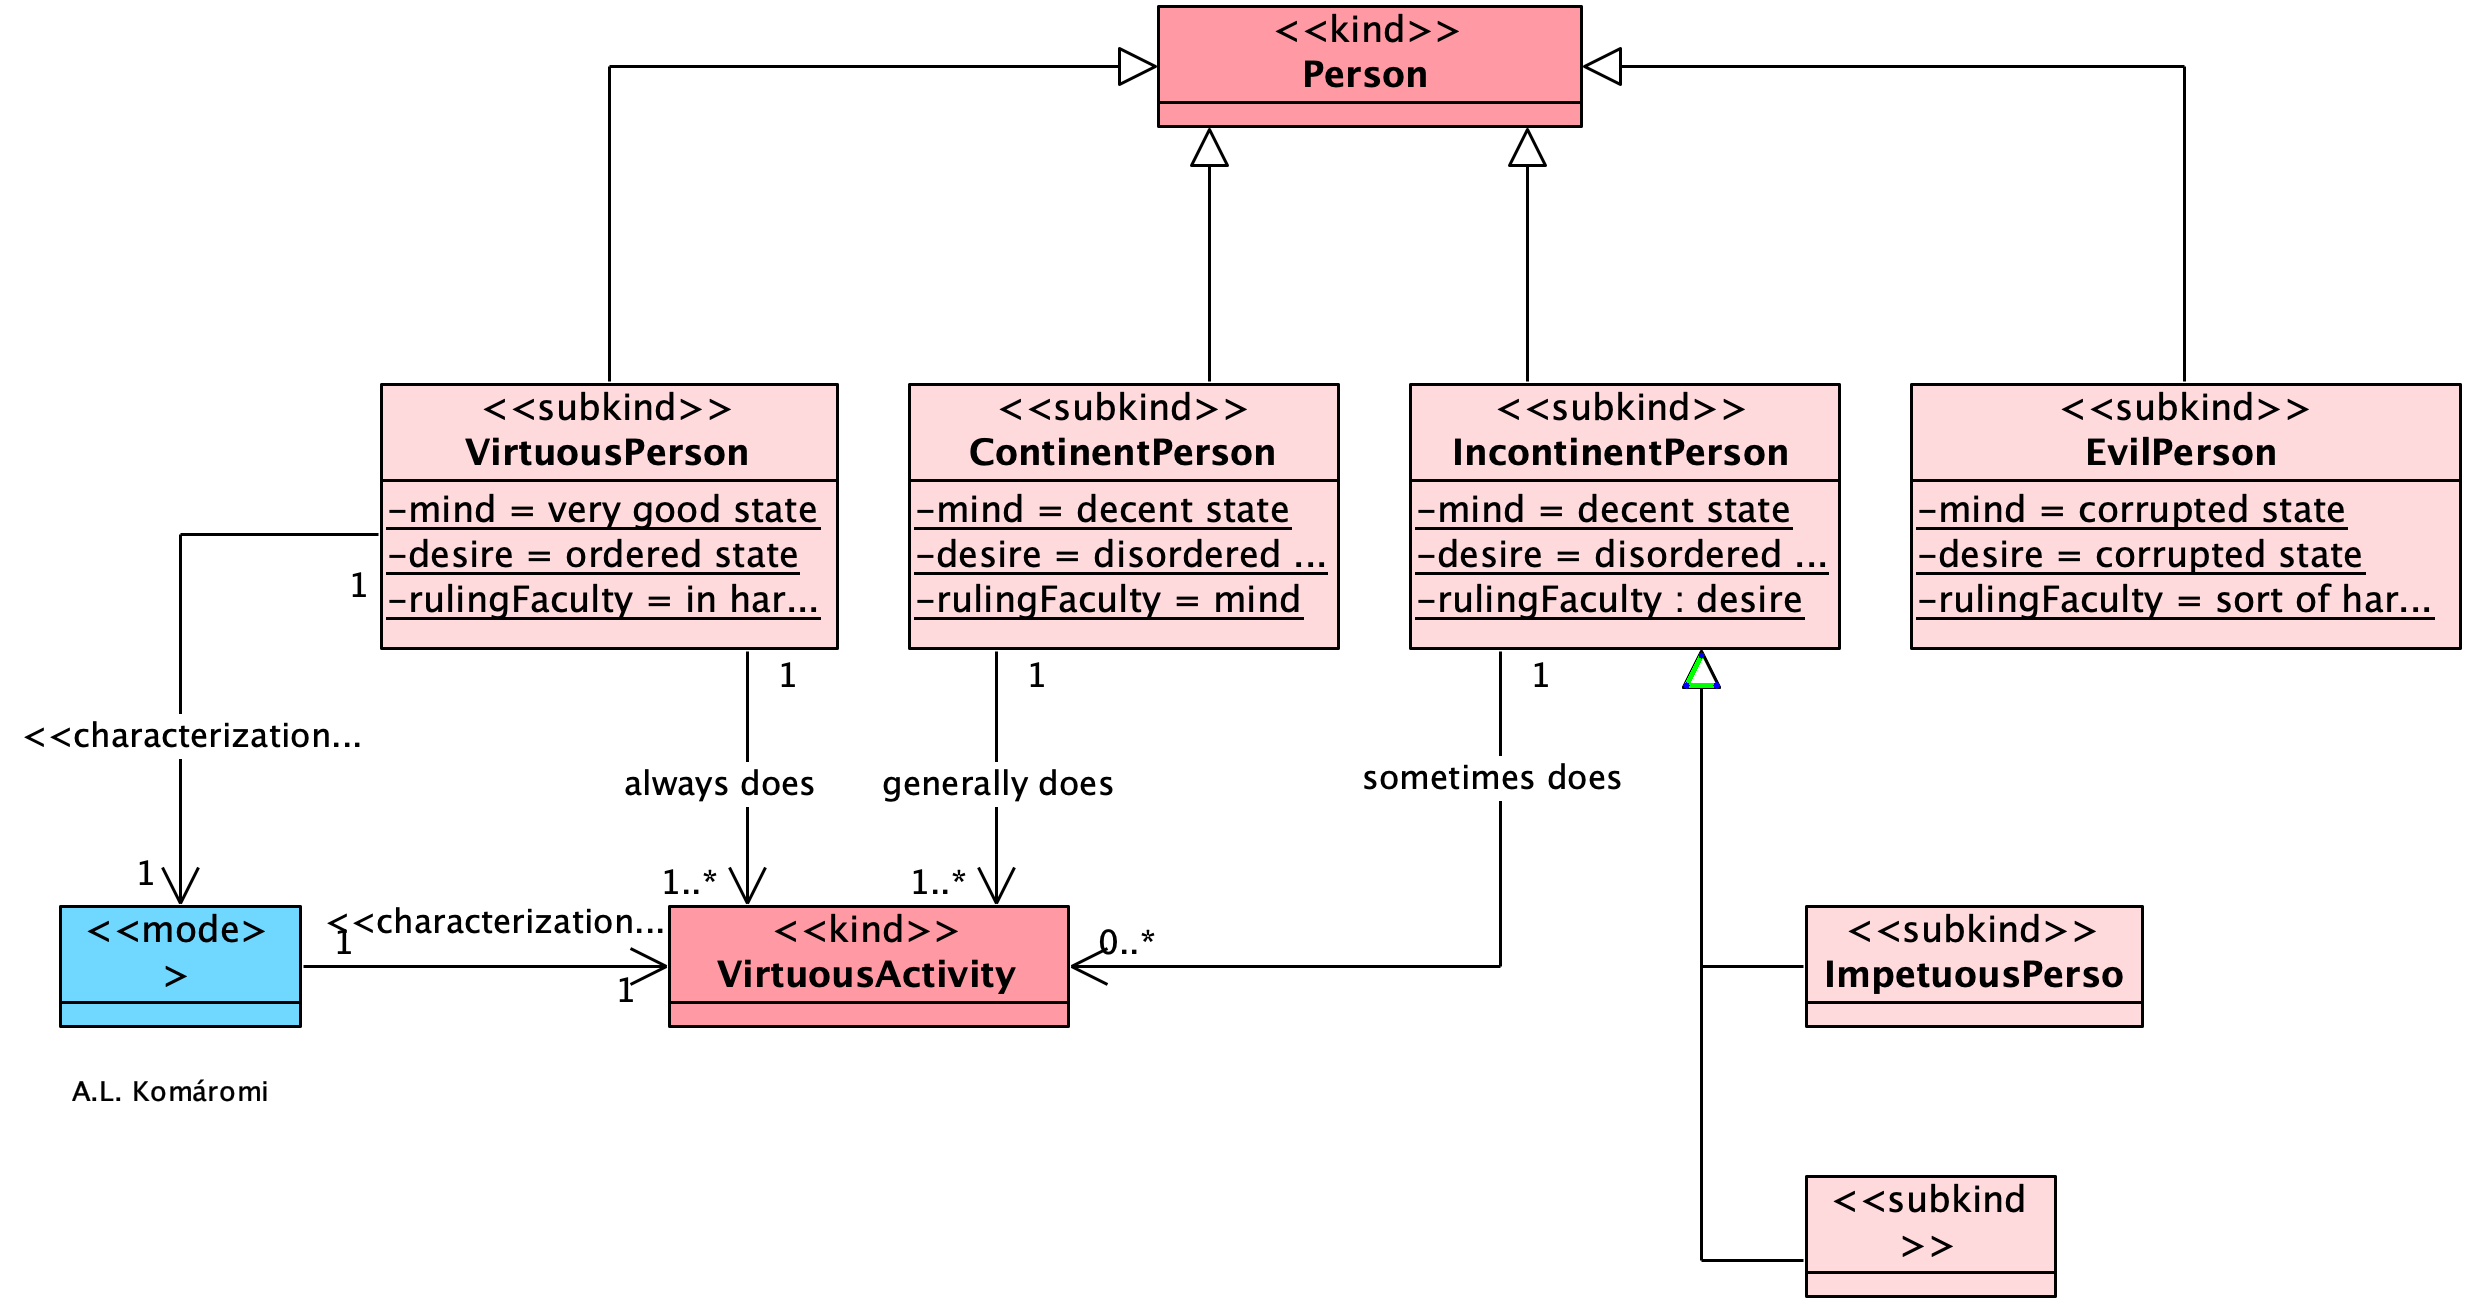



[(1, 2)]
line skipped


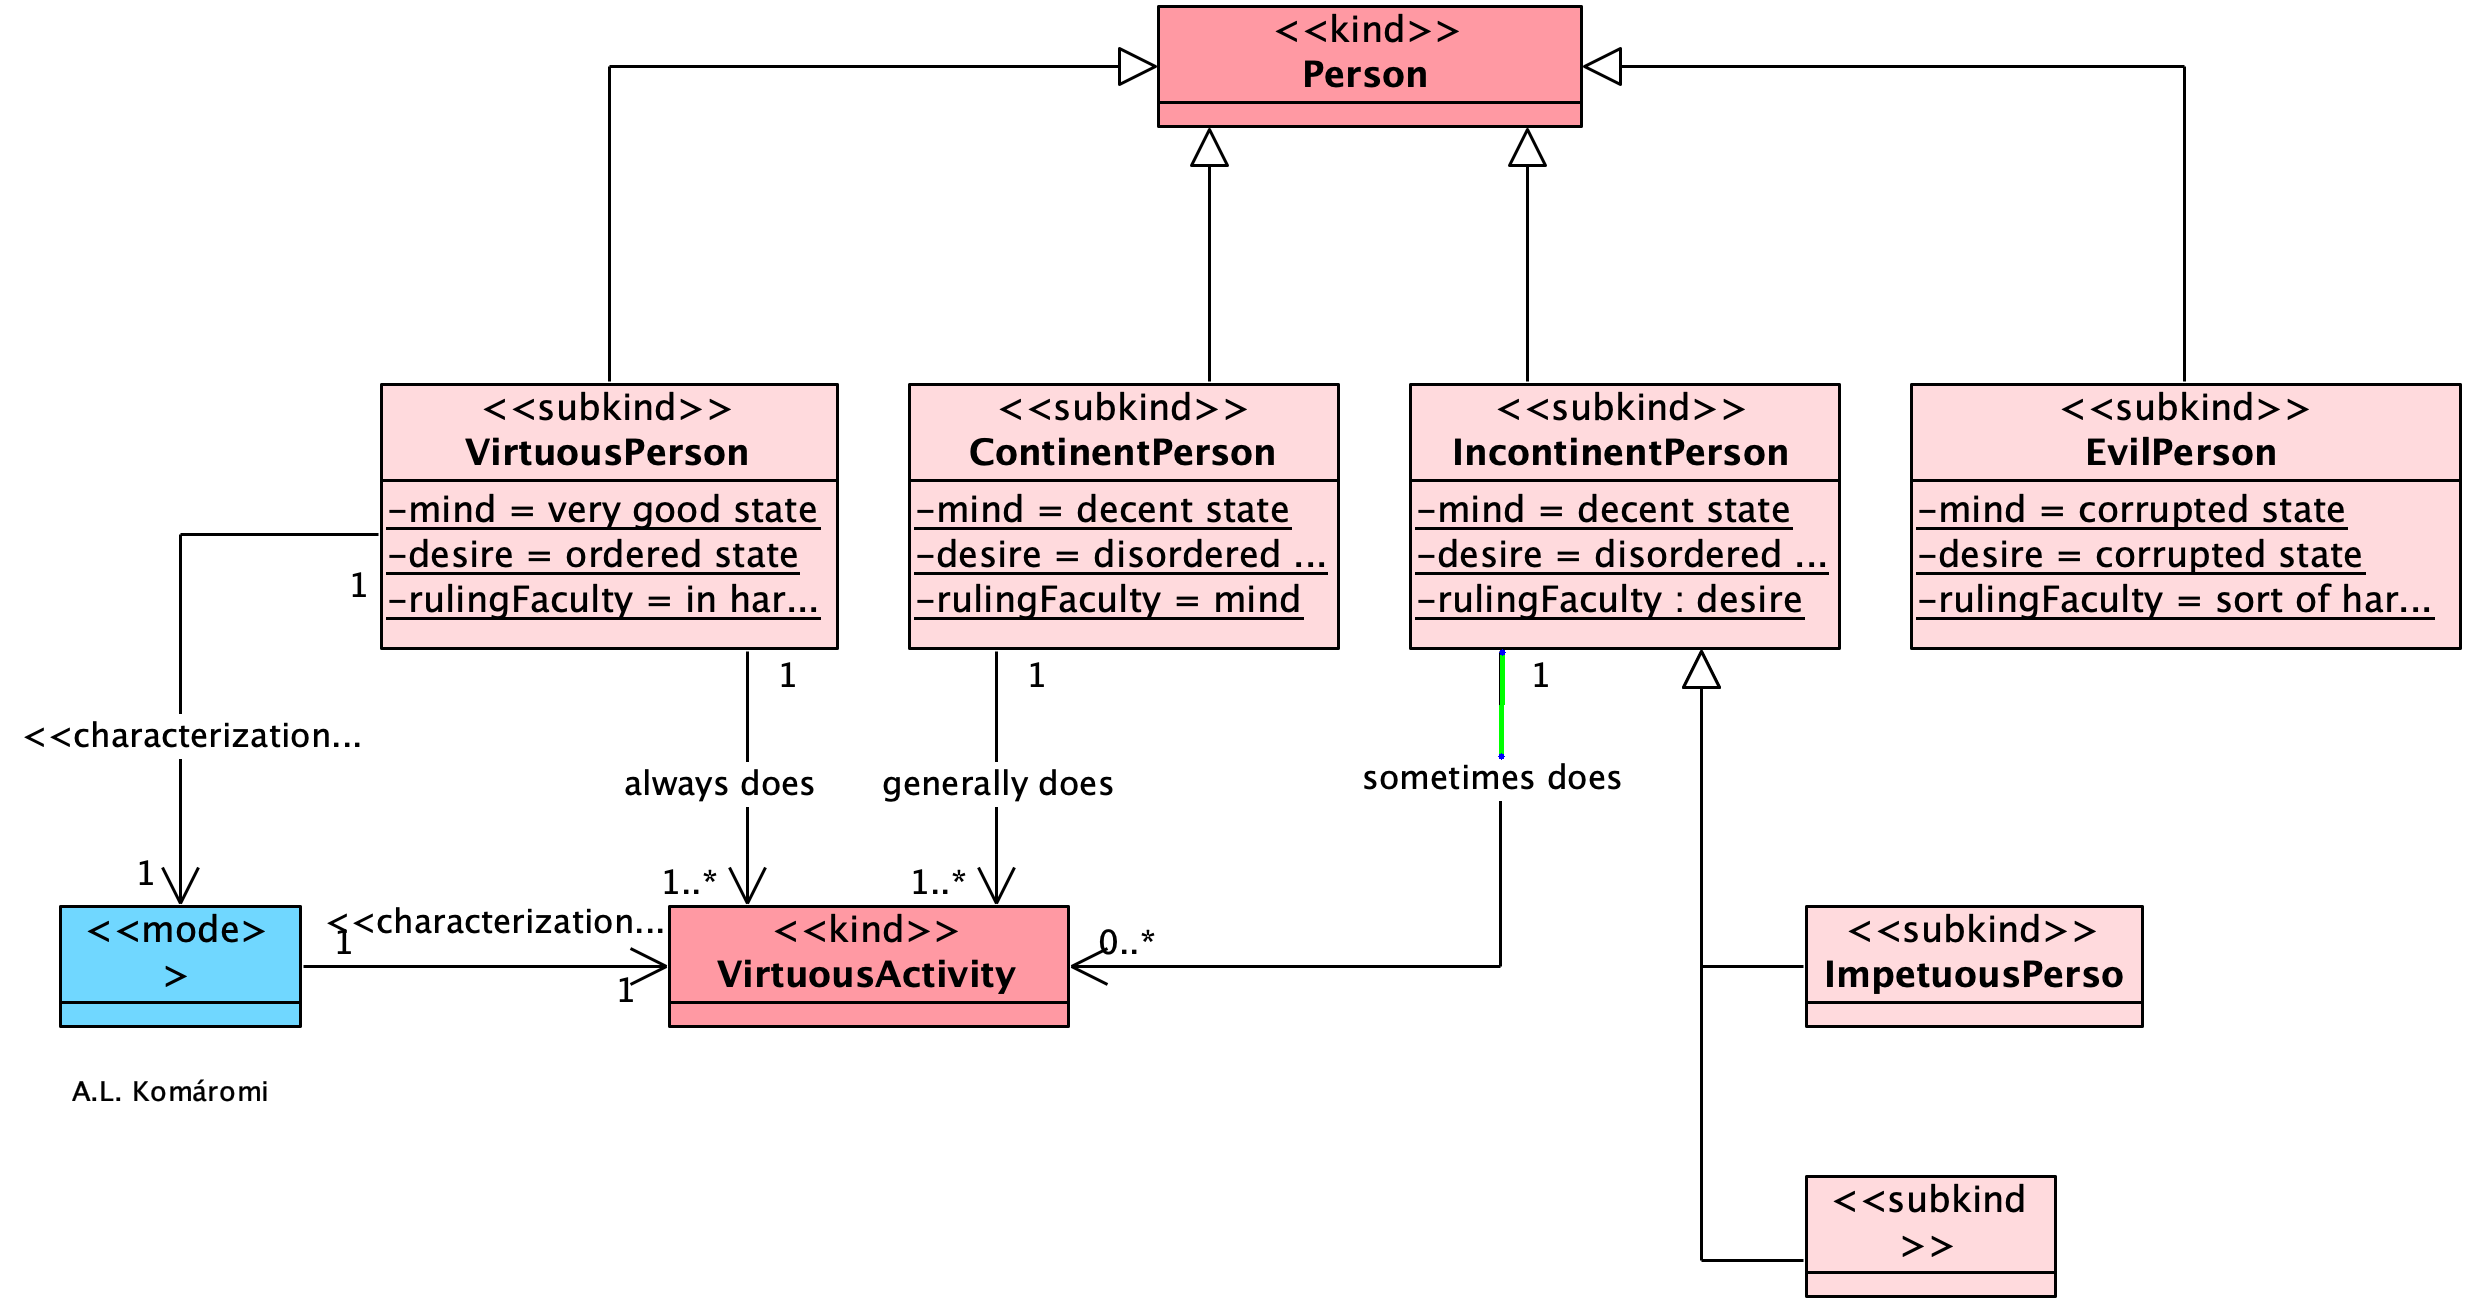



[(1, 2)]
line skipped


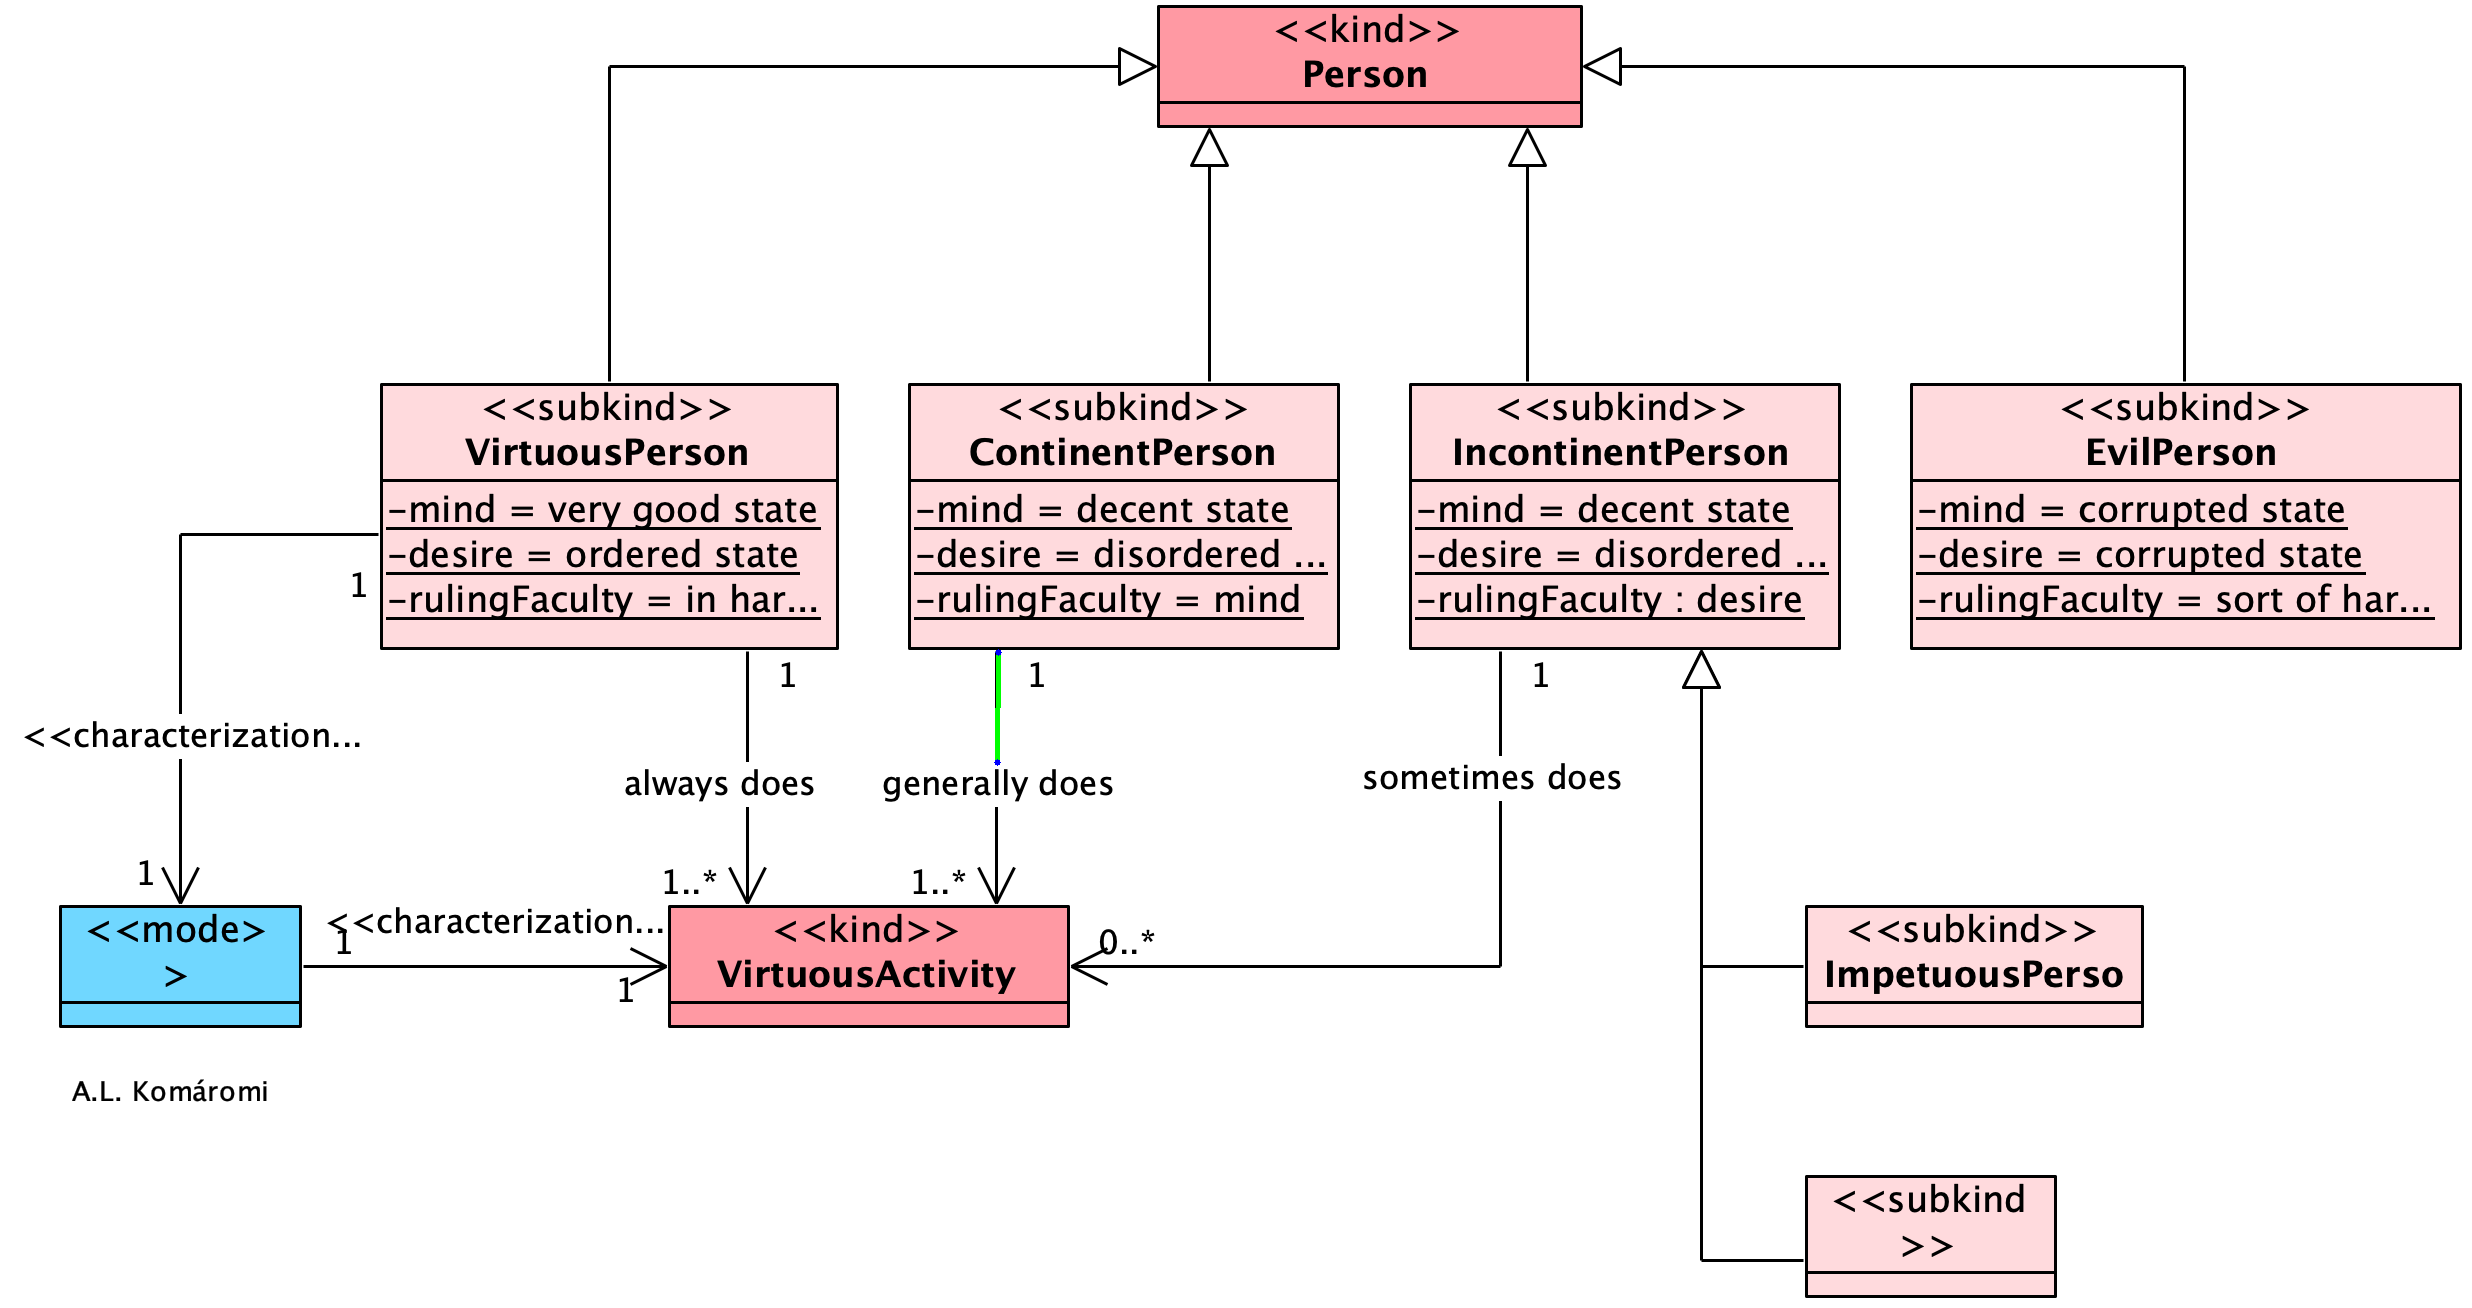



[(1, 2)]
line skipped


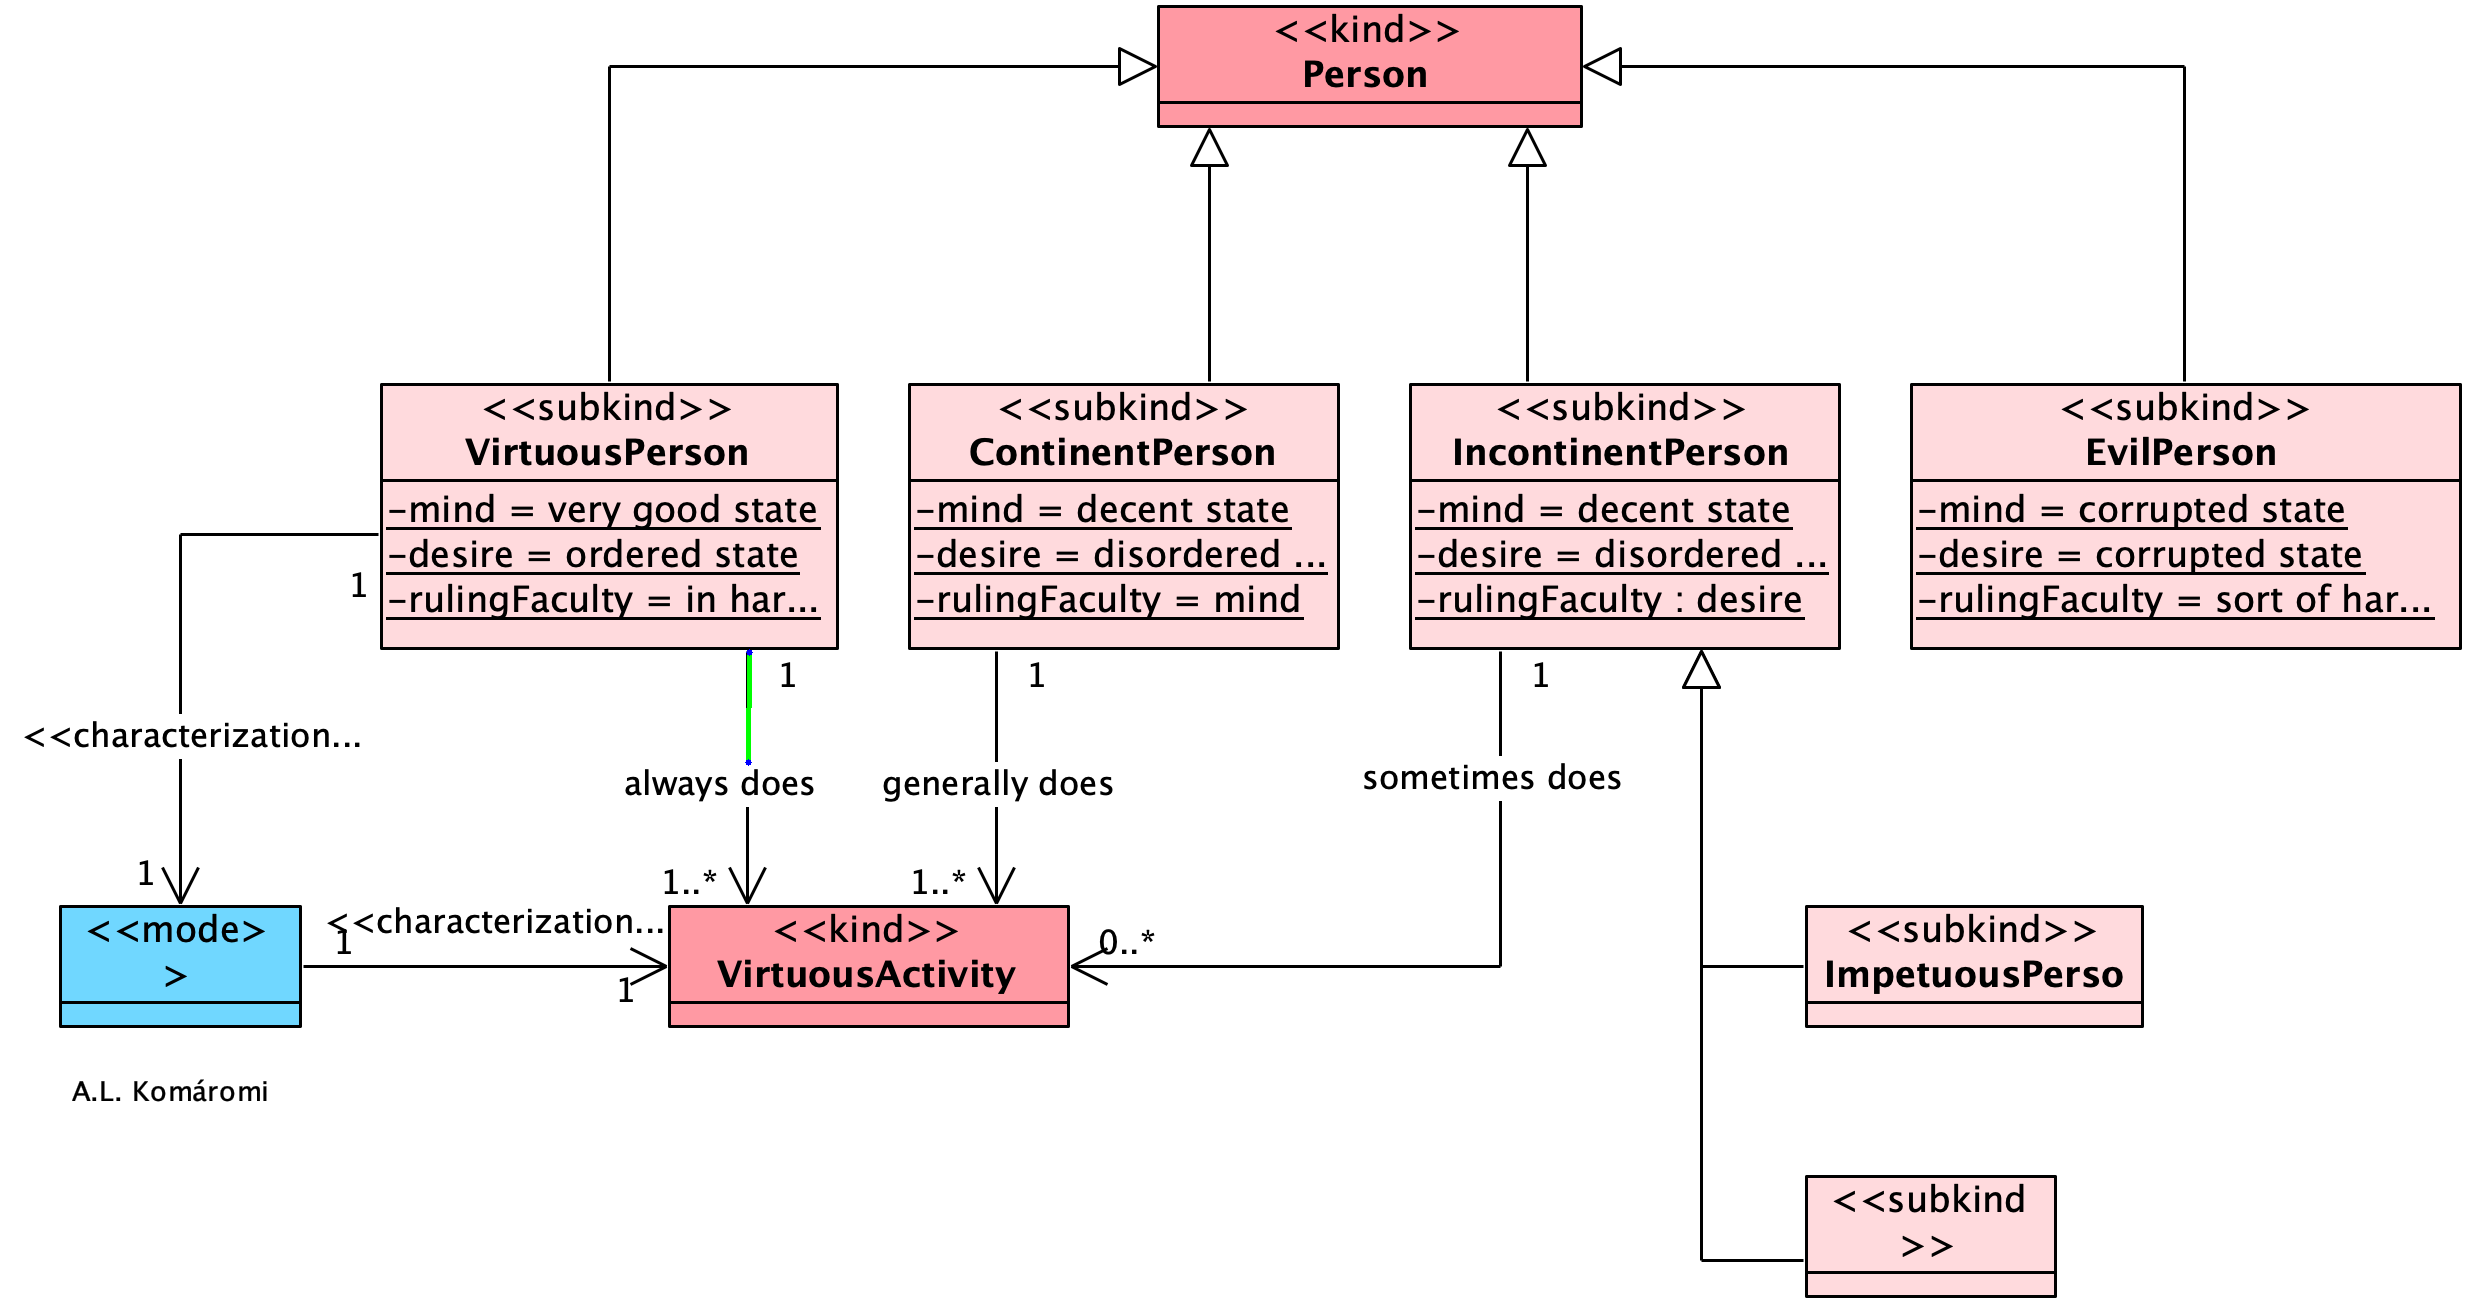



[(2, 8), (3, 4), (5, 8), (6, 7)]


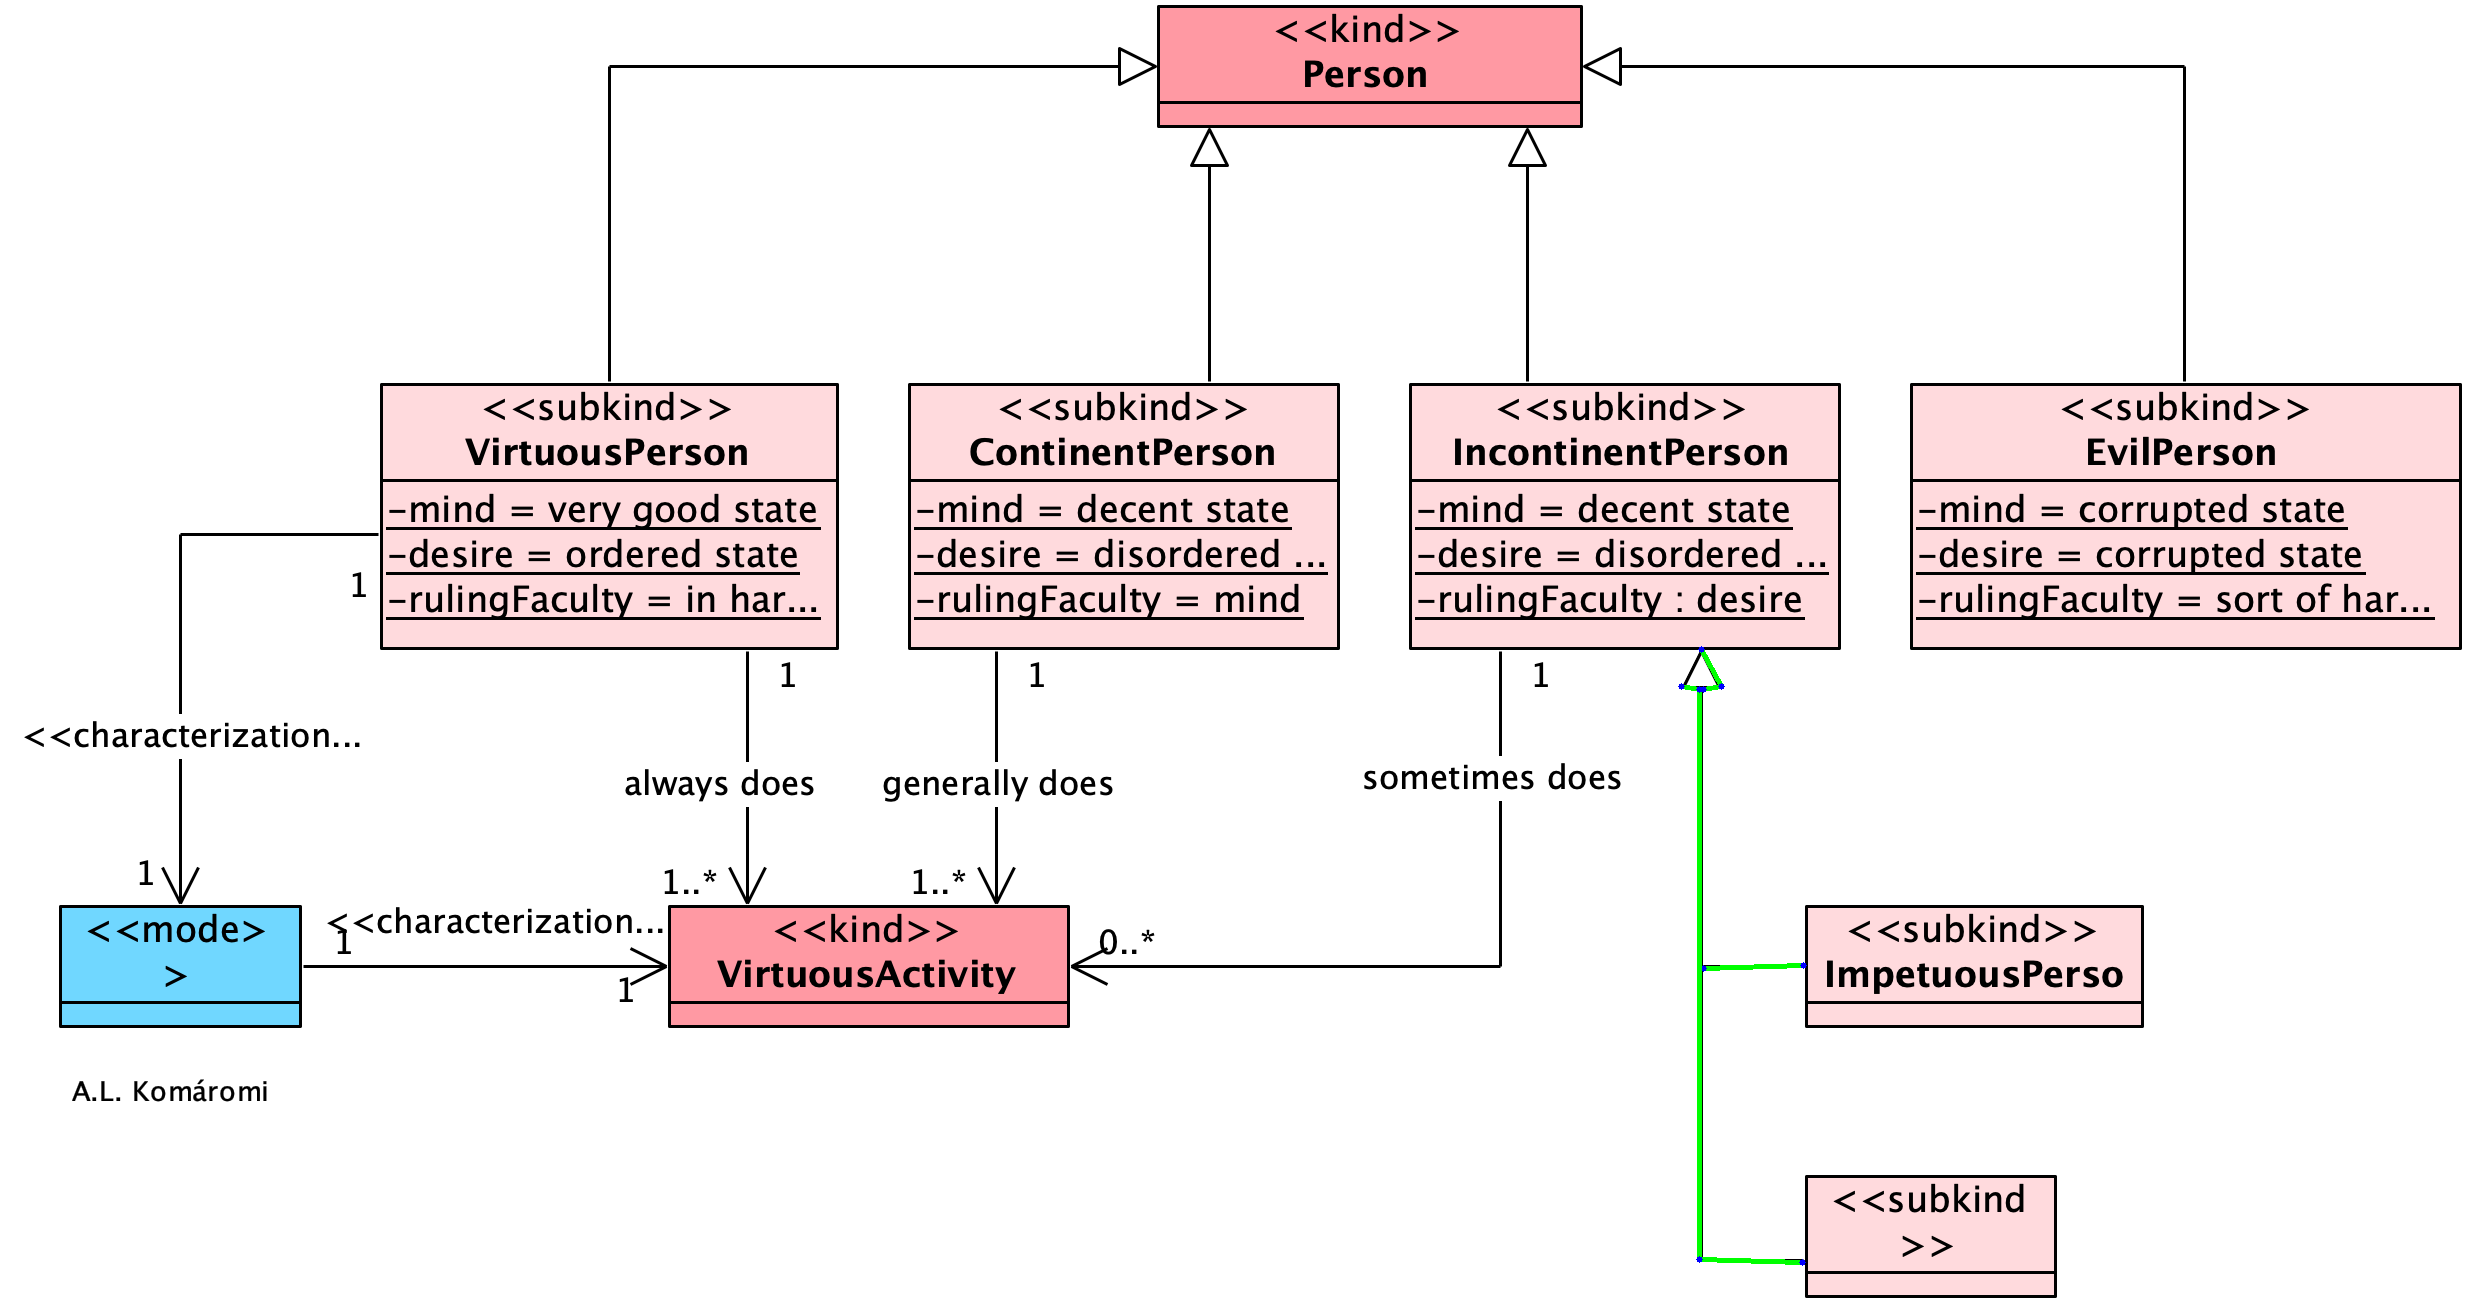



[(1, 2)]


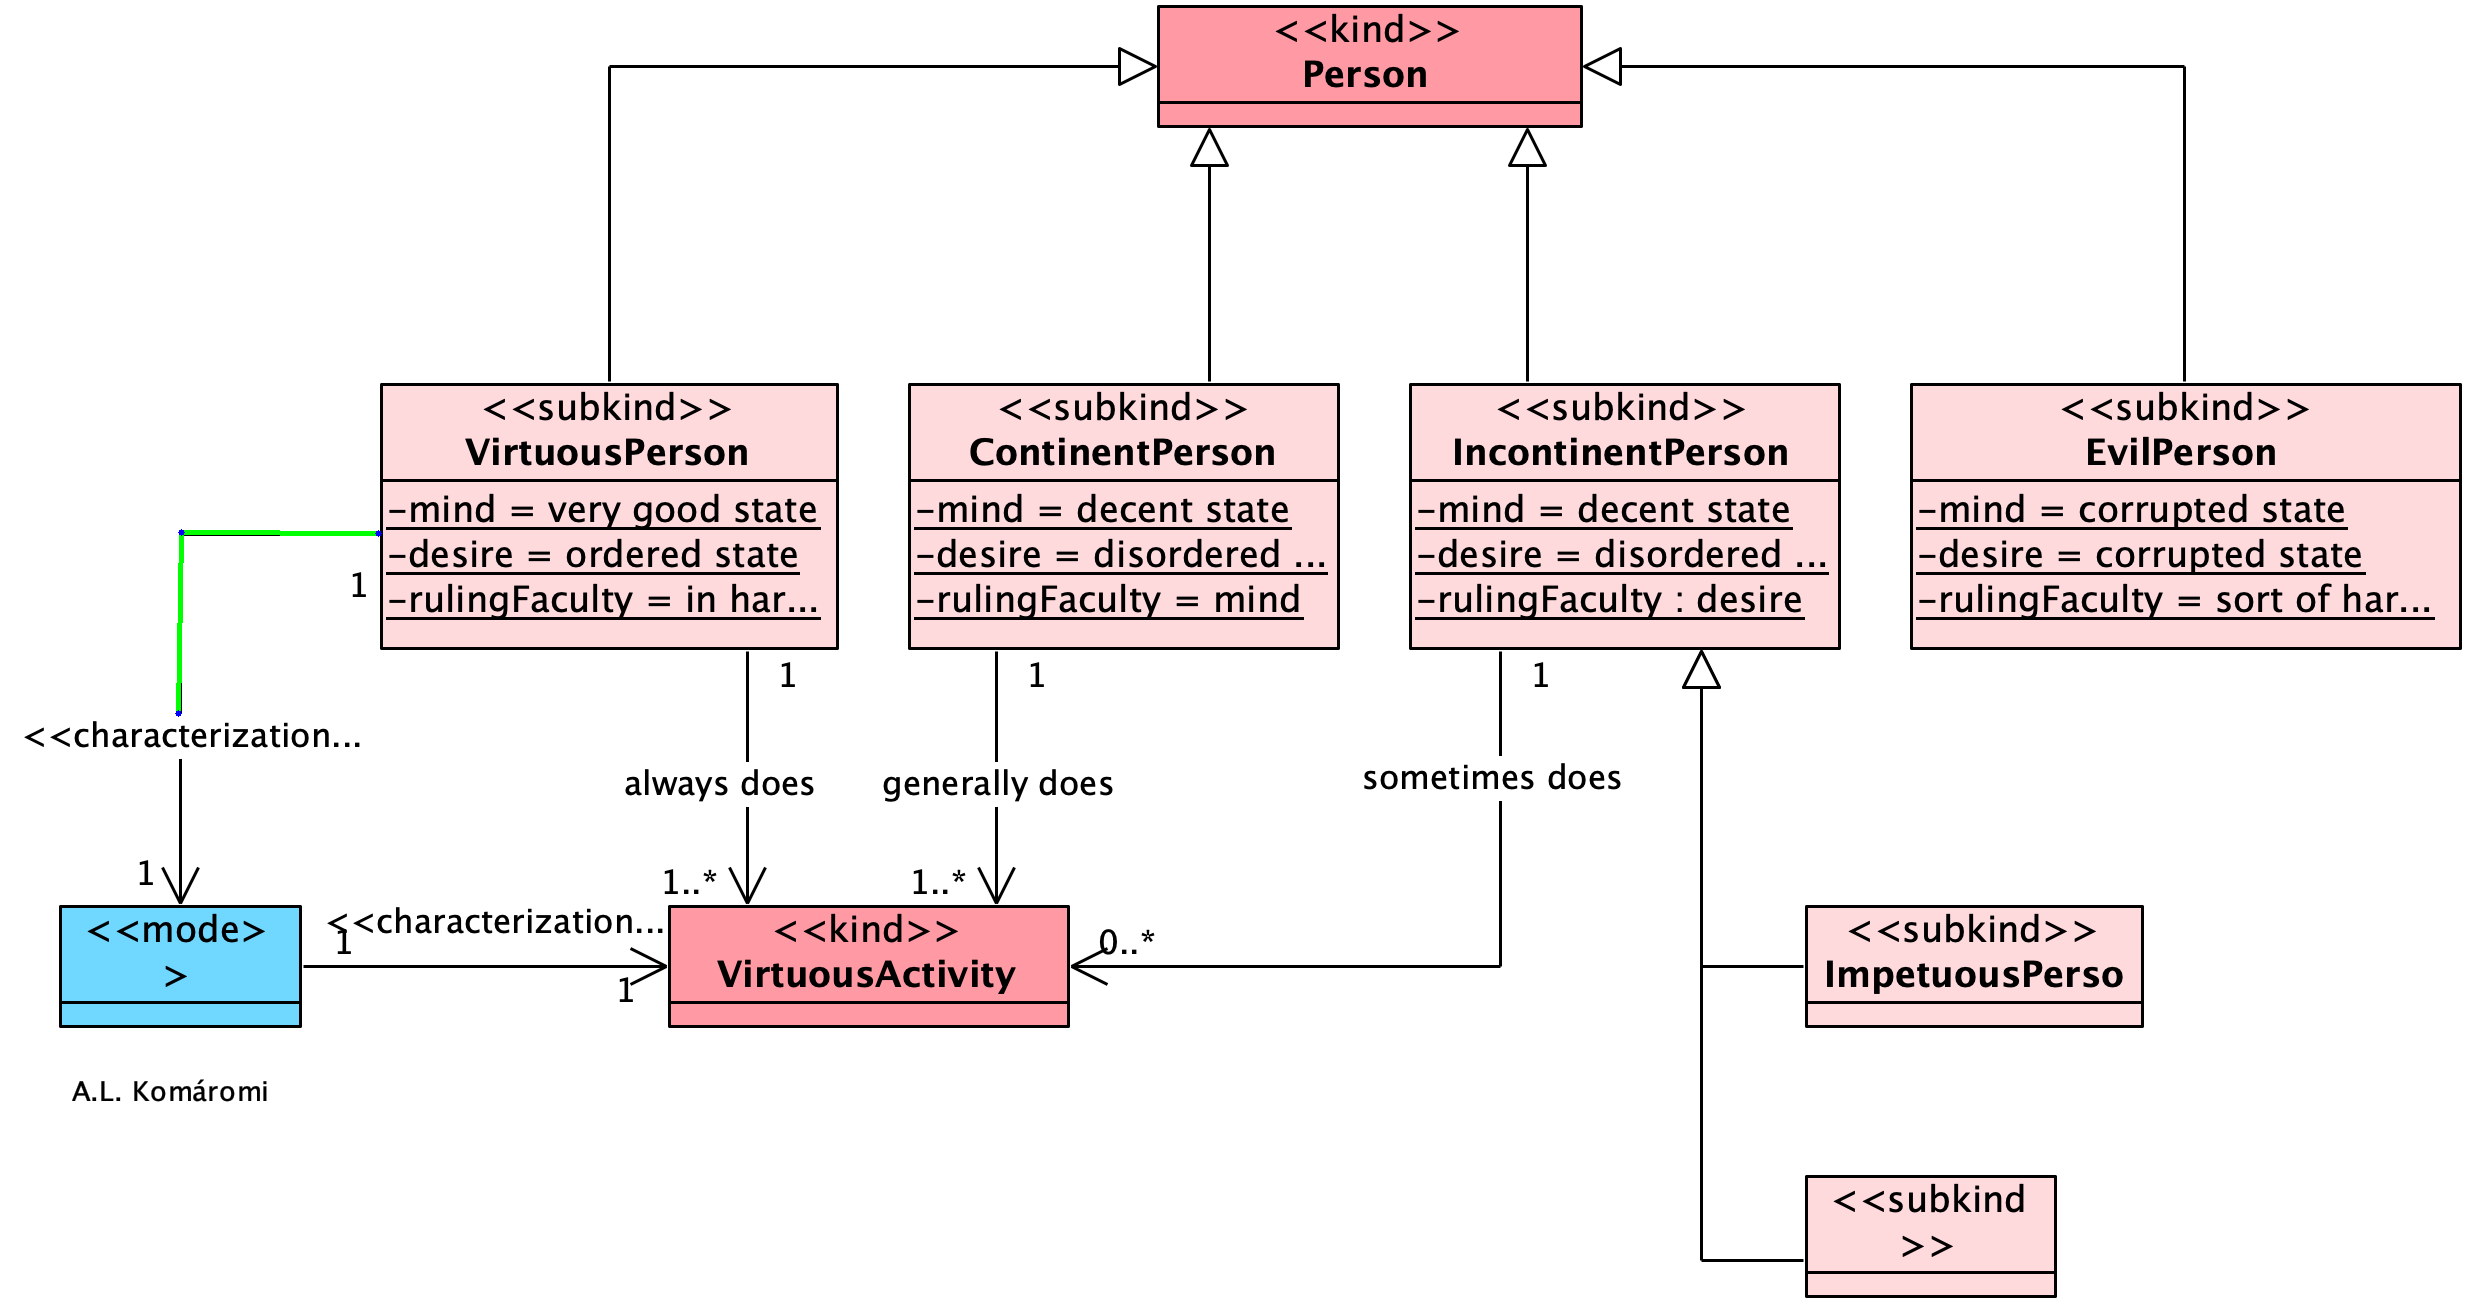



[]


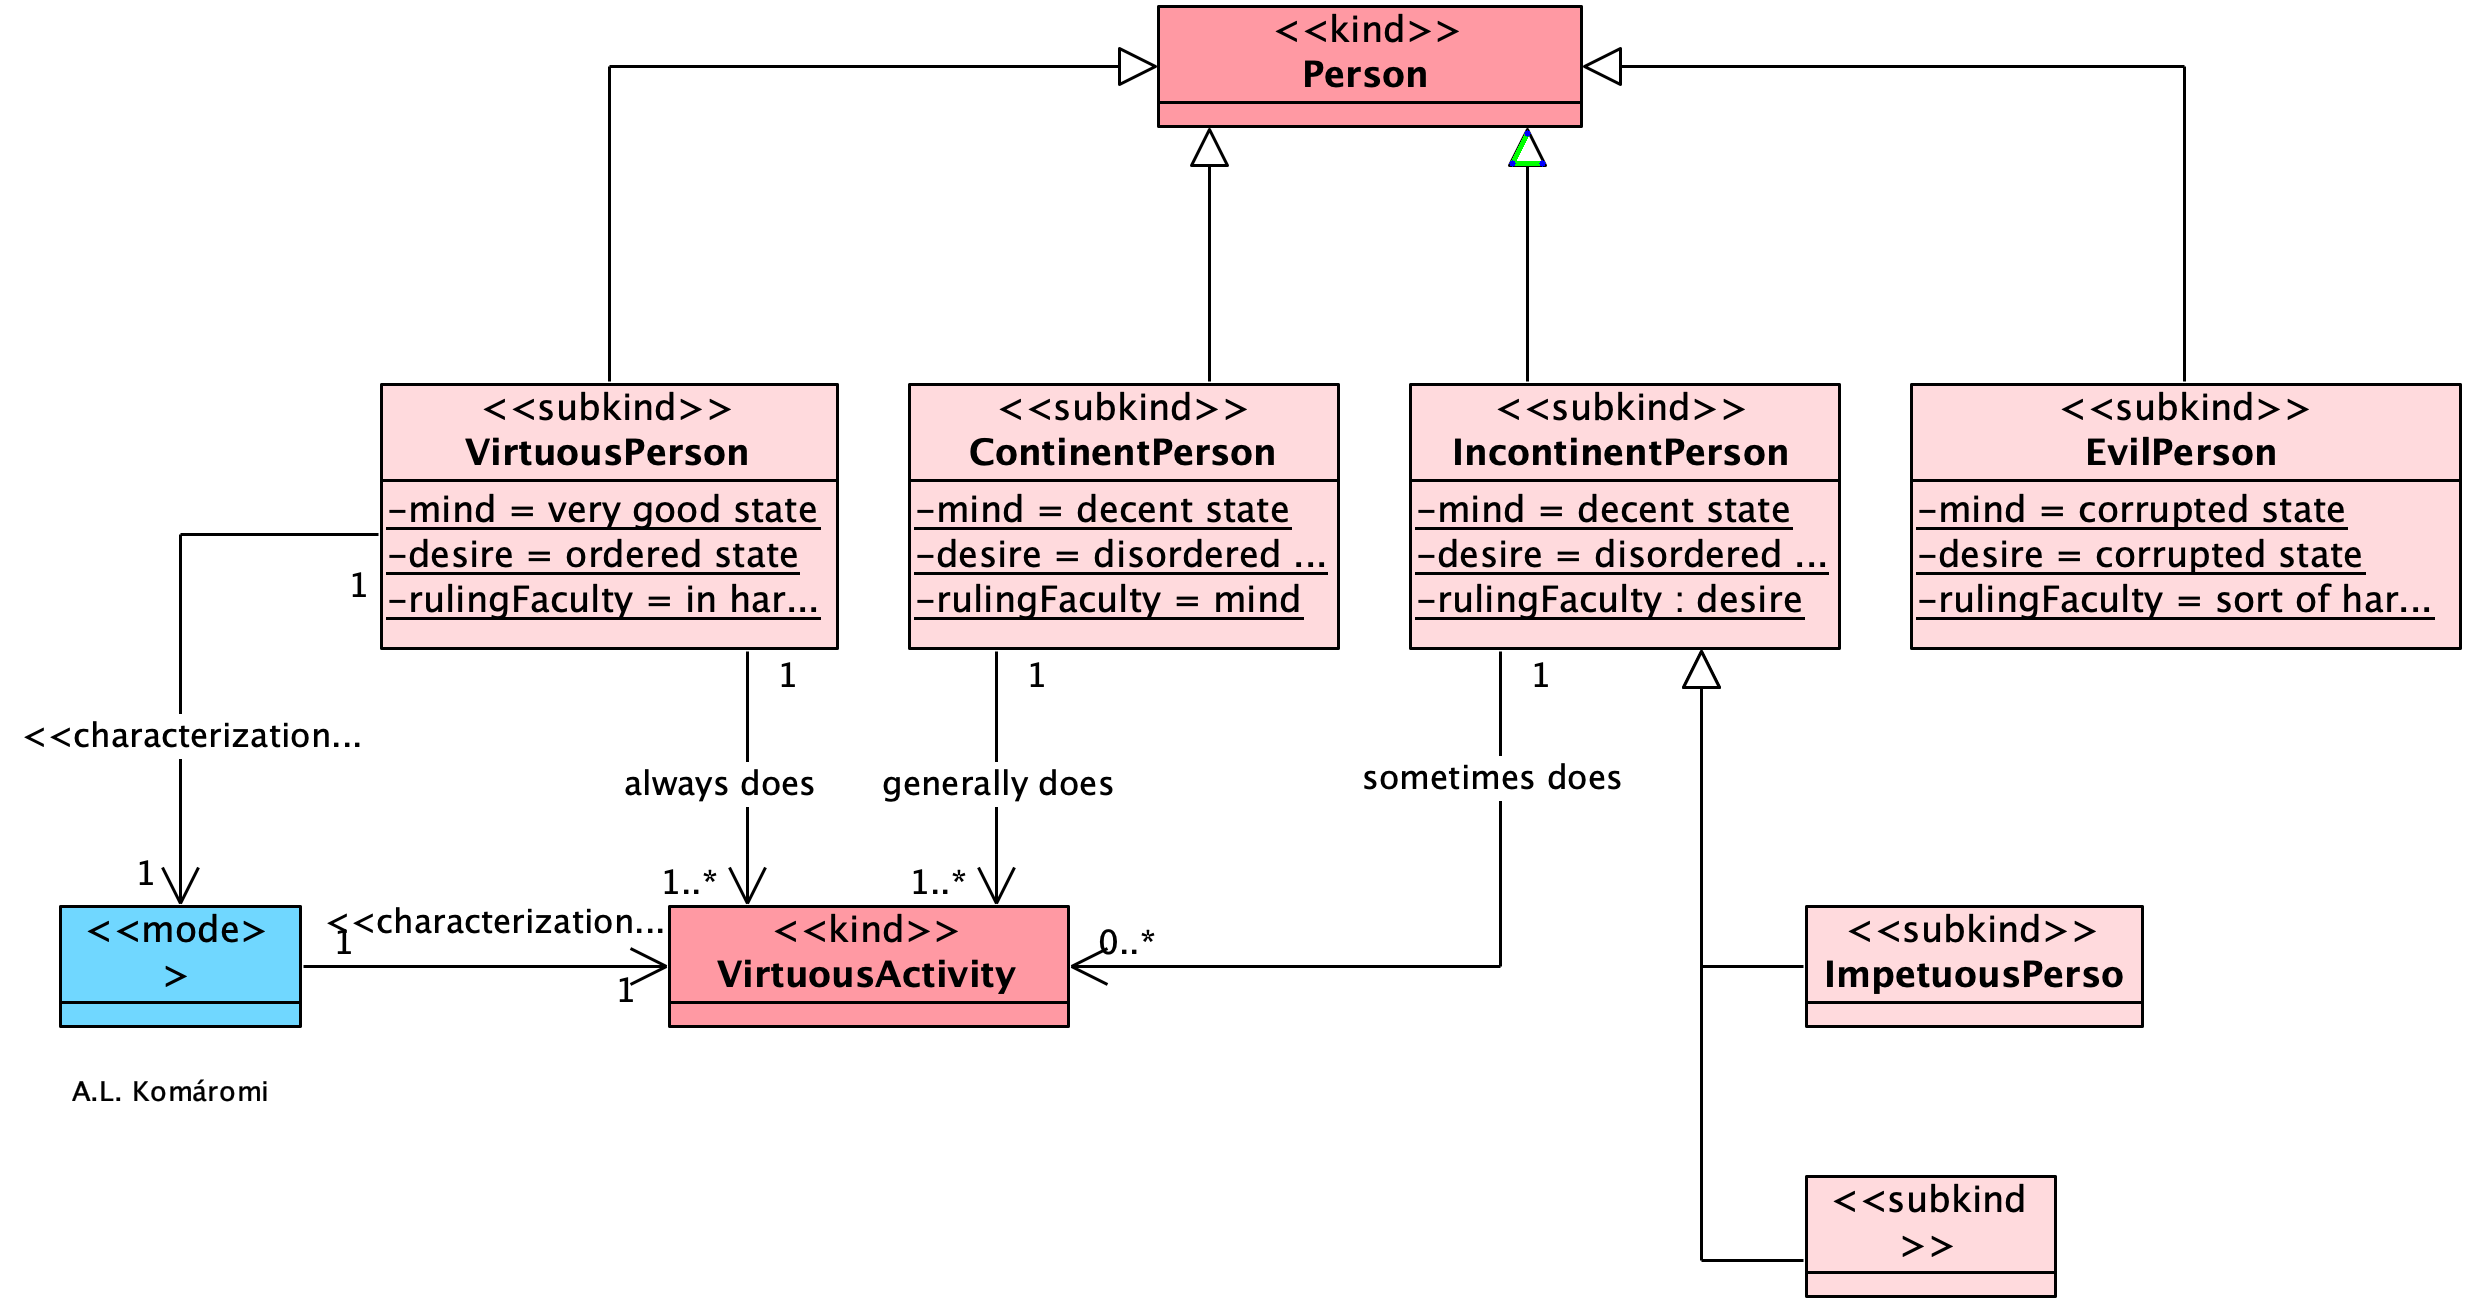



[]


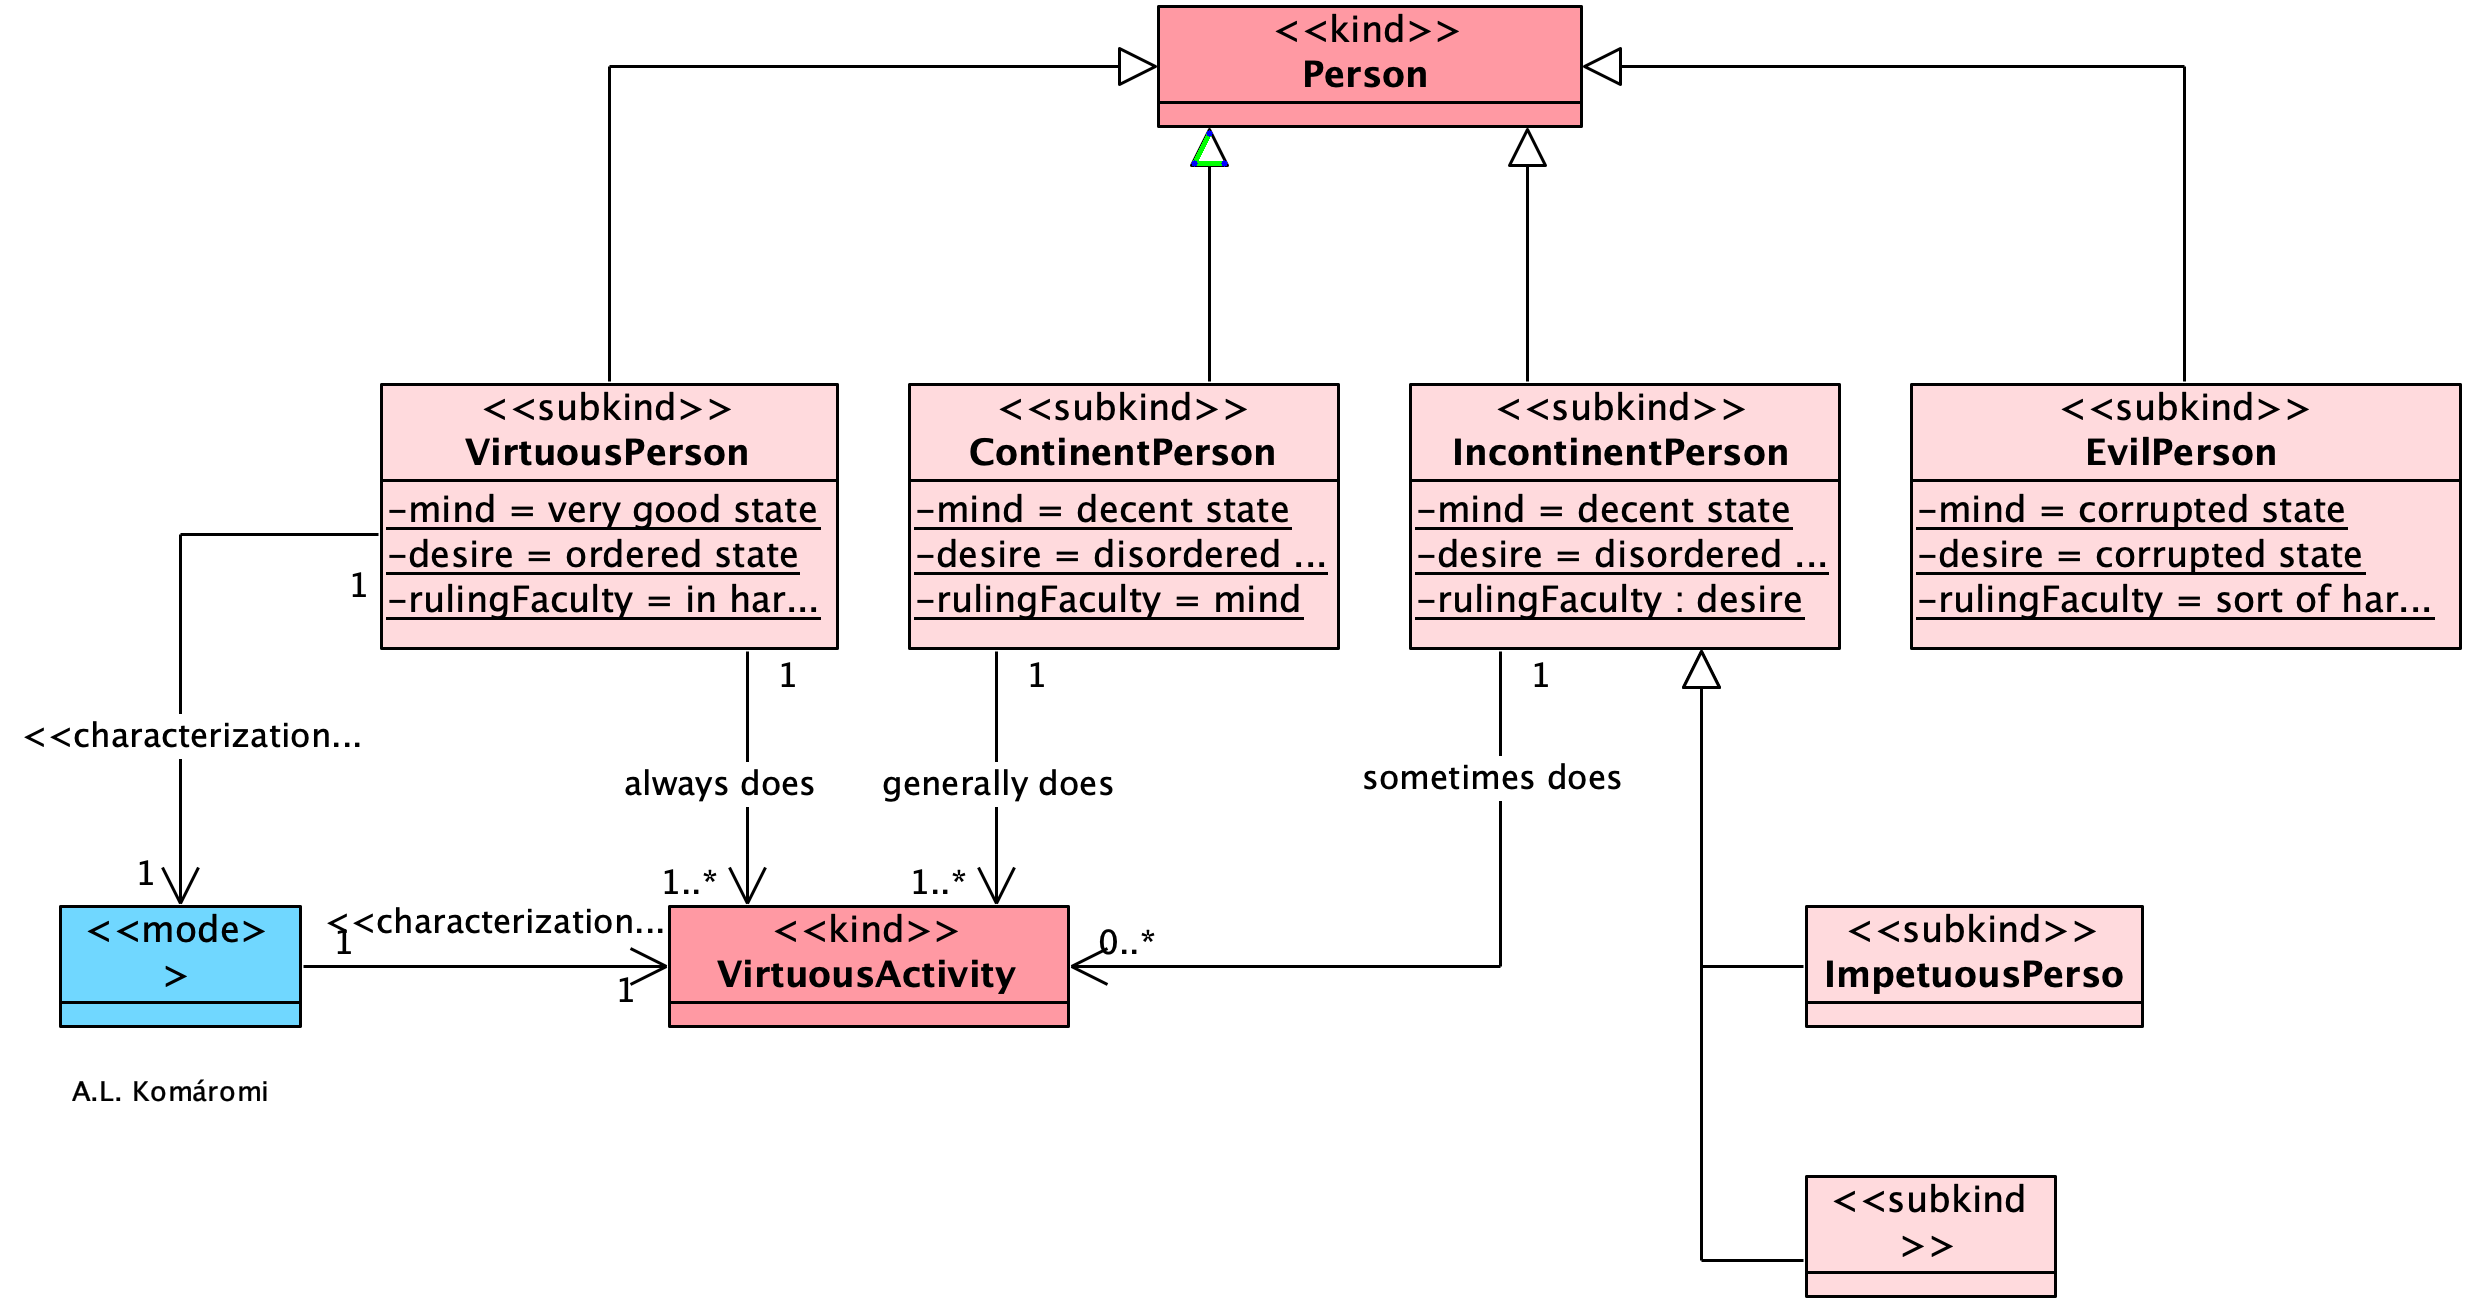



[(2, 3)]


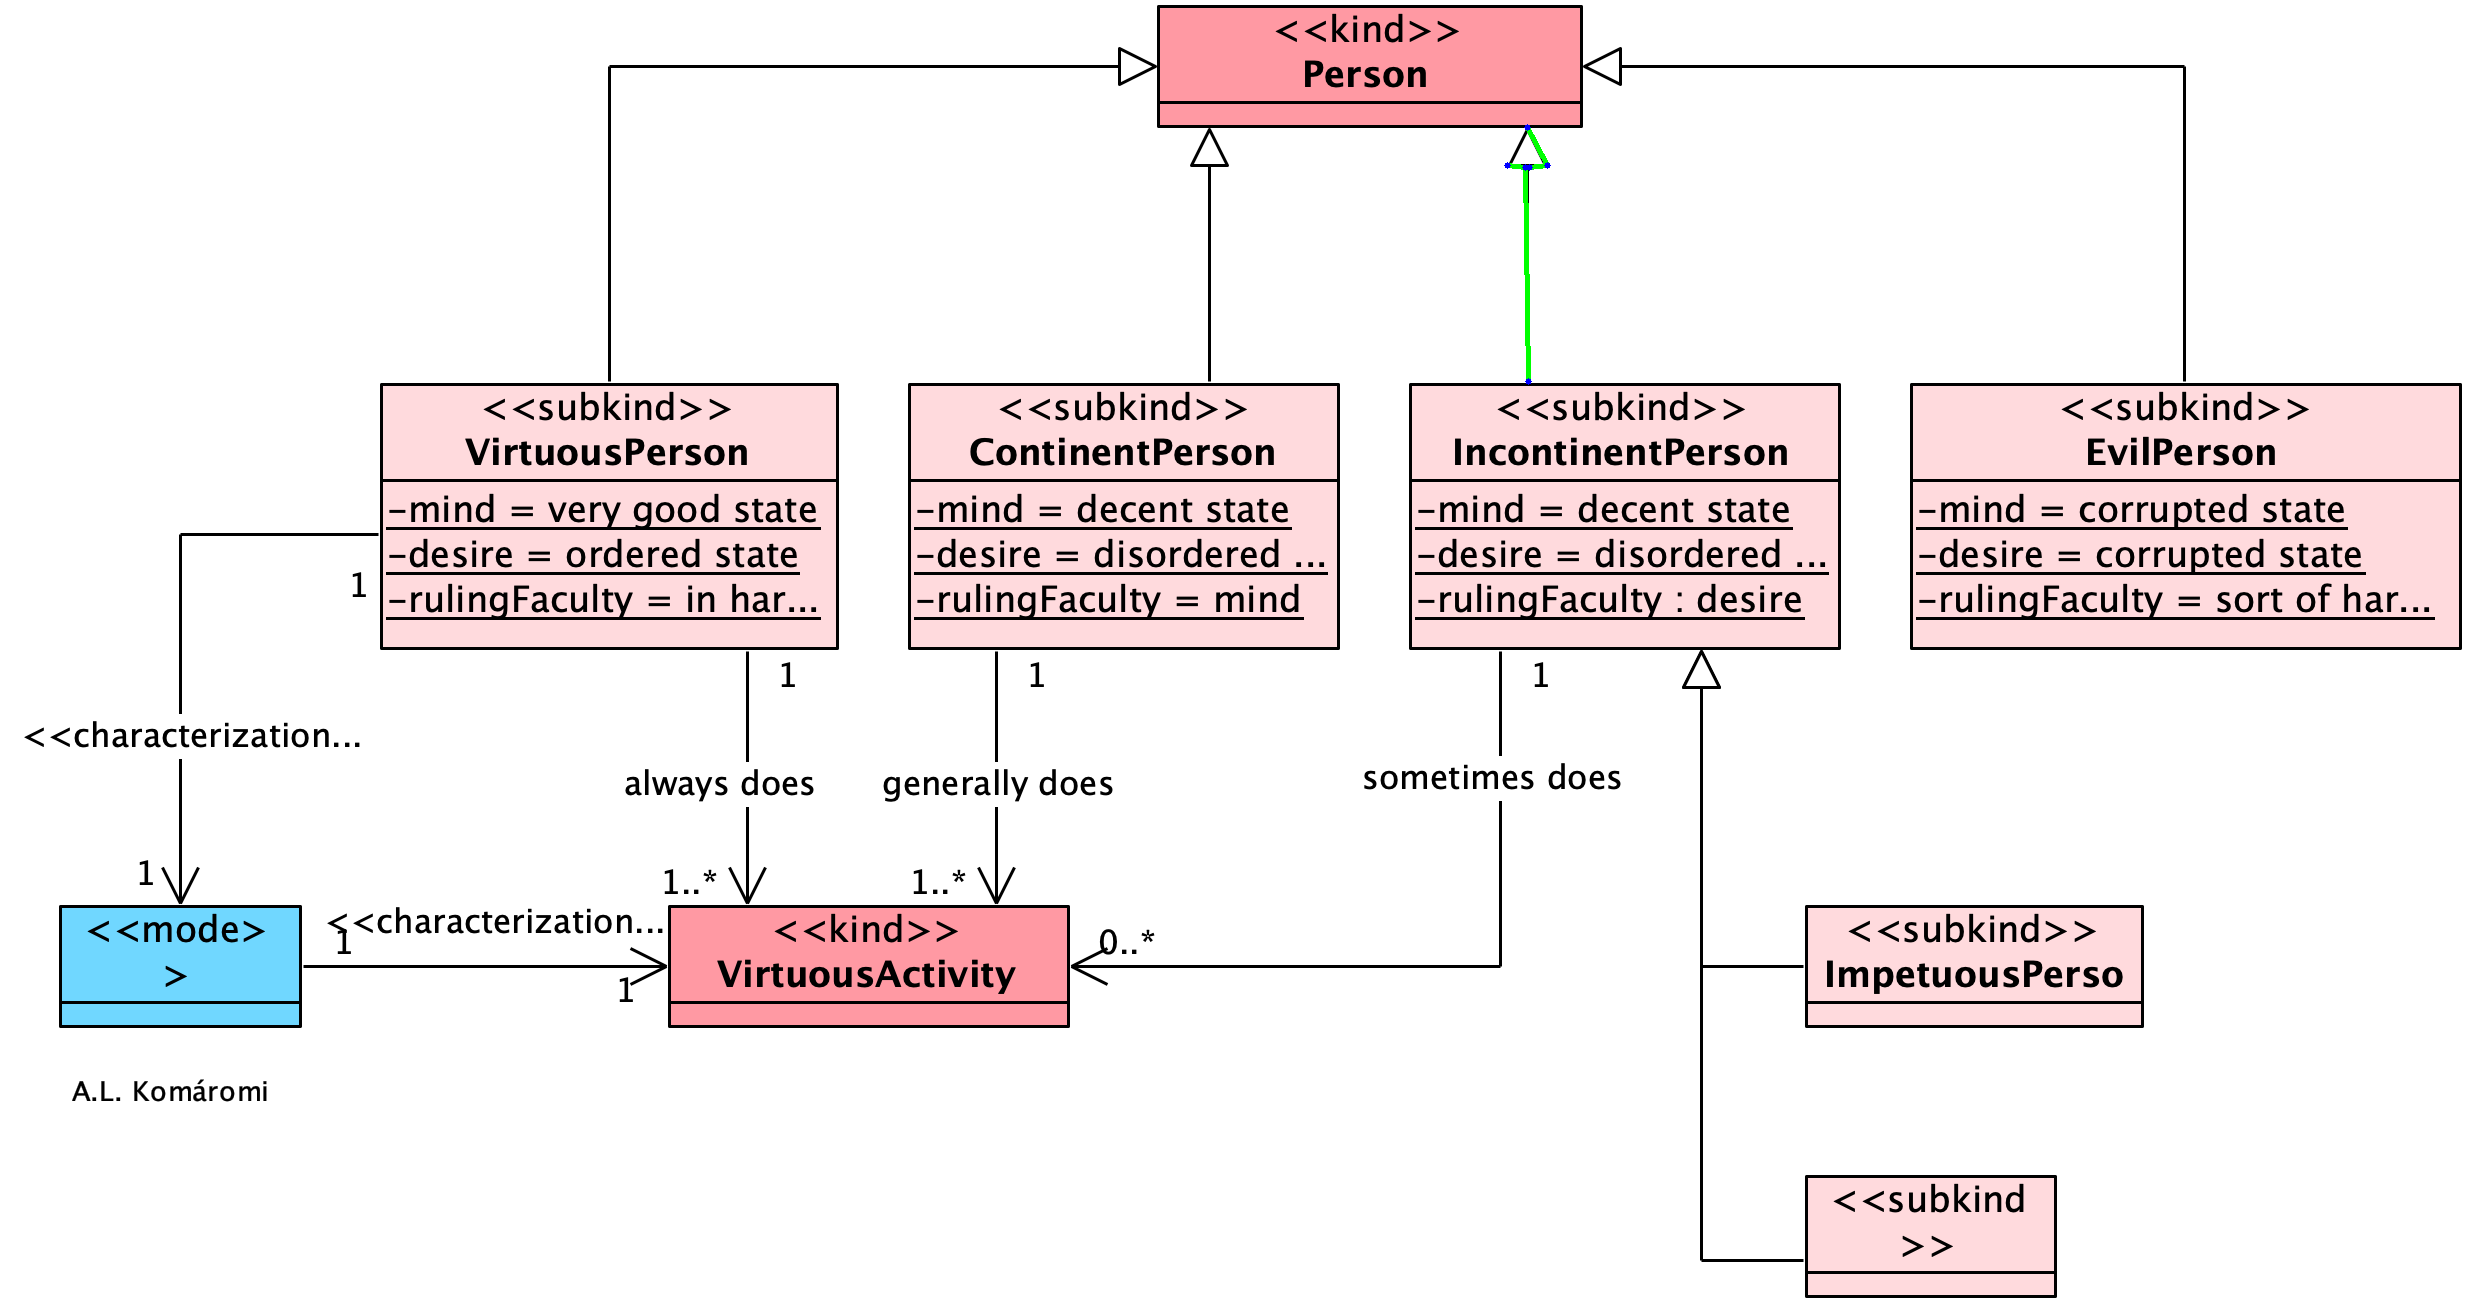



[(2, 3)]


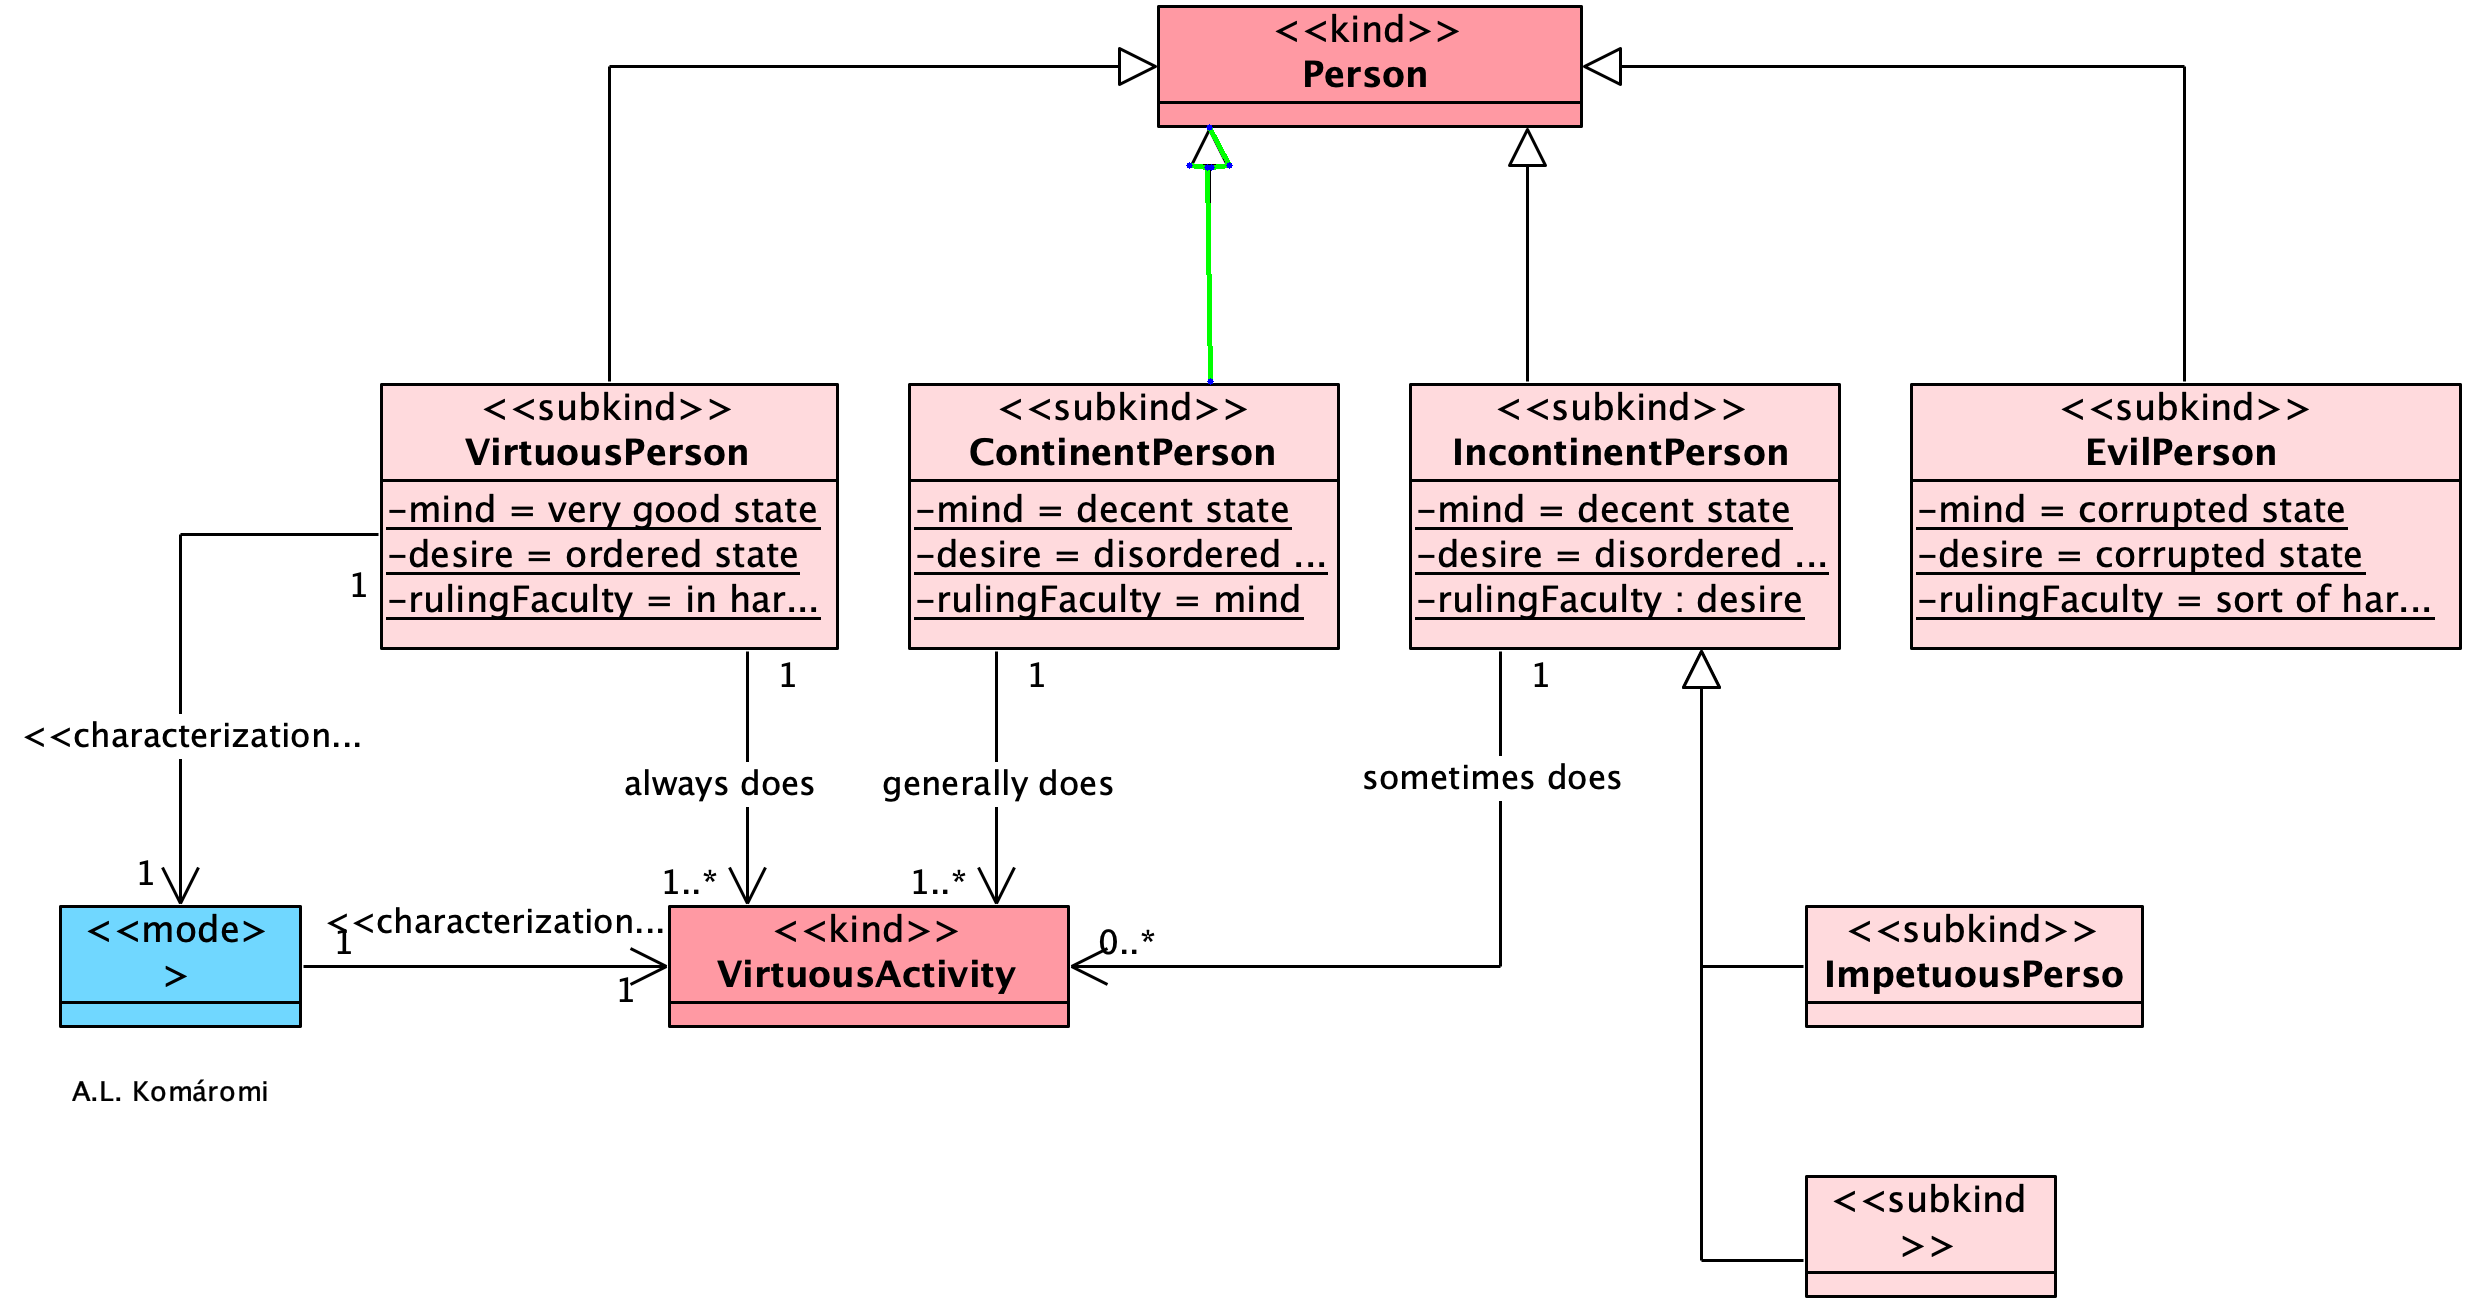



[]


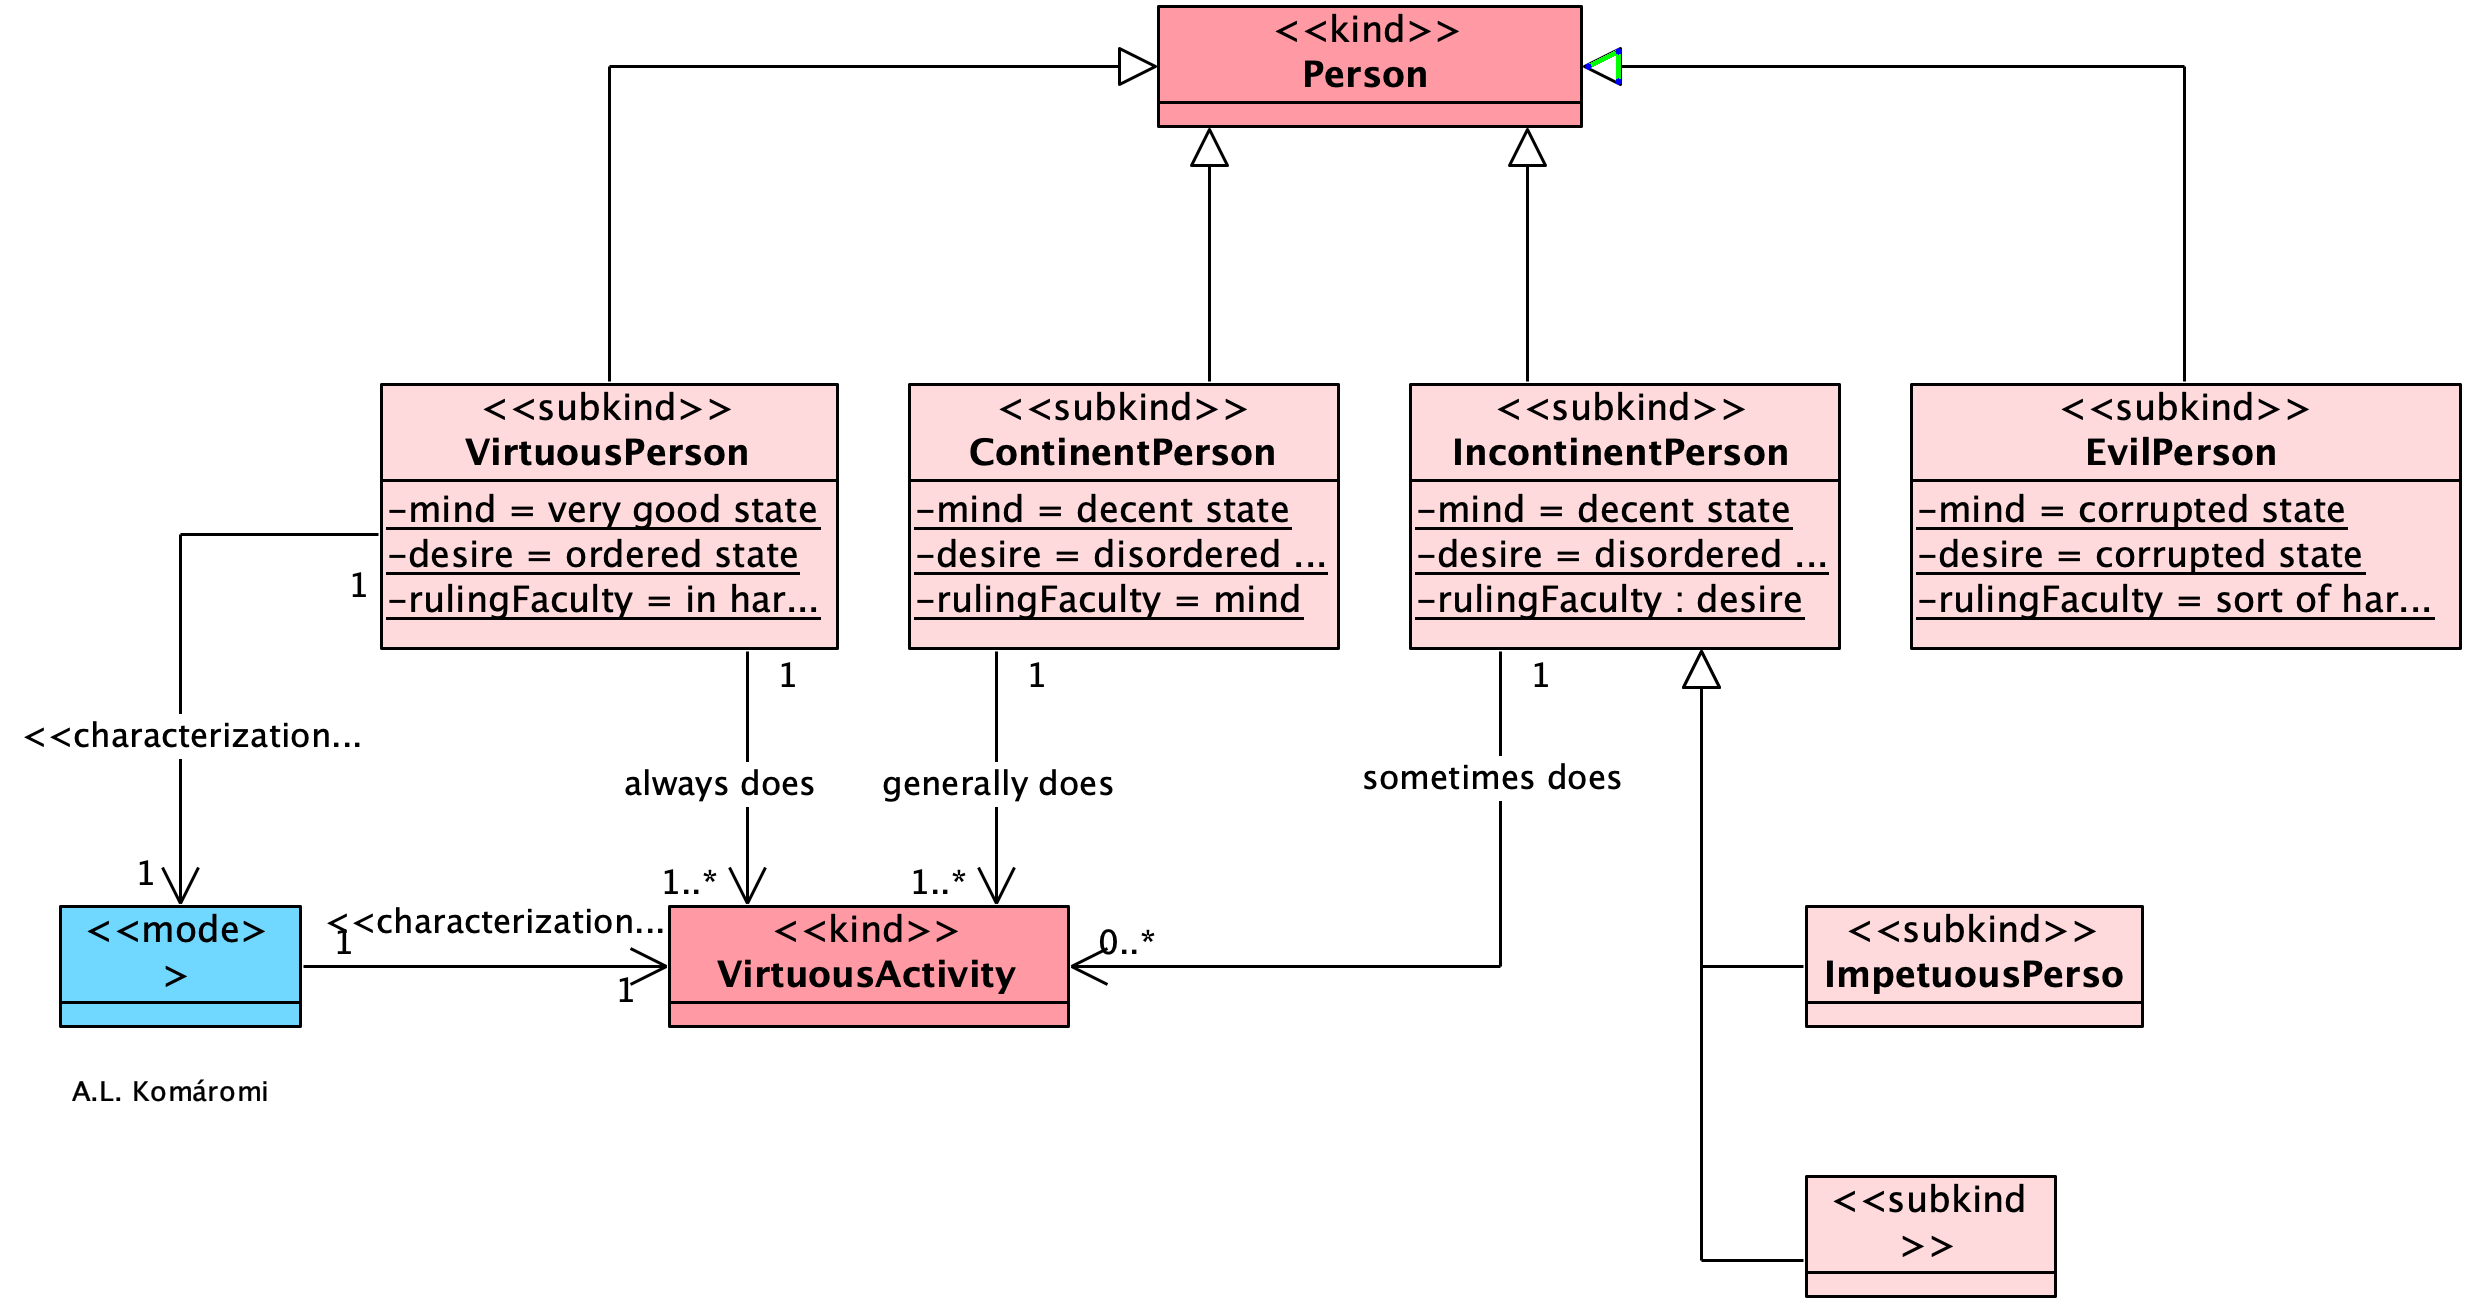



[]


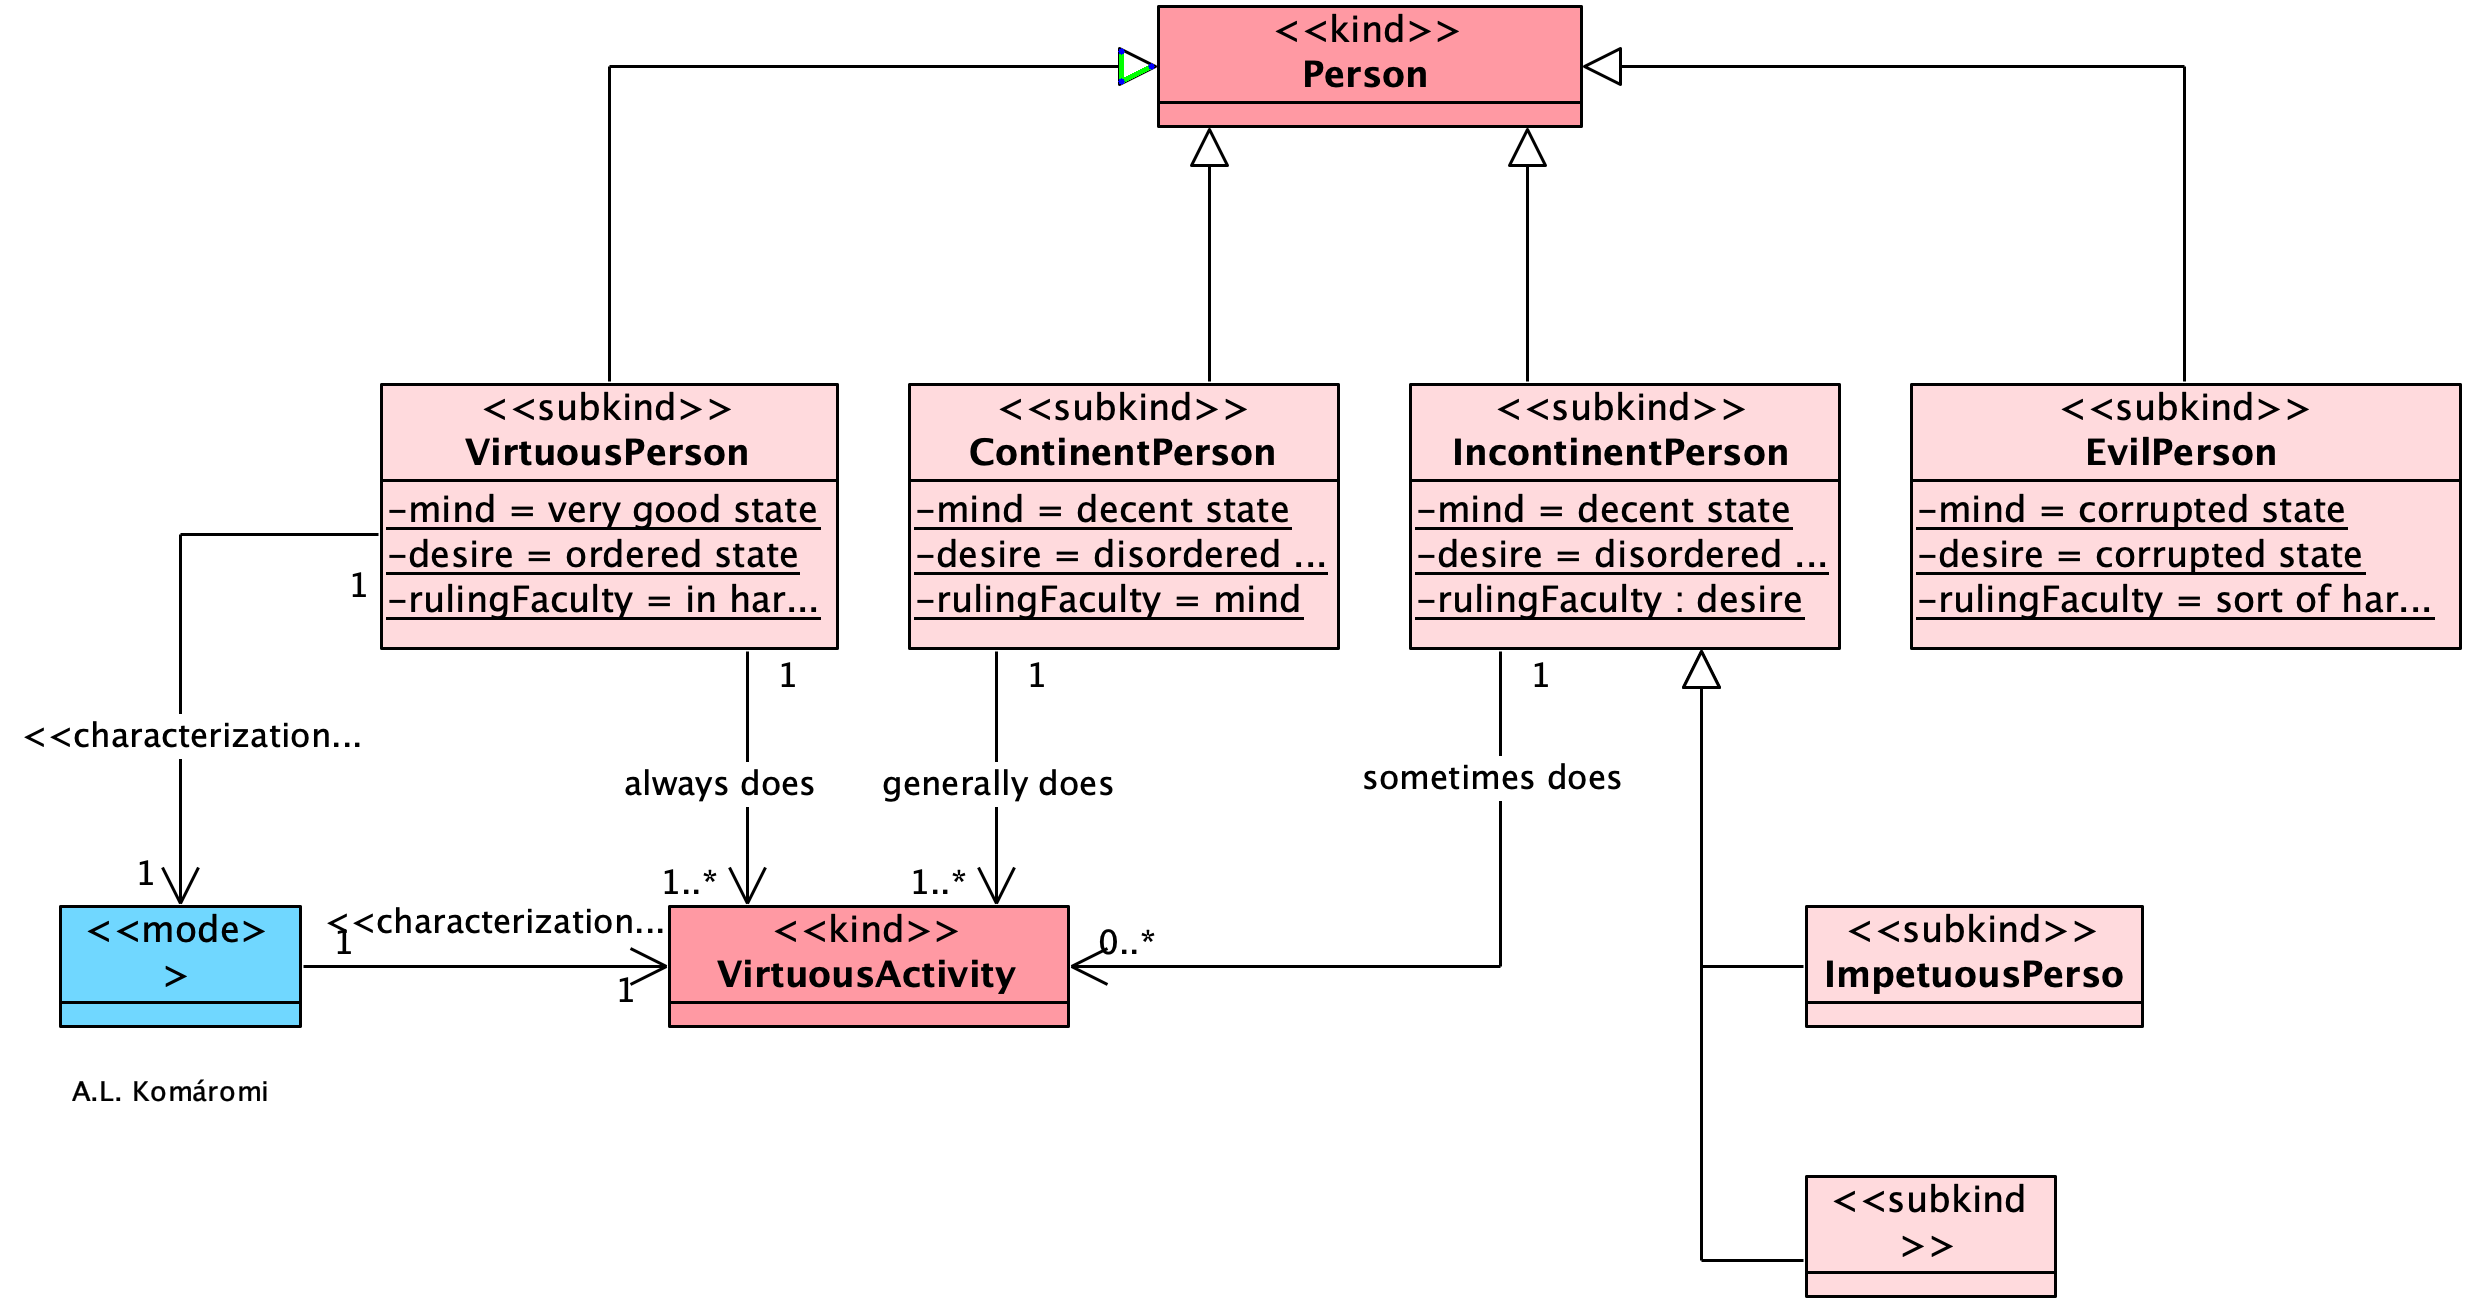



[(2, 3)]


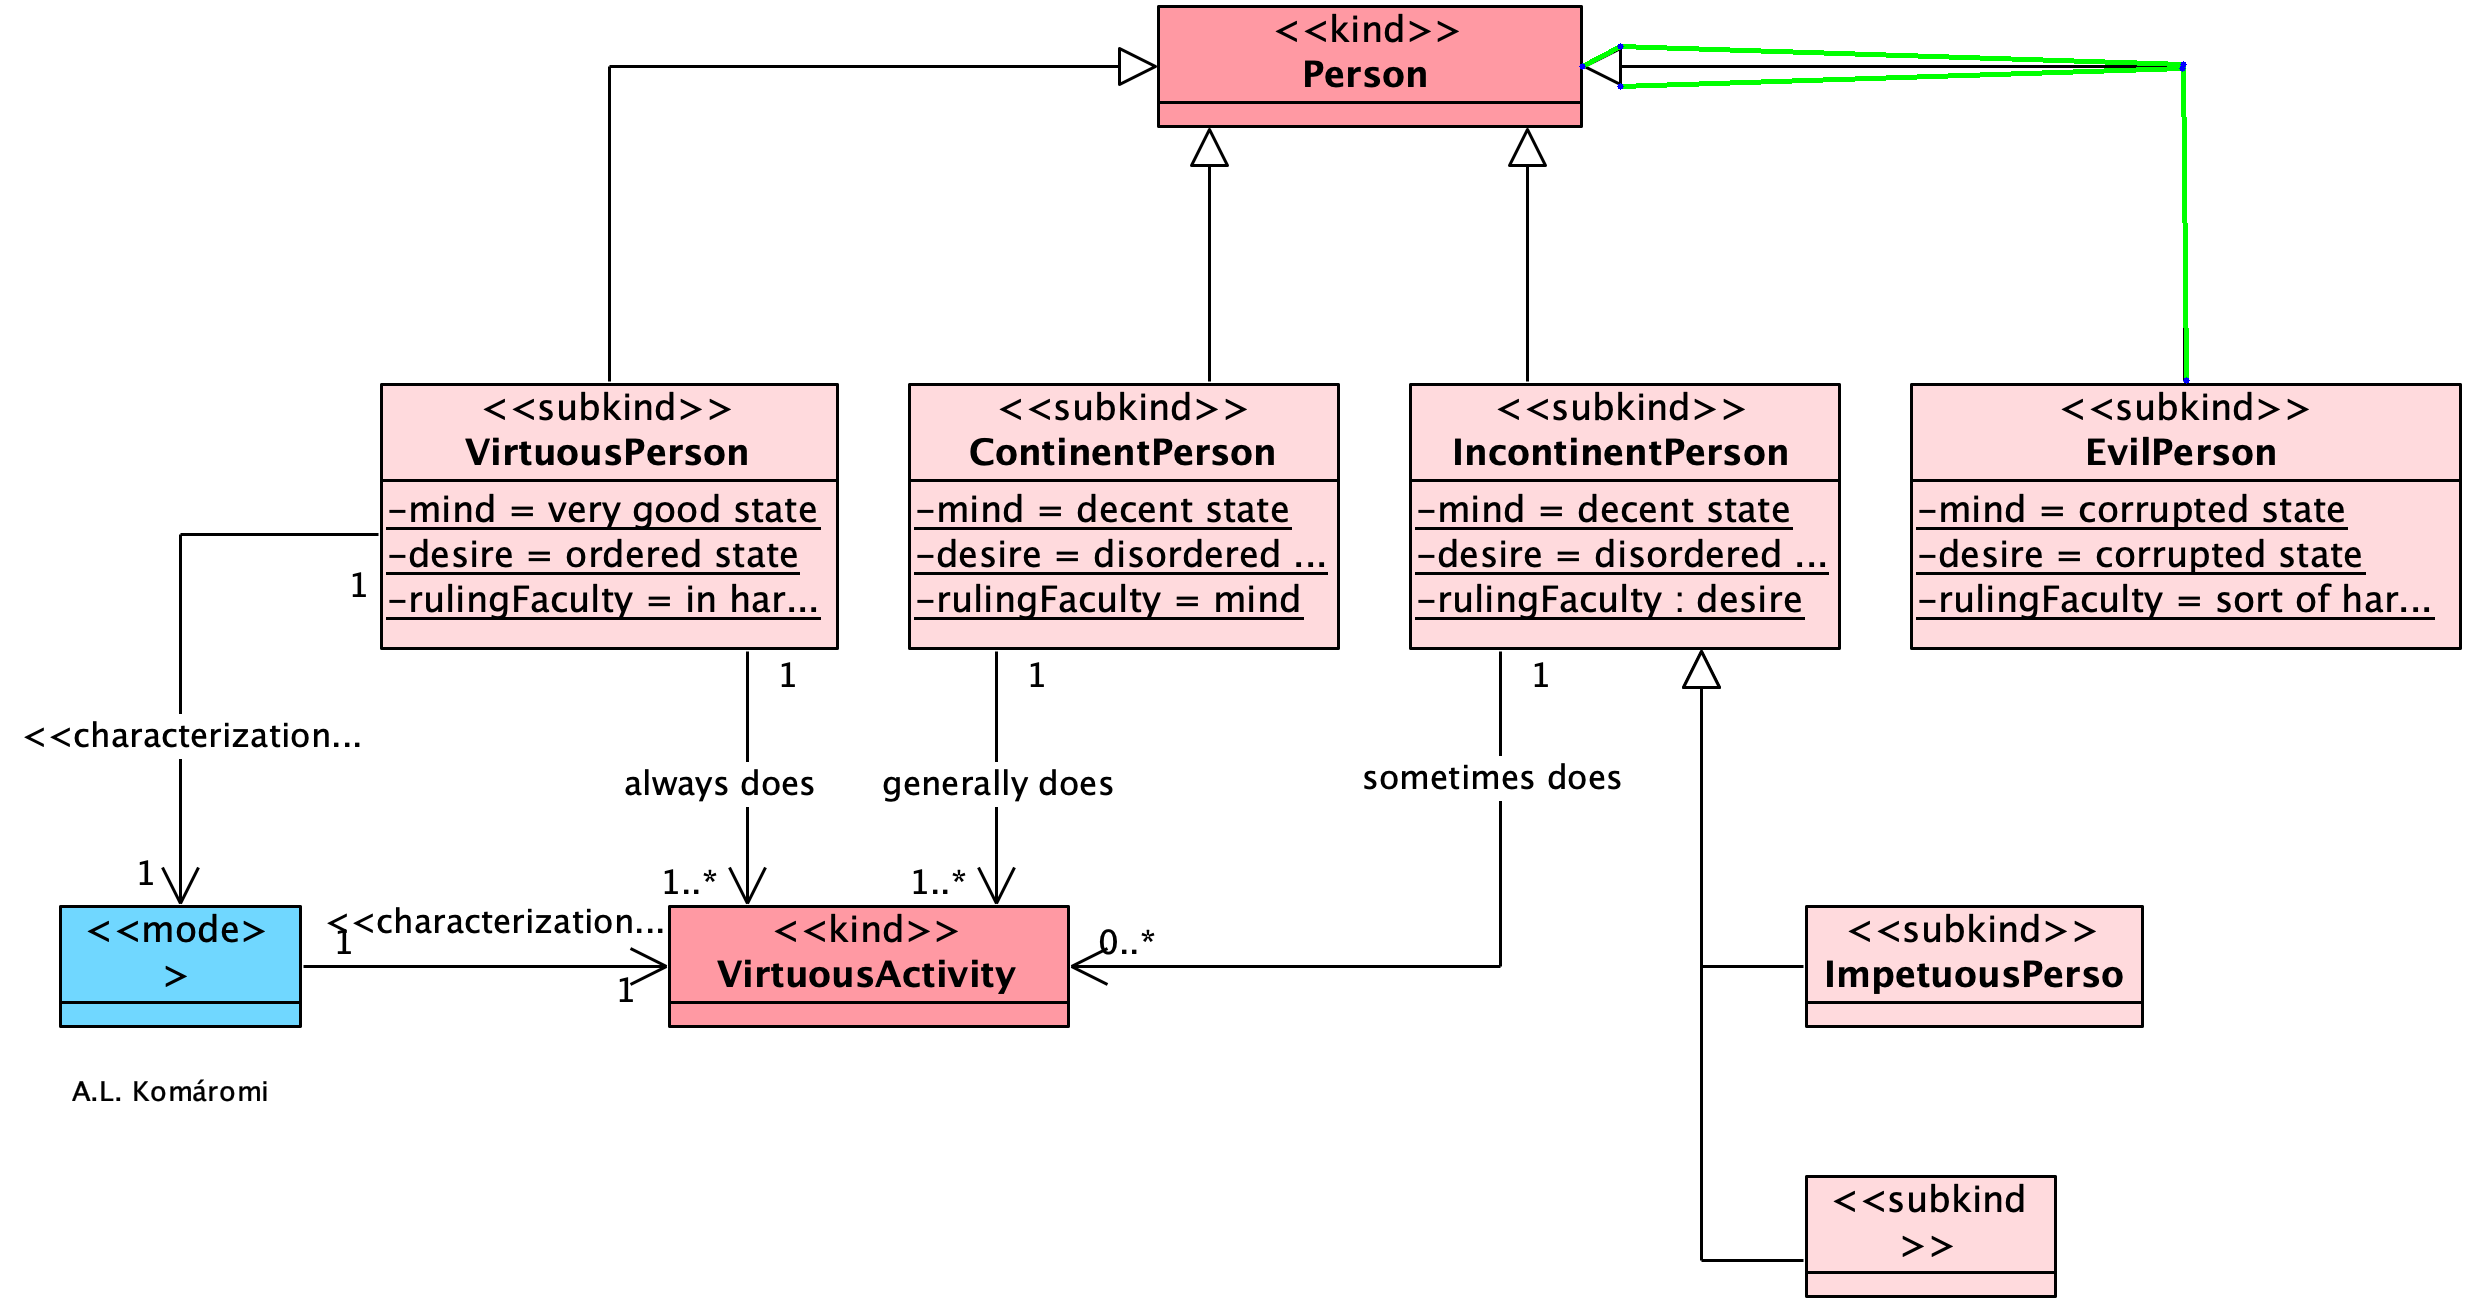



[(2, 5), (3, 4)]


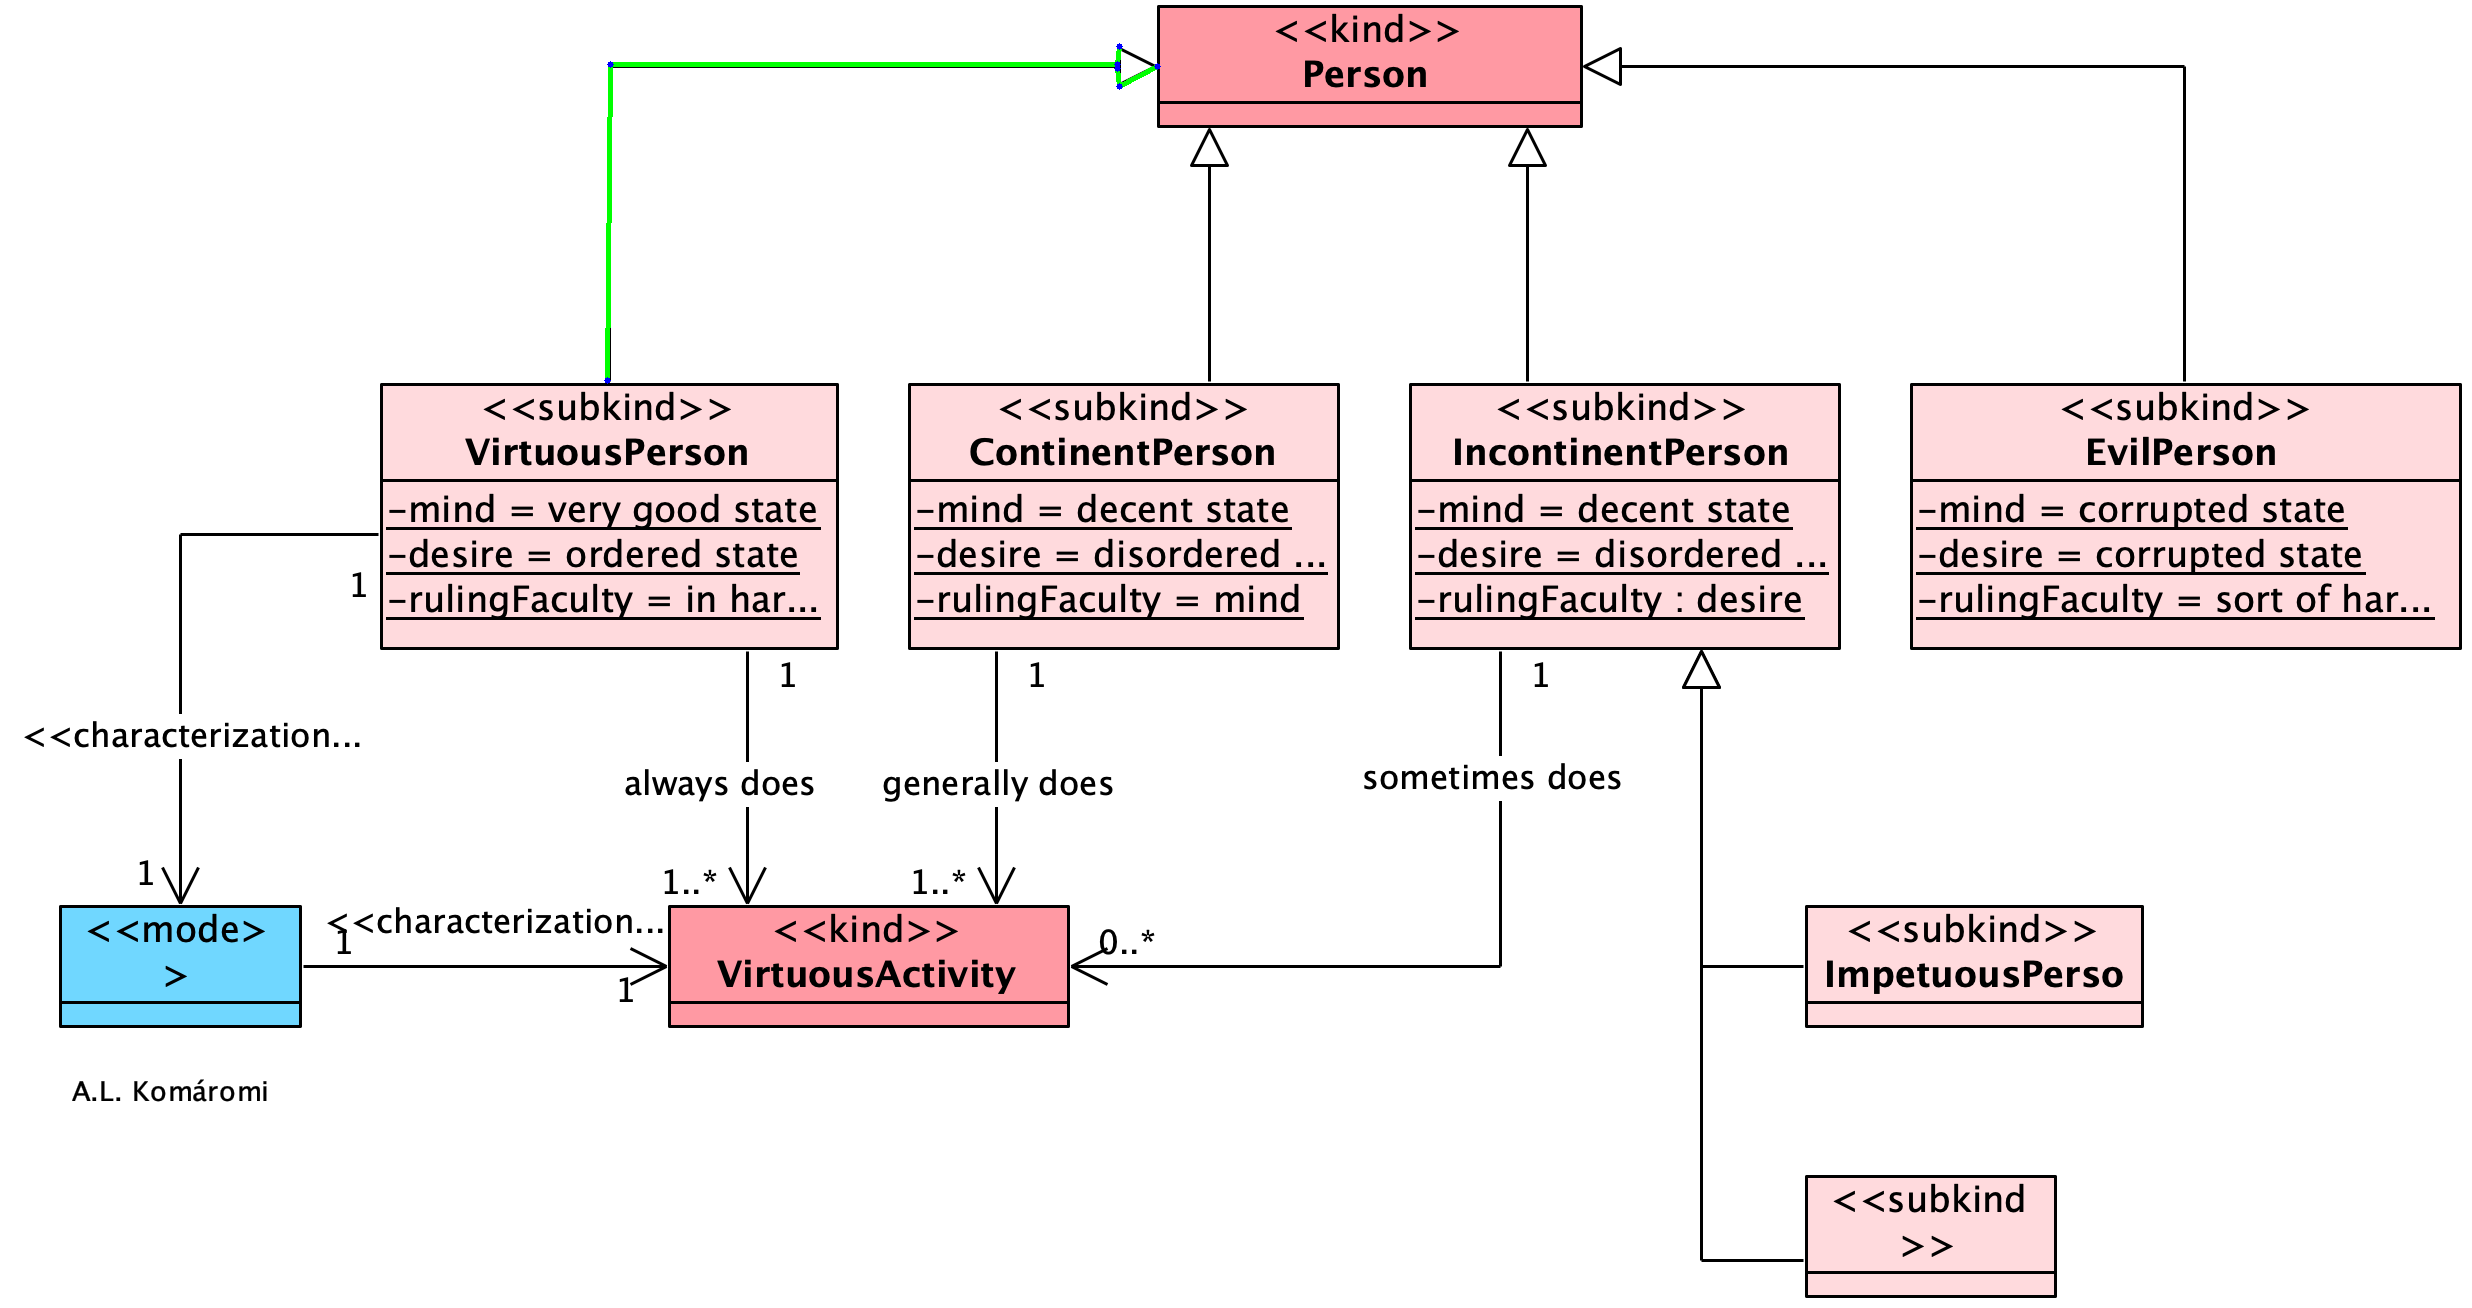

In [180]:
def is_point_close(p1, p2, threshold=5):
    return np.linalg.norm(np.array(p1) - np.array(p2)) <= threshold

def is_line_similar(line1, line2, threshold=5):
    p1_start, p1_end = line1
    p2_start, p2_end = line2

    # Check if origin points are close
    if is_point_close(p1_start, p2_start, threshold) and is_point_close(p1_end, p2_end, threshold):
      return True
    if is_point_close(p1_start, p2_end, threshold) and is_point_close(p1_end, p2_start, threshold):
      return True

    # Check if one line segment is part of the other
    def is_point_on_line_segment(point, line_start, line_end, threshold=5):
        line_vec = np.array(line_end) - np.array(line_start)
        point_vec = np.array(point) - np.array(line_start)
        line_len = np.linalg.norm(line_vec)
        line_unit_vec = line_vec / line_len
        projection_length = np.dot(point_vec, line_unit_vec)
        projection_point = np.array(line_start) + projection_length * line_unit_vec
        return (0 <= projection_length <= line_len) and is_point_close(point, projection_point, threshold)

    if is_point_on_line_segment(p1_start, p2_start, p2_end, threshold) and is_point_on_line_segment(p1_end, p2_start, p2_end, threshold):
        return True
    if is_point_on_line_segment(p2_start, p1_start, p1_end, threshold) and is_point_on_line_segment(p2_end, p1_start, p1_end, threshold):
        return True

    return False


def line_length(line):
    return np.linalg.norm(np.array(line[1]) - np.array(line[0]))

def filter_longest_similar_lines(lines, threshold=5):
    lines = np.array(lines)
    keep_lines = []
    similar_groups = []

    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            if is_line_similar(lines[i], lines[j], threshold):
                similar_groups.append((i, j))
    print(similar_groups)
    # Track lines to be removed
    to_remove = set()

    for group in similar_groups:
        line1, line2 = lines[group[0]], lines[group[1]]
        if line_length(line1) >= line_length(line2):
            to_remove.add(group[1])
        else:
            to_remove.add(group[0])

    for i in range(len(lines)):
        if i not in to_remove:
            keep_lines.append(lines[i])

    return np.array(keep_lines)



def remove_similar_lines(relations):

  for relation in relations:
    points = []
    lines = []
    for p in relation:
      new_point = [p[0][0], p[0][1]]

      if(len(points) > 0):
        last_point = points[-1]
        lines.append([last_point, new_point])

      points.append(new_point)

    points = np.array(points)
    lines = np.array(lines)
    lines = filter_longest_similar_lines(lines, 10)

    image = cv2.imread(image_path)
    new_lines = []
    for index, line in enumerate(lines):
        if line_length(line) > 15:
          new_lines.append(line)
        else:
          print("line skipped")
    lines = new_lines

    for line in lines:
      pt1 = (int(line[0][0]), int(line[0][1]))
      pt2 = (int(line[1][0]), int(line[1][1]))
      cv2.line(image, pt1, pt2, (0,255,0), 3)
      cv2.circle(image, pt1, 3, (255, 0, 0), -1)
      cv2.circle(image, pt2, 3, (255, 0, 0), -1)
    #print(relation)
    #cv2.polylines(image, [relation.astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)
    # for point2 in line:
    #   cv2.circle(image, (int(point2[0][0]), int(point2[0][1])), 3, (255, 0, 0), -1)
    cv2_imshow(image)
    print("\n")

#remove_similar_lines(relations)

In [111]:
print(result)

{<__main__.ImgRelation object at 0x7f91e49b0340>}
